In [1]:
import json
import os

from analysis import *
from plot_main import *
from choice_analysis import *
import seaborn as sns
import scipy.stats as stats
from mne.stats import permutation_cluster_test

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'

plt.rc('axes', linewidth=1)
plt.rc('xtick.major', width=2, size=8)
plt.rc('ytick.major', width=2, size=8)
plt.rc('xtick.minor', width=1, size=4)
plt.rc('ytick.minor', width=1, size=4)
plt.rc('mathtext', default='regular')


from _models_experimental import HierarchicalPlasticRNN
from _task_experimental import MDPRL


import random
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# %load_ext autoreload
# %autoreload 0

### Load model and run simulation on experimental reward schedule and stimuli

In [291]:
exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/exp/'
plot_save_dir = 'fp_approx'
os.chdir('/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN')

model_array_dir = [
    f'e_plas_only_large_l1_{i}' for i in range(1,9)
]

# model_array_dir = [
#     f'fp_approx_median_center_{i}' for i in range(1,9)
# ]

# model_array_dir = [
#     f'test_{i}' for i in range(1,9)
# ]


f = open(os.path.join(exp_dir, model_array_dir[0], 'args.json'), 'r')
args = json.load(f)
print('loaded args')
# load model
ITI = 0.4
choice_start = 0.8
rwd_start = 1.4

# experiment timeline [0.75 fixation, 2.5 stimulus, 0.5 action presentation, 1.0 reward presentation]
# 2021 paper          [0.5          , 0.7         , 0.3                    , 0.2                   ]
# here                [0.4          , 0.8         , 0.5                    , 0.02                  ]

exp_times = {
    'start_time': -ITI,
    'end_time': rwd_start,
    'stim_onset': 0.0,
    'stim_end': rwd_start,
    'choice_onset': choice_start,
    'choice_end': rwd_start,
    'rwd_onset': rwd_start,
    'rwd_end': rwd_start,
    'total_time': ITI+rwd_start,
    'dt': args['dt']}
log_interval = 10

task_mdprl = MDPRL(exp_times, args['input_type'])

input_size = {
    'feat': args['stim_dim']*args['stim_val'],
    'feat+obj': args['stim_dim']*args['stim_val']+args['stim_val']**args['stim_dim'], 
    'feat+conj+obj': args['stim_dim']*args['stim_val']+args['stim_dim']*args['stim_val']*args['stim_val']+args['stim_val']**args['stim_dim'],
}[args['input_type']]

args['num_options'] = 2 if 'double' in args['task_type'] else 1

num_options = 1 if args['task_type']=='value' else 2
if args['decision_space']=='action':
    output_size = num_options
elif args['decision_space']=='good':
    output_size = args['stim_val']**args['stim_dim']
else:
    raise ValueError('Invalid decision space')
args['output_size'] = output_size


model_specs = {'input_size': input_size, 'hidden_size': args['hidden_size'], 'output_size': output_size, 
                'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
                'dt_x': args['dt'], 'dt_w': exp_times['total_time'],  'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'rwd_input': args.get('rwd_input', False), 'action_input': args['action_input'], 
                'num_areas': args['num_areas'],
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1)}

E_SIZE = round(args['hidden_size']*args['e_prop'])
I_SIZE = round(args['hidden_size']*(1-args['e_prop']))
NUM_AREAS = args['num_areas']


all_models = []

for model_dir in model_array_dir:
    model = HierarchicalPlasticRNN(**model_specs)
#     print(model)
#     for n, p in model.named_parameters():
#         print(n, p.numel())
    state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.tar'), 
                            map_location=torch.device('cpu'))['model_state_dict']
    print(model.load_state_dict(state_dict))
    all_models.append(model)
    print(f'model at {model_dir} loaded successfully')


loaded args
<All keys matched successfully>
model at e_plas_only_large_l1_1 loaded successfully
<All keys matched successfully>
model at e_plas_only_large_l1_2 loaded successfully
<All keys matched successfully>
model at e_plas_only_large_l1_3 loaded successfully
<All keys matched successfully>
model at e_plas_only_large_l1_4 loaded successfully
<All keys matched successfully>
model at e_plas_only_large_l1_5 loaded successfully
<All keys matched successfully>
model at e_plas_only_large_l1_6 loaded successfully
<All keys matched successfully>
model at e_plas_only_large_l1_7 loaded successfully
<All keys matched successfully>
model at e_plas_only_large_l1_8 loaded successfully


/scratch/ipykernel_2287972/349578115.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.tar'),


In [292]:
def run_model(args, model_list, task_mdprl, n_samples=None):
    all_saved_states = defaultdict(list)
    output_size = args['output_size']    

    for model in model_list:
        model.eval()
        for p in model.parameters():
            p.requires_grad = False # disable gradient calculation for parameters
    if n_samples is None:
        n_samples = task_mdprl.test_stim_order.shape[1]
        
    n_models = len(model_list)
    model_assignment = np.concatenate([
        np.repeat(np.arange(n_models), n_samples//n_models),
        np.random.choice(np.arange(n_models), size=n_samples%n_models, replace=False)])
    model_assignment = np.random.permutation(model_assignment)
    
    print(np.unique(model_assignment, return_counts=True))
    
    for batch_idx in tqdm.tqdm(range(n_samples)):
        model = model_list[model_assignment[batch_idx]]
        pop_s, pop_c, rwd_s, target_valid, index_s, prob_s, _ = task_mdprl.generateinputfromexp(
            batch_size=1, test_N_s=args['test_N_s'], num_choices=args['num_options'], participant_num=batch_idx)
        
        # add empty list for the current episode
        all_saved_states['whs'].append([])

        all_saved_states['stimuli'].append(torch.from_numpy(np.expand_dims(index_s, axis=(1,2)))) # num trials X time_steps(1) X batch_size(1) X num_choices
        all_saved_states['reward_probs'].append(torch.from_numpy(np.expand_dims(prob_s, axis=(1,)))) # num_trials X time_steps(1) X batch_size X num_choices
        
        all_saved_states['logits'].append([])
        all_saved_states['choices'].append([])
        all_saved_states['foregone'].append([])
        all_saved_states['rewards'].append([])
        all_saved_states['choose_better'].append([])
        all_saved_states['hs'].append([])
        all_saved_states['rwd_sensitivity'].append([])
#         all_saved_states['ch_sensitivity'].append([])

        # reinitialize hidden layer activity
        hidden = None
        w_hidden = None

        for i in range(len(pop_s)):
            
            curr_trial_hs = []
            
            # first phase, give stimuli and no feedback
            _, hidden, w_hidden, hs = model(torch.zeros_like(pop_s[i].sum(1)), steps=task_mdprl.T_fixation,
                                            neumann_order=args['neumann_order'],
                                            hidden=hidden, w_hidden=w_hidden, DAs=None,
                                            Rs=torch.zeros(1, 2),
                                            acts=torch.zeros(1, output_size),
                                            save_all_states=True)
            curr_trial_hs.append(hs.detach())

            output, hidden, w_hidden, hs = model(pop_s[i].sum(1), steps=task_mdprl.T_stim,
                                                neumann_order=args['neumann_order'],
                                                hidden=hidden, w_hidden=w_hidden, DAs=None,
                                                Rs=torch.zeros(1, 2),
                                                acts=torch.zeros(1, output_size),
                                                save_all_states=True)
            curr_trial_hs.append(hs.detach())

            if args['task_type']=='on_policy_double':
                # use output to calculate action, reward, and record loss function
                if args['decision_space']=='action':
                    action = torch.argmax(output[-1,:,:], -1) # batch size
                    rwd = (torch.rand(args['batch_size'])<prob_s[i][range(args['batch_size']), action]).float()
                    all_saved_states['choose_better'][-1].append((action==torch.argmax(prob_s[i], -1)).float().squeeze())
                elif args['decision_space']=='good':
                    # action_valid = torch.argmax(output[:,index_s[i]], -1) # the object that can be chosen (0~1), (batch size, )
                    action_valid = torch.multinomial(output[:,index_s[i]].softmax(-1), num_samples=1).squeeze(-1)
                    all_saved_states['logits'][-1].append((output[:,index_s[i,1]]-output[:,index_s[i,0]]).detach()[None,...])
                    # backpropagate from choice to previous reward
                    if i>0:
                        (output[:,index_s[i,1]]-output[:,index_s[i,0]]).squeeze().backward()
                        all_saved_states['rwd_sensitivity'][-1].append(DAs.grad[None])
#                         all_saved_states['ch_sensitivity'][-1].append(action_enc.grad[None])
                        DAs.grad=None
                    else:
                        all_saved_states['rwd_sensitivity'][-1].append(torch.zeros(1, 1))
#                         all_saved_states['ch_sensitivity'][-1].append(torch.zeros(1, 1, 27))
                    
                    action = index_s[i, action_valid] # (batch size, )
                    nonaction = index_s[i, 1-action_valid] # (batch size, )
                    # rwd = (torch.rand(args['batch_size'])<prob_s[i][range(args['batch_size']), action_valid]).long()
                    rwd = rwd_s[i][range(args['batch_size']), action_valid]
                    all_saved_states['choose_better'][-1].append((action_valid==torch.argmax(prob_s[i], -1)).float()[None,...]) 
                all_saved_states['rewards'][-1].append(rwd.float()[None,...])
                all_saved_states['choices'][-1].append(action[None,...])
                all_saved_states['foregone'][-1].append(nonaction[None,...])
            elif args['task_type'] == 'value':
                raise NotImplementedError
                rwd = (torch.rand(1)<prob_s[i]).float()
                output = output.reshape(output_mask['target'].shape[0], 1, output_size)
                acc.append(((output-target_valid['pre_choice'][i])*output_mask['target'].float().unsqueeze(-1)).pow(2).mean(0)/output_mask['target'].float().mean())
                curr_rwd.append(rwd)
            
            if args['task_type']=='on_policy_double':
                # use the action (optional) and reward as feedback                
                pop_post = pop_s[i].sum(1)
                action_enc = pop_c[i][0, action_valid]
#                 action_enc = action_enc.requires_grad_()
                
                rwd_enc = torch.eye(2)[rwd]
                DAs = (2*rwd.float()-1)
                DAs = DAs.requires_grad_()
                
                hidden = hidden.detach()
                w_hidden = w_hidden.detach()

                _, hidden, w_hidden, hs = model(pop_post, steps=task_mdprl.T_ch,
                                               neumann_order=args['neumann_order'],
                                               hidden=hidden, w_hidden=w_hidden, 
                                               Rs=rwd_enc, acts=action_enc, DAs=DAs,
                                               save_all_states=True)
                curr_trial_hs.append(hs.detach())

            elif args['task_type'] == 'value':
                raise NotImplementedError
                pop_post = pop_s['post_choice'][i]
                rwd_enc = torch.eye(2)[rwd]
                DAs = (2*rwd.float()-1)*rwd_mask['post_choice']
                _, hs, hidden, ss = model(pop_post, hidden=hidden, Rs=rwd_enc, acts=None, DAs=DAs, save_weights=False)
            
            all_saved_states['hs'][-1].append(torch.cat(curr_trial_hs)) 
            # [num_sessions, [num_trials, [time, num_batch_size, hidden_size]]]
            all_saved_states['whs'][-1].append(w_hidden.detach()[None]) 
            # [num_sessions, [num_trials, [1, num_batch_size, hidden_size, hidden_size]]]

        # stack to create a trial dimension for each session
        for k in all_saved_states.keys():
            if isinstance(all_saved_states[k][-1], list):
                all_saved_states[k][-1] = torch.stack(all_saved_states[k][-1], axis=0)
        # [num_sessions, [num_trials, time_steps, num_batch_size, ...]]

    # concatenate all saved states along the batch dimension
    for k in all_saved_states.keys():
        all_saved_states[k] = torch.cat(all_saved_states[k], axis=2) # [num_trials, time_steps, num_sessions, ...]

    # concatenate all accuracies and rewards
    print(all_saved_states['rewards'].mean(), all_saved_states['choose_better'].mean())
    
    for k, v in all_saved_states.items():
        print(k, v.shape)
        
    all_saved_states['model_assignment'] = model_assignment
    all_saved_states['test_stim_dim_order'] = task_mdprl.test_stim_dim_order
    all_saved_states['test_stim_dim_order_reverse'] = task_mdprl.test_stim_dim_order_reverse
    all_saved_states['test_stim_val_order'] = task_mdprl.test_stim_val_order
    all_saved_states['test_stim_val_order_reverse'] = task_mdprl.test_stim_val_order_reverse
    all_saved_states['test_stim2sensory_idx'] = task_mdprl.test_stim2sensory_idx
    all_saved_states['test_sensory2stim_idx'] = task_mdprl.test_sensory2stim_idx
    
    return all_saved_states



In [293]:
# run model

import pickle

test_activities_dir = '/dartfs-hpc/scratch/f005d7d/attn-rnn-experimental/test_activities'

if os.path.exists(test_activities_dir):
    print('found previous record pickle, loading previous results')
    with open(test_activities_dir, 'rb') as f:
        all_saved_states = pickle.load(f)
    print('loaded previous results')
else:
    all_saved_states = run_model(args, all_models, task_mdprl)
    print('simulation complete')
    with open(test_activities_dir, 'wb') as f:
        pickle.dump(all_saved_states, f)
    print(f'saved results to {test_activities_dir}')


(array([0, 1, 2, 3, 4, 5, 6, 7]), array([11, 11, 11, 12, 12, 12, 12, 11]))


100%|██████████| 92/92 [09:34<00:00,  6.24s/it]


tensor(0.5728) tensor(0.6895)
whs torch.Size([432, 1, 92, 160, 160])
stimuli torch.Size([432, 1, 92, 2])
reward_probs torch.Size([432, 1, 92, 2])
logits torch.Size([432, 1, 92])
choices torch.Size([432, 1, 92])
foregone torch.Size([432, 1, 92])
rewards torch.Size([432, 1, 92])
choose_better torch.Size([432, 1, 92])
hs torch.Size([432, 89, 92, 160])
rwd_sensitivity torch.Size([432, 1, 92])
simulation complete
saved results to /dartfs-hpc/scratch/f005d7d/attn-rnn-experimental/test_activities


### Learning Curve

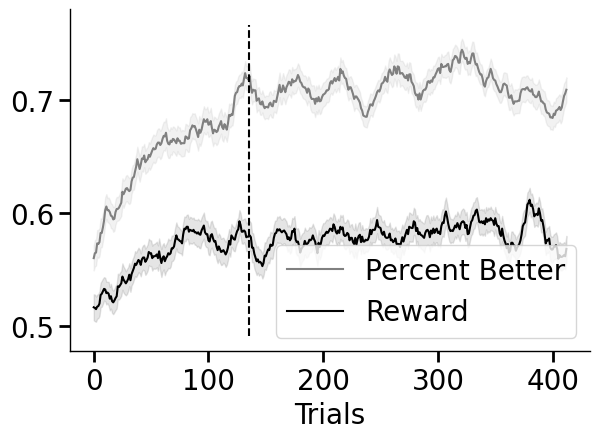

Figure saved at plots/fp_approx/learning_curve.pdf


In [294]:
plot_learning_curve(args, all_saved_states['rewards'], all_saved_states['choose_better'], plot_save_dir)

Finished calculating norm of update
Finished calculating weight norms
Finished calculating variability


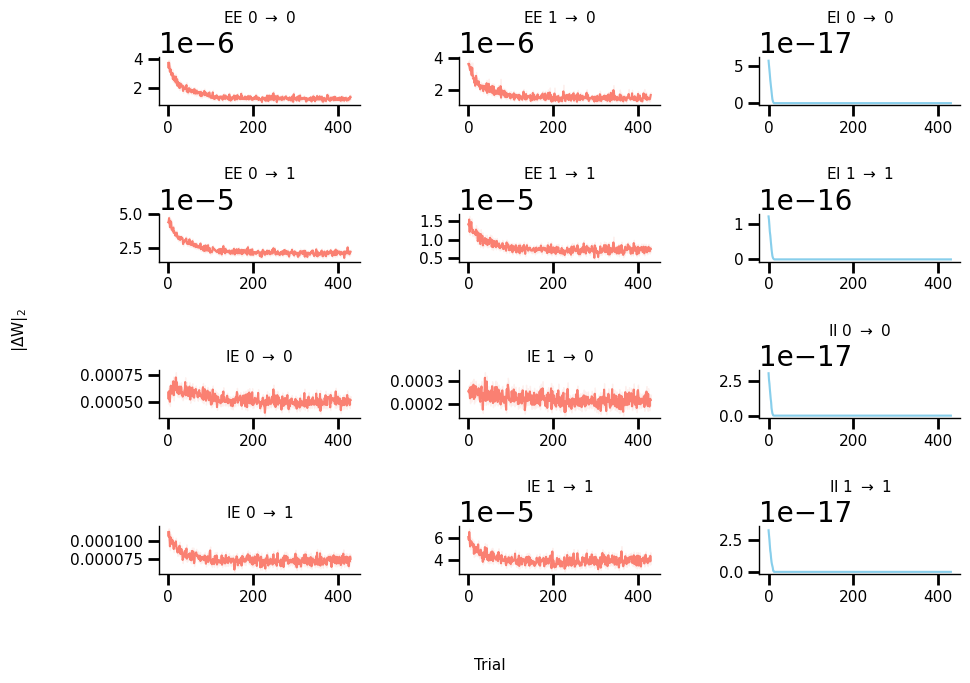

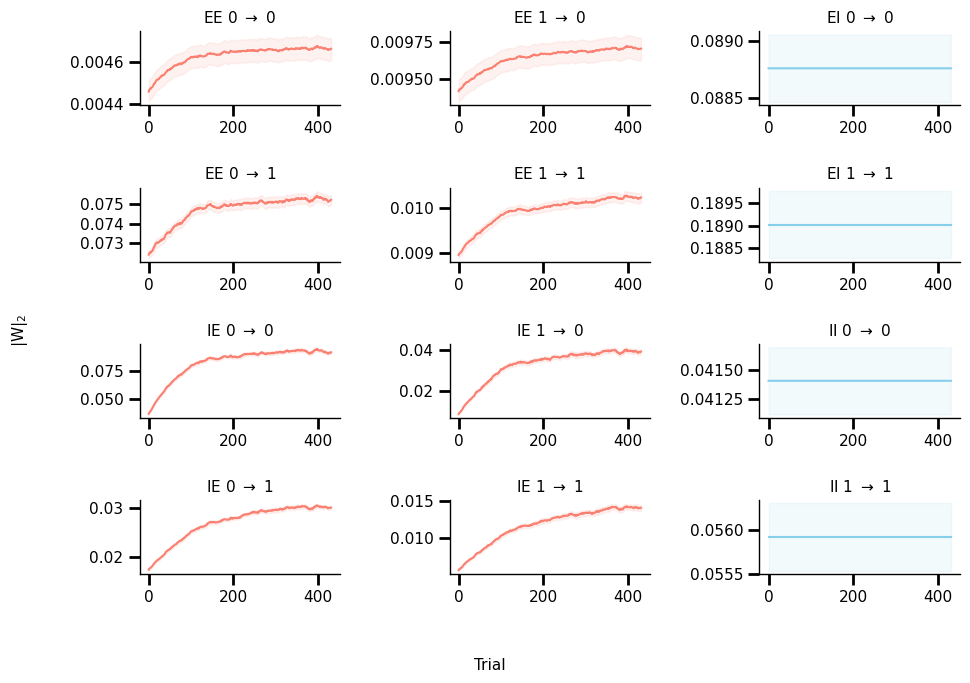

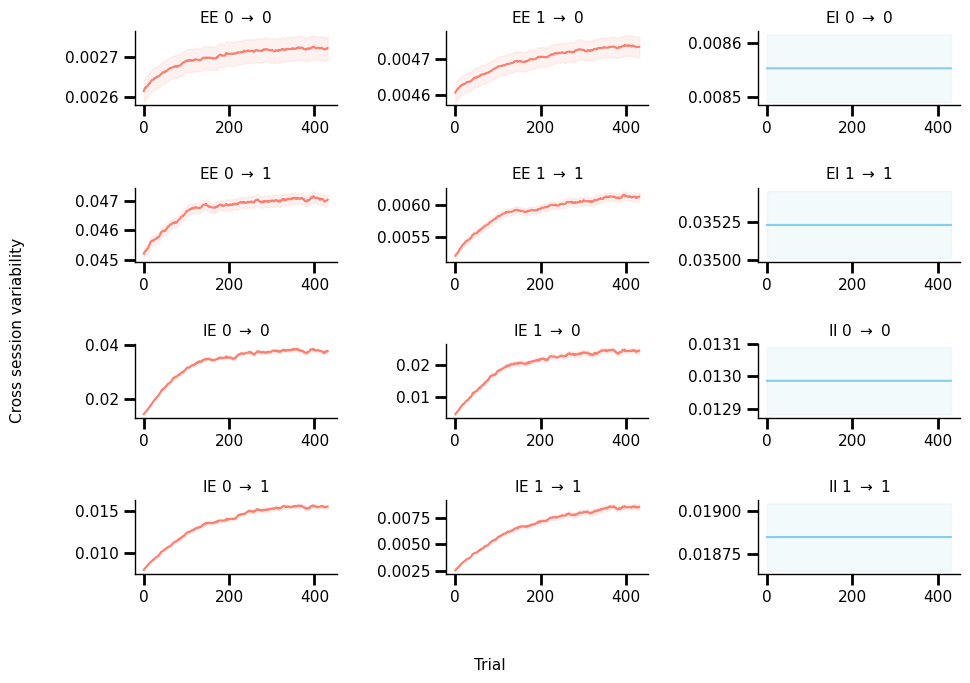

In [295]:
plot_weight_summary(args, all_saved_states['whs']*model.rnn.h2h.mask)

# Behavioral Analysis

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                19872
Model:                            GLM   Df Residuals:                    19868
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11147.
Date:                Mon, 23 Sep 2024   Deviance:                       22294.
Time:                        12:52:01   Pearson chi2:                 1.99e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2324
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0027      0.016      0.163      0.8

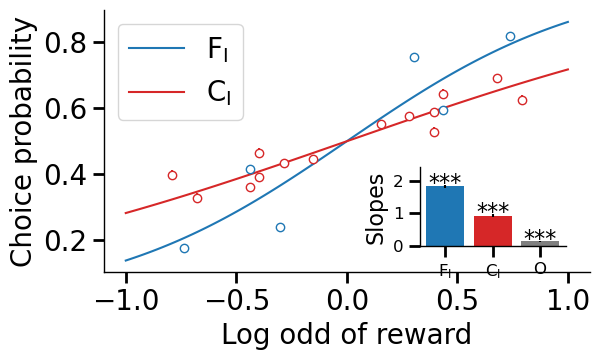

In [296]:
steady_state_choice_analysis(all_saved_states, task_mdprl, plot_save_dir)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                19780
Model:                            GLM   Df Residuals:                    19765
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13435.
Date:                Mon, 23 Sep 2024   Deviance:                       26869.
Time:                        12:52:09   Pearson chi2:                 1.98e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02750
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0069      0.014      0.477      0.6

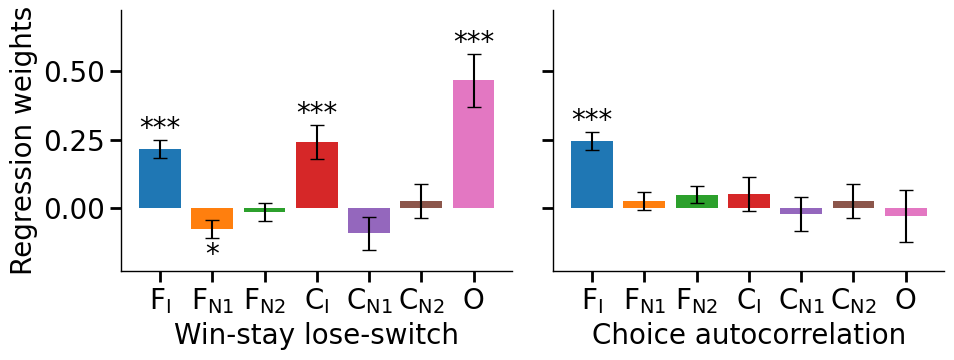

In [297]:
credit_assignment(all_saved_states, task_mdprl, plot_save_dir)

                            OLS Regression Results                            
Dep. Variable:                 logits   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     5511.
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:52:14   Log-Likelihood:                -41880.
No. Observations:               19872   AIC:                         8.377e+04
Df Residuals:                   19868   BIC:                         8.380e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0017      0.014     -0.124      0.9

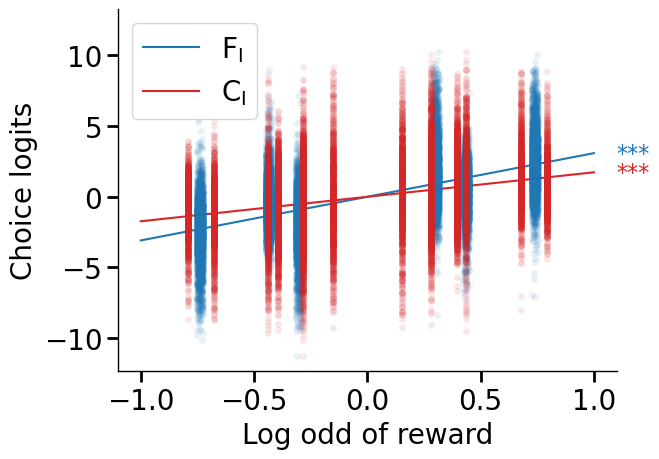

In [298]:
steady_state_choice_logit_analysis(all_saved_states, task_mdprl, plot_save_dir)

                            OLS Regression Results                            
Dep. Variable:                 logits   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     102.6
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          9.09e-288
Time:                        12:52:18   Log-Likelihood:                -42407.
No. Observations:               19780   AIC:                         8.484e+04
Df Residuals:                   19765   BIC:                         8.496e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0008      0.015      0.053      0.9

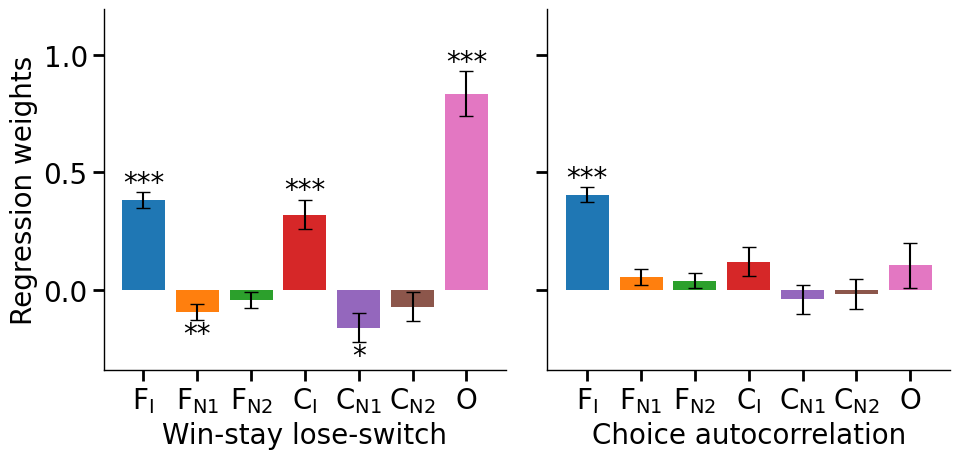

In [299]:
credit_assignment_logit(all_saved_states, task_mdprl, plot_save_dir)

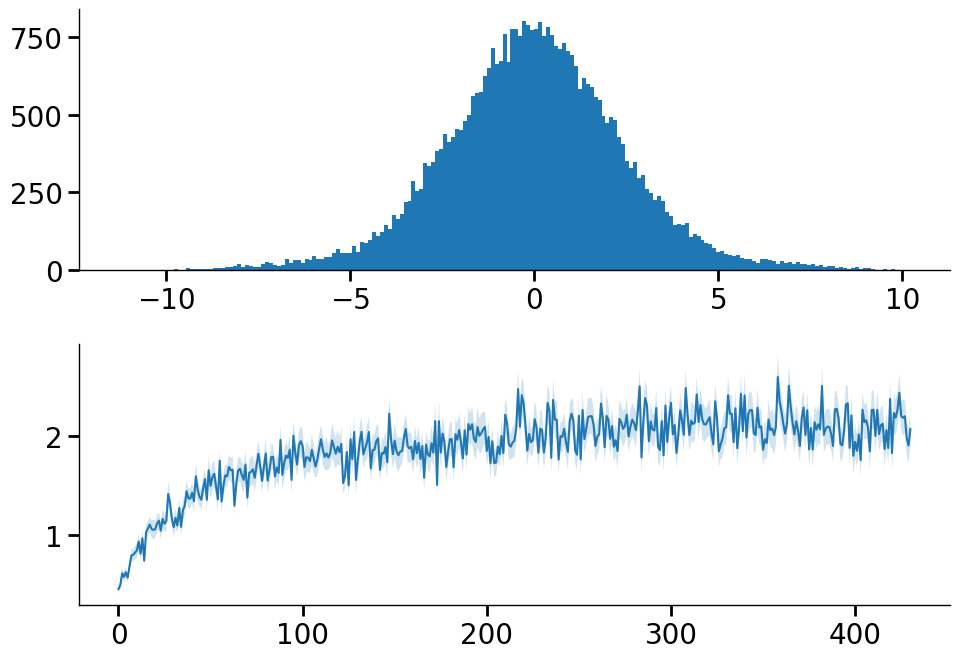

In [300]:
plt.subplot(211).hist((all_saved_states['logits'][1:]).flatten().numpy(), bins=200);


w_size=432//432
smth_sensitivity = np.stack([
    np.convolve(sens, np.ones(w_size)/w_size, mode='valid')
        for sens in all_saved_states['logits'].abs().squeeze().numpy()[1:].T]).T

plt.subplot(212).plot(smth_sensitivity.mean(1))
plt.subplot(212).fill_between(np.arange(smth_sensitivity.shape[0]), 
                              smth_sensitivity.mean(1)+smth_sensitivity.std(1)/np.sqrt(smth_sensitivity.shape[1]),
                              smth_sensitivity.mean(1)-smth_sensitivity.std(1)/np.sqrt(smth_sensitivity.shape[1]),
                             alpha=0.2)
sns.despine()
plt.tight_layout()

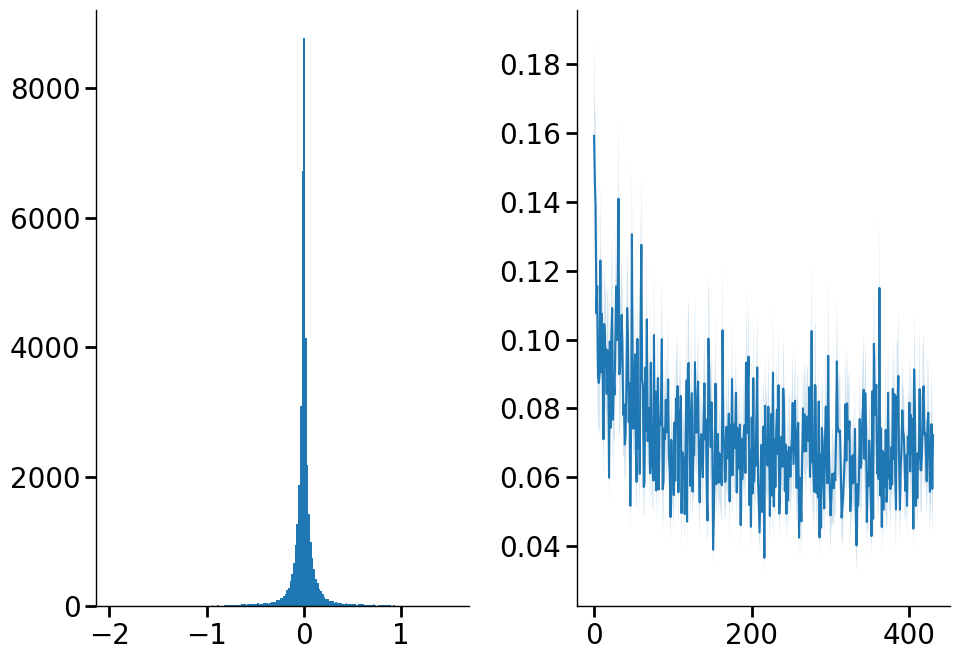

In [301]:
plt.subplot(121).hist((all_saved_states['rwd_sensitivity'][1:]).flatten().numpy(), bins=200);


w_size=432//432
smth_sensitivity = np.stack([
    np.convolve(sens, np.ones(w_size)/w_size, mode='valid')
        for sens in all_saved_states['rwd_sensitivity'].abs().squeeze().numpy()[1:].T]).T

plt.subplot(122).plot(smth_sensitivity.mean(1))
plt.subplot(122).fill_between(np.arange(smth_sensitivity.shape[0]), 
                              smth_sensitivity.mean(1)+smth_sensitivity.std(1)/np.sqrt(smth_sensitivity.shape[1]),
                              smth_sensitivity.mean(1)-smth_sensitivity.std(1)/np.sqrt(smth_sensitivity.shape[1]),
                             alpha=0.2)

# plt.subplot(223).hist((all_saved_states['ch_sensitivity'][1:]).flatten().numpy(), bins=200);


# smth_sensitivity = np.stack([
#     np.convolve(sens, np.ones(w_size)/w_size, mode='valid')
#         for sens in all_saved_states['ch_sensitivity'].abs().mean(-1).squeeze().numpy()[1:].T]).T

# plt.subplot(224).plot(smth_sensitivity.mean(1))
# plt.subplot(224).fill_between(np.arange(smth_sensitivity.shape[0]), 
#                               smth_sensitivity.mean(1)+smth_sensitivity.std(1)/np.sqrt(smth_sensitivity.shape[1]),
#                               smth_sensitivity.mean(1)-smth_sensitivity.std(1)/np.sqrt(smth_sensitivity.shape[1]),
#                              alpha=0.2)
sns.despine()
plt.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     497.2
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          1.79e-109
Time:                        12:52:27   Log-Likelihood:                -91275.
No. Observations:               39652   AIC:                         1.826e+05
Df Residuals:                   39650   BIC:                         1.826e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.012     -0.165      0.8

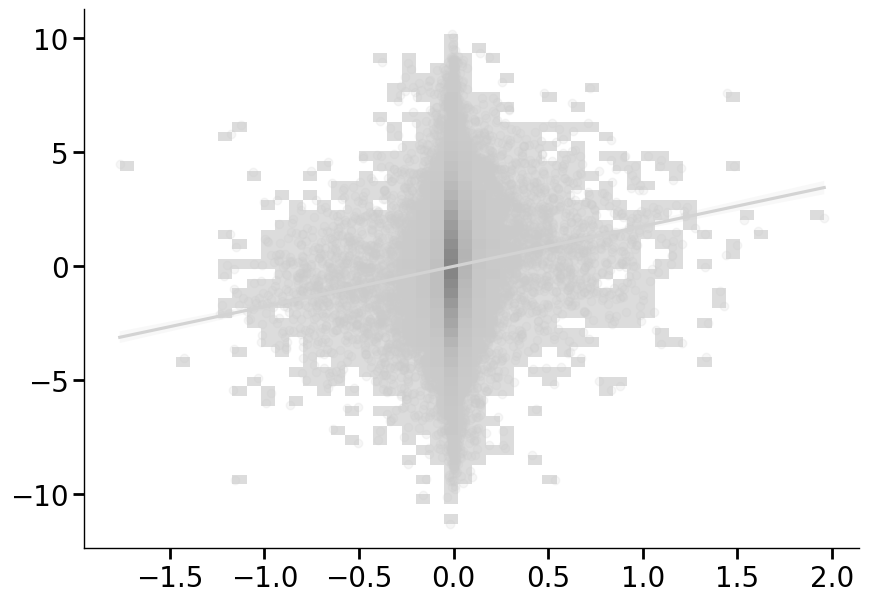

In [302]:
RXsensitivity = sm.add_constant(((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['rwd_sensitivity'][1:]).flatten().numpy())
lin_reg_logit_sensitivity = sm.OLS(all_saved_states['logits'][1:].flatten().numpy(), RXsensitivity).fit()

print(lin_reg_logit_sensitivity.summary())

# plt.plot(np.linspace(-4, 4, 100), 1/(1+np.exp(-0.4214*np.linspace(-4, 4, 100))))
# plt.scatter(((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['sensitivity'][1:]).flatten().numpy(),
#             (all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy(),
#            alpha=0.01)


sns.regplot(x=((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['rwd_sensitivity'][1:]).flatten().numpy(),
            y=all_saved_states['logits'][1:].flatten().numpy(),
            color='lightgrey', scatter_kws={'alpha': 0.2})
sns.histplot(x=((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['rwd_sensitivity'][1:]).flatten().numpy(),
            y=all_saved_states['logits'][1:].flatten().numpy(),
            color='grey', bins=50, alpha=0.6)
sns.despine()
# sns.kdeplot(x=((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['sensitivity'][1:]).flatten().numpy(),
#            hue=(all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy())

# plt.xlim([-5, 5])


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                39652
Model:                            GLM   Df Residuals:                    39650
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27338.
Date:                Mon, 23 Sep 2024   Deviance:                       54676.
Time:                        12:52:31   Pearson chi2:                 3.97e+04
No. Iterations:                     4   Pseudo R-squ. (CS):           0.007373
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.010      0.356      0.7

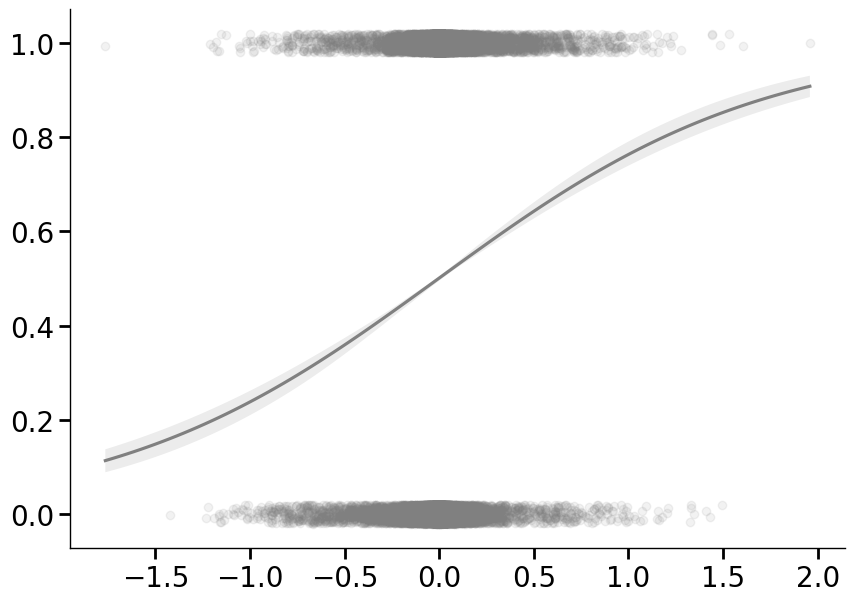

In [303]:
import statsmodels.api as sm


RXsensitivity = sm.add_constant(((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['rwd_sensitivity'][1:]).flatten().numpy())
choices = (all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy()
log_reg_choice_sensitivity = sm.GLM(choices, RXsensitivity, family=sm.families.Binomial()).fit()

print(log_reg_choice_sensitivity.summary())

# plt.plot(np.linspace(-4, 4, 100), 1/(1+np.exp(-0.4214*np.linspace(-4, 4, 100))))
# plt.scatter(((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['sensitivity'][1:]).flatten().numpy(),
#             (all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy(),
#            alpha=0.01)


sns.regplot(x=((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['rwd_sensitivity'][1:]).flatten().numpy(),
            y=(all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy(),
            n_boot=100, logistic=True, y_jitter=0.02, color='grey', scatter_kws={'alpha': 0.1})
sns.despine()
# sns.kdeplot(x=((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['sensitivity'][1:]).flatten().numpy(),
#            hue=(all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy())

# plt.xlim([-5, 5])


# Plot Initial Connectivity

4


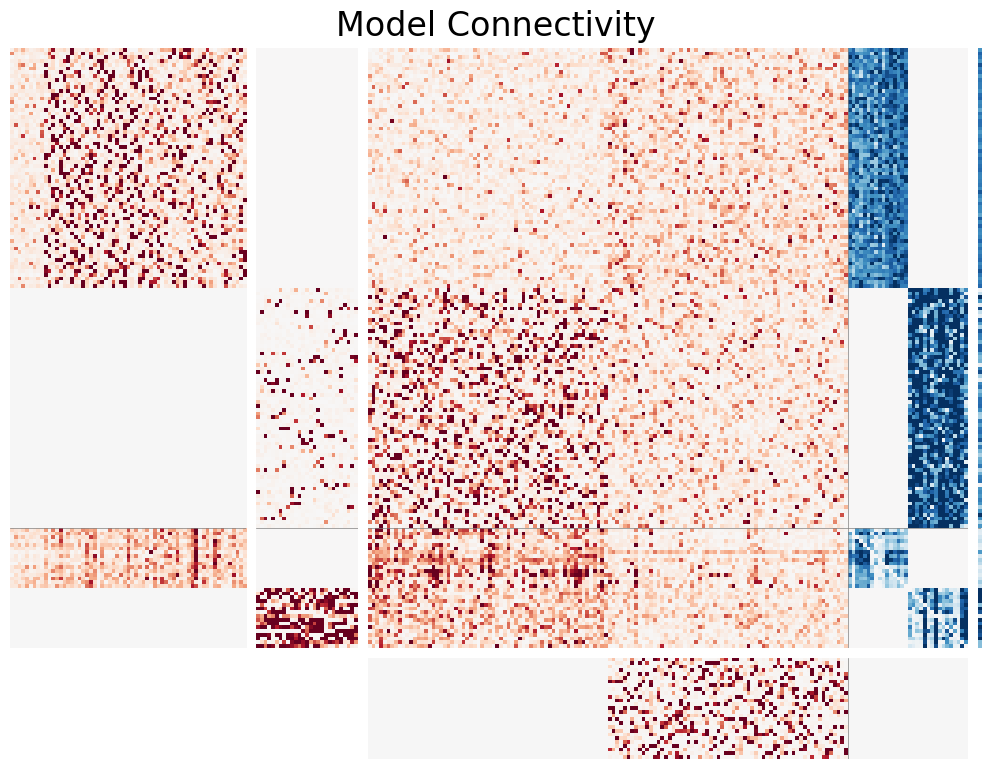

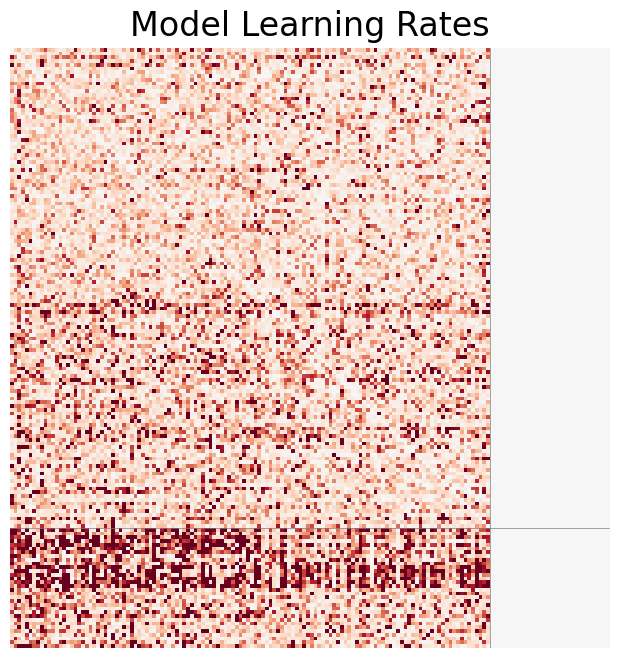

In [273]:
model_vis_idx = np.random.randint(len(all_models))
# model_vis_idx=7
print(model_vis_idx)
plot_connectivity_lr(torch.arange(args['hidden_size']*args['num_areas']), 
                             x2hw=all_models[model_vis_idx].rnn.x2h.effective_weight().detach(),
                             h2hw=all_models[model_vis_idx].rnn.h2h.effective_weight().detach(),
                             hb=all_models[model_vis_idx].rnn.h2h.bias.detach(),
                             h2ow=torch.cat([torch.zeros(27, E_SIZE), all_models[model_vis_idx].h2o.effective_weight().detach(), torch.zeros(27, I_SIZE*2)], dim=1),
                             aux2h=all_models[model_vis_idx].rnn.aux2h.effective_weight().detach(),
                             kappa_rec=all_models[model_vis_idx].plasticity.effective_lr().detach(),
                             e_size=int(args['e_prop']*args['hidden_size'])*args['num_areas'], args=args)

Figure saved at plots/fp_approx/wh_spectrum.pdf


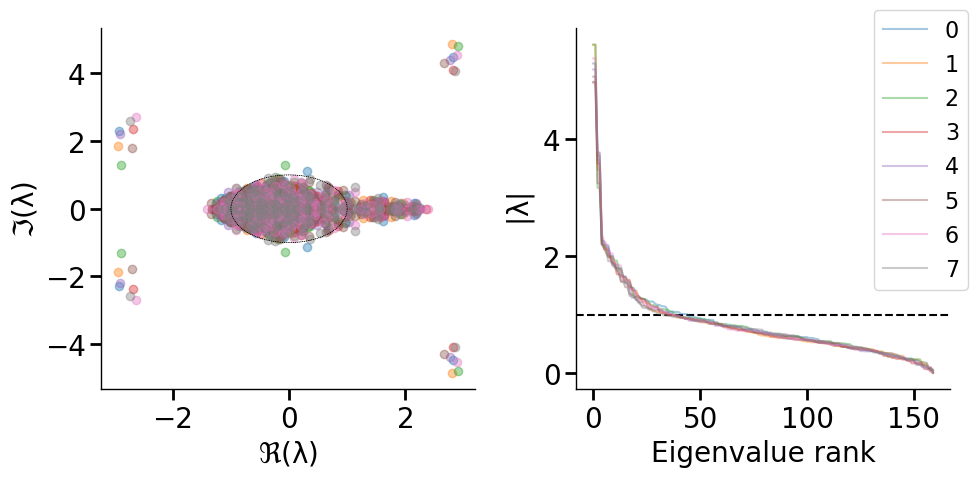

In [274]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].plot(np.cos(np.linspace(-2*np.pi,2*np.pi,100)),\
                   np.sin(np.linspace(-2*np.pi,2*np.pi,100)), \
                   'k:', linewidth=0.5)
# axes[0].plot(2*np.cos(np.linspace(-2*np.pi,2*np.pi,100)),\
#                    2*np.sin(np.linspace(-2*np.pi,2*np.pi,100)), \
#                    'k:', linewidth=0.5)
axes[1].axhline(1, linestyle='--', color='k')

all_eig_plots = []

for model_idx, model in enumerate(all_models):
    h2h = model.rnn.h2h.effective_weight().detach()
    axes[0].scatter(torch.linalg.eig(h2h).eigenvalues.real, 
                torch.linalg.eig(h2h).eigenvalues.imag,
                alpha=max(1/len(all_models), 0.4))
    all_eig_plots.append(axes[1].plot(torch.sort(torch.linalg.eig(h2h).eigenvalues.abs(), descending=True)[0], '-',
                  alpha=max(1/len(all_models), 0.4), label=model_idx))
#     bad_eigs = torch.linalg.eig(h2h).eigenvalues.abs()>=torch.sort(torch.linalg.eig(h2h).eigenvalues.abs())[0][-3]
#     axes[1,0].plot(torch.linalg.eig(h2h).eigenvectors.real[:,bad_eigs].numpy(), alpha=max(1/len(all_models), 0.2))
#     axes[1,1].plot(torch.linalg.eig(h2h).eigenvectors.imag[:,bad_eigs].numpy(), alpha=max(1/len(all_models), 0.2))

axes[0].set_xlabel(r'$\Re(\lambda)$')
axes[0].set_ylabel(r'$\Im(\lambda)$')
axes[1].set_xlabel('Eigenvalue rank')
axes[1].set_ylabel(r'$|\lambda|$')

fig.legend(fontsize=16)

# axes[0,1].set_yscale('log')
sns.despine()
plt.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/wh_spectrum.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/wh_spectrum.pdf')
    

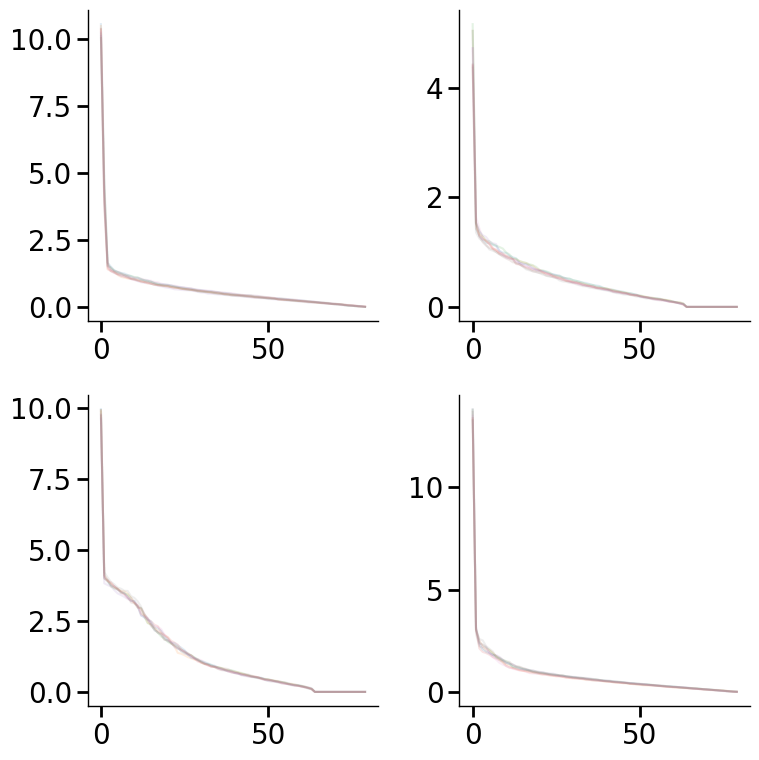

In [275]:
all_model_rec_intra = []
all_model_rec_inter_ff = []
all_model_rec_inter_fb = []

fig, axes = plt.subplots(NUM_AREAS, NUM_AREAS, figsize=(8,8))

# for i in range(NUM_AREAS):
#     axes[i,i].plot(np.cos(np.linspace(-2*np.pi,2*np.pi,100)),\
#                    np.sin(np.linspace(-2*np.pi,2*np.pi,100)), \
#                    'k--', linewidth=0.2)

for model in all_models:
    h2h = model.rnn.h2h.effective_weight().detach()

    rec_intra = []
#     us = []
#     vhs = []
    ss = []
    for i in range(NUM_AREAS):
        rec_intra.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                             list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                          [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                             list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
        u, sv, vh = np.linalg.svd(rec_intra[i], full_matrices=False)
#         s = np.linalg.eigvals(rec_intra[i])
    #     us.append(u)
    #     vhs.append(vh)
        ss.append(sv)

    #     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
    
    all_model_rec_intra.append(rec_intra)

    rec_inter_ff = []
    rec_inter_fb = []
#     us_ff = []
#     us_fb = []
#     vhs_ff = []
#     vhs_fb = []
    ss_ff = []
    ss_fb = []
    for i in range(NUM_AREAS-1):
        rec_inter_ff.append(h2h[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))]
                             [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
        rec_inter_fb.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                             [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])
        _, s, _ = np.linalg.svd(rec_inter_ff[i], full_matrices=False)
#        us_ff.append(u)
#        vhs_ff.append(vh)
        ss_ff.append(s)
        _, s, _ = np.linalg.svd(rec_inter_fb[i], full_matrices=False)
#        us_fb.append(u)
#        vhs_fb.append(vh)
        ss_fb.append(s)
        
    all_model_rec_inter_ff.append(rec_inter_ff)
    all_model_rec_inter_fb.append(rec_inter_fb)


    for i in range(NUM_AREAS):
#         axes[i,i].scatter(ss[i].real, ss[i].imag, alpha=1/len(all_models))
        axes[i,i].plot(np.arange(0,args['hidden_size']),ss[i],'-', alpha=1/len(all_models))

    for i in range(NUM_AREAS-1):
        axes[1,0].plot(np.arange(0,args['hidden_size']),ss_ff[i],'-', alpha=1/len(all_models))
        axes[0,1].plot(np.arange(0,args['hidden_size']),ss_fb[i],'-', alpha=1/len(all_models))

sns.despine()
plt.tight_layout()
plt.show()

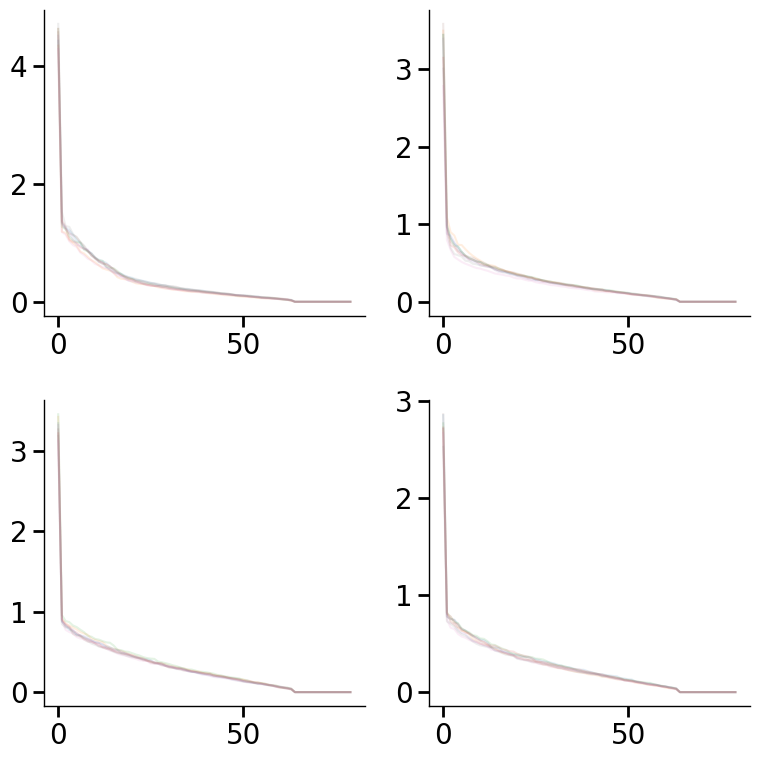

In [276]:
all_model_kappa_rec_intra = []
all_model_kappa_inter_ff = []
all_model_kappa_inter_fb = []

fig, axes = plt.subplots(2,2, figsize=(8,8))

for model in all_models:

    kappa_rec = model.plasticity.effective_lr().detach()

    kappa_rec_intra = []
    us = []
    vhs = []
    ss = []
    for i in range(NUM_AREAS):
        kappa_rec_intra.append(kappa_rec[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                   list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                                  [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                     list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
        u, s, vh = np.linalg.svd(kappa_rec_intra[i], full_matrices=False)
    #     s = np.linalg.eigvals(kappa_rec_intra[i])
#         us.append(u)
#         vhs.append(vh)
        ss.append(s)
        
    all_model_kappa_rec_intra.append(kappa_rec_intra)
    
    for i in range(NUM_AREAS):
        axes[i,i].plot(np.arange(0,args['hidden_size']), ss[i][:], '-', alpha=1/len(all_models))
        
    
    kappa_inter_ff = []
    kappa_inter_fb = []
    us_ff = []
    us_fb = []
    vhs_ff = []
    vhs_fb = []
    ss_ff = []
    ss_fb = []
    for i in range(NUM_AREAS-1):
        kappa_inter_ff.append(kappa_rec[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                     list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))]
                                 [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                    list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
        kappa_inter_fb.append(kappa_rec[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                     list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                                    [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                       list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])
        u, s, vh = np.linalg.svd(kappa_inter_ff[i], full_matrices=False)
#        us_ff.append(u)
#        vhs_ff.append(vh)
        ss_ff.append(s)
        u, s, vh = np.linalg.svd(kappa_inter_fb[i], full_matrices=False)
#        us_fb.append(u)
#        vhs_fb.append(vh)
        ss_fb.append(s)
        
    all_model_kappa_inter_ff.append(kappa_inter_ff)
    all_model_kappa_inter_fb.append(kappa_inter_fb)

    
    axes[1,0].plot(np.arange(0,args['hidden_size']), ss_ff[0][:], '-', alpha=1/len(all_models))
    axes[0,1].plot(np.arange(0,args['hidden_size']), ss_fb[0][:], '-', alpha=1/len(all_models))

sns.despine()
plt.tight_layout()
plt.show()

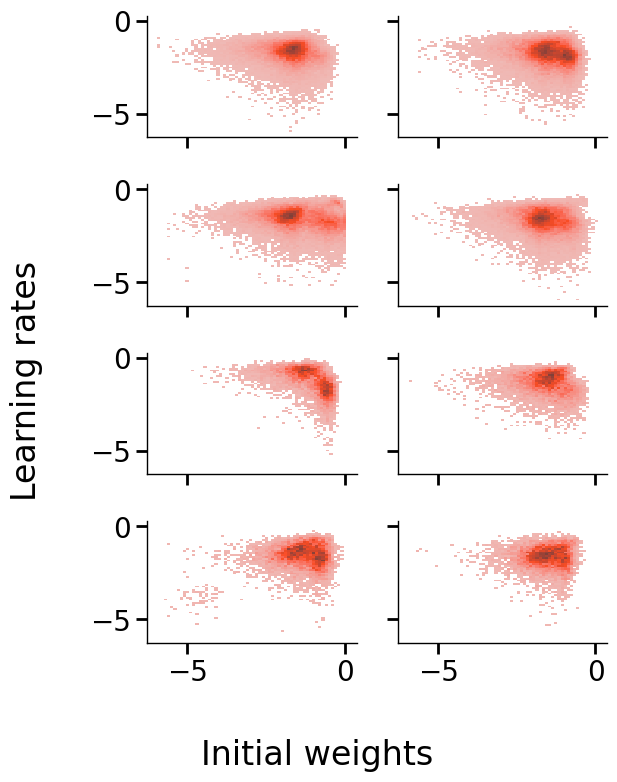

In [277]:
fig, axes = plt.subplots(4,2, figsize=(6.4, 8), sharex=True, sharey=True)

flat_rec_w = np.array(all_model_rec_intra)
flat_rec_w[np.abs(flat_rec_w)<np.finfo(float).eps] = np.nan
flat_rec_kappa = np.array(all_model_kappa_rec_intra)
flat_rec_kappa[np.abs(flat_rec_kappa)<np.finfo(float).eps] = np.nan

eps_for_hist = 1e-6
binwidth = 0.1

sns.histplot(x=np.log10(flat_rec_w[:,0,:E_SIZE,:E_SIZE].flatten()+eps_for_hist), 
             y=np.log10(flat_rec_kappa[:,0,:E_SIZE,:E_SIZE].flatten()+eps_for_hist),
             ax=axes[0,0], color='salmon', binwidth=binwidth)

sns.histplot(x=np.log10(flat_rec_w[:,0,E_SIZE:,:E_SIZE].flatten()+eps_for_hist), 
             y=np.log10(flat_rec_kappa[:,0,E_SIZE:,:E_SIZE].flatten()+eps_for_hist),
             ax=axes[2,0], color='salmon', binwidth=binwidth)


sns.histplot(x=np.log10(flat_rec_w[:,1,:E_SIZE,:E_SIZE].flatten()+eps_for_hist), 
                y=np.log10(flat_rec_kappa[:,1,:E_SIZE,:E_SIZE].flatten()+eps_for_hist),
                ax=axes[1,1], color='salmon', binwidth=binwidth)

sns.histplot(x=np.log10(flat_rec_w[:,1,E_SIZE:,:E_SIZE].flatten()+eps_for_hist), 
                y=np.log10(flat_rec_kappa[:,1,E_SIZE:,:E_SIZE].flatten()+eps_for_hist),
                ax=axes[3,1], color='salmon', binwidth=binwidth)


flat_inter_w = np.array(all_model_rec_inter_ff).squeeze()
flat_inter_kappa = np.array(all_model_kappa_inter_ff).squeeze()

sns.histplot(x=np.log10(flat_inter_w[:,:E_SIZE,:E_SIZE].flatten()+eps_for_hist), 
             y=np.log10(flat_inter_kappa[:,:E_SIZE,:E_SIZE].flatten()+eps_for_hist),
             ax=axes[1,0], color='salmon', binwidth=binwidth)

sns.histplot(x=np.log10(flat_inter_w[:,E_SIZE:,:E_SIZE].flatten()+eps_for_hist), 
             y=np.log10(flat_inter_kappa[:,E_SIZE:,:E_SIZE].flatten()+eps_for_hist),
             ax=axes[3,0], color='salmon', binwidth=binwidth)


flat_inter_w = np.array(all_model_rec_inter_fb).squeeze()
flat_inter_kappa = np.array(all_model_kappa_inter_fb).squeeze()

sns.histplot(x=np.log10(flat_inter_w[:,:E_SIZE,:E_SIZE].flatten()+eps_for_hist), 
                y=np.log10(flat_inter_kappa[:,:E_SIZE,:E_SIZE].flatten()+eps_for_hist),
                ax=axes[0,1], color='salmon', binwidth=binwidth)

sns.histplot(x=np.log10(flat_inter_w[:,E_SIZE:,:E_SIZE].flatten()+eps_for_hist), 
                y=np.log10(flat_inter_kappa[:,E_SIZE:,:E_SIZE].flatten()+eps_for_hist),
                ax=axes[2,1], color='salmon', binwidth=binwidth)


fig.supxlabel('Initial weights')
fig.supylabel('Learning rates')
sns.despine()
fig.tight_layout()




# Subspace Analysis


### Decompose each input, output, and choice pattern as a sum of feature, conjunction, and object patterns
$I_{i} = I_{ft}(i)+I_{conj}(i)+I_{obj}(i)$

In [278]:
input_weight_inds = list(range(E_SIZE)) + list(range(E_SIZE*args['num_areas'], E_SIZE*args['num_areas']+I_SIZE))
output_weight_inds = list(range(E_SIZE, 2*E_SIZE)) + list(range(E_SIZE*args['num_areas']+I_SIZE, E_SIZE*args['num_areas']+2*I_SIZE))


all_model_stims = []


for model in all_models:
    stims, global_avg_in, ft_avg_in, conj_avg_in, obj_avg_in = get_input_encodings(
        model.rnn.x2h.effective_weight()[input_weight_inds].detach().numpy().copy(), 
        task_mdprl.stim_encoding('all_onehot'))
    all_model_stims.append(stims)

n_components_for_dpca = {'s':2, 'p':2, 'c':2, 'sc':4, 'sp':4, 'pc':4, 'spc': 8}


all_model_dpca_in = []
all_model_dpca_out = []
all_model_dpca_ch = []

all_model_low_input = []
all_model_low_output = []
all_model_low_ch = []


all_model_dpca_in_exc = []
all_model_dpca_in_inh = []
all_model_dpca_ch_exc = []
all_model_dpca_ch_inh = []


for model_idx, model in enumerate(all_models):
    dpca_in = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
    low_input = dpca_in.fit_transform(all_model_stims[model_idx].reshape((args['hidden_size'],3,3,3)))
    
    dpca_in_exc = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
    _ = dpca_in_exc.fit_transform(all_model_stims[model_idx][:E_SIZE].reshape((E_SIZE,3,3,3)))
    
    dpca_in_inh = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
    _ = dpca_in_inh.fit_transform(all_model_stims[model_idx][E_SIZE:].reshape((I_SIZE,3,3,3)))
    
    expanded_h2o = np.concatenate([model.h2o.effective_weight().detach().numpy().copy(), np.zeros((27, I_SIZE))], axis=1)
    dpca_out = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
    low_output = dpca_out.fit_transform(expanded_h2o.T.reshape((args['hidden_size'],3,3,3)))
    
    dpca_ch = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
    low_ch = dpca_ch.fit_transform(model.rnn.aux2h.effective_weight().detach().numpy().copy()[output_weight_inds,:]\
                                   .reshape((args['hidden_size'],3,3,3)))

    dpca_ch_exc = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
    _ = dpca_ch_exc.fit_transform(model.rnn.aux2h.effective_weight().detach().numpy().copy()[output_weight_inds[:E_SIZE],:]\
                                   .reshape((E_SIZE,3,3,3)))

    dpca_ch_inh = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
    _ = dpca_ch_inh.fit_transform(model.rnn.aux2h.effective_weight().detach().numpy().copy()[output_weight_inds[E_SIZE:],:]\
                                   .reshape((I_SIZE,3,3,3)))

    all_model_dpca_in.append(dpca_in)
    all_model_dpca_out.append(dpca_out)
    all_model_dpca_ch.append(dpca_ch)
    
    all_model_low_input.append(low_input)
    all_model_low_output.append(low_output)
    all_model_low_ch.append(low_ch)
    
    all_model_dpca_in_exc.append(dpca_in_exc)
    all_model_dpca_in_inh.append(dpca_in_inh)
    all_model_dpca_ch_exc.append(dpca_ch_exc)
    all_model_dpca_ch_inh.append(dpca_ch_inh)
    


/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:984: RuntimeWarning: invalid value encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]


/scratch/ipykernel_2287972/2546406266.py:43: RuntimeWarning: Mean of empty slice
  unitwise_selectivity_output[model_idx,:,1] = np.nanmean(curr_model_unitwise_selectivity[:,E_SIZE:], 1)


Figure saved at plots/fp_approx/selectivity_profile.pdf


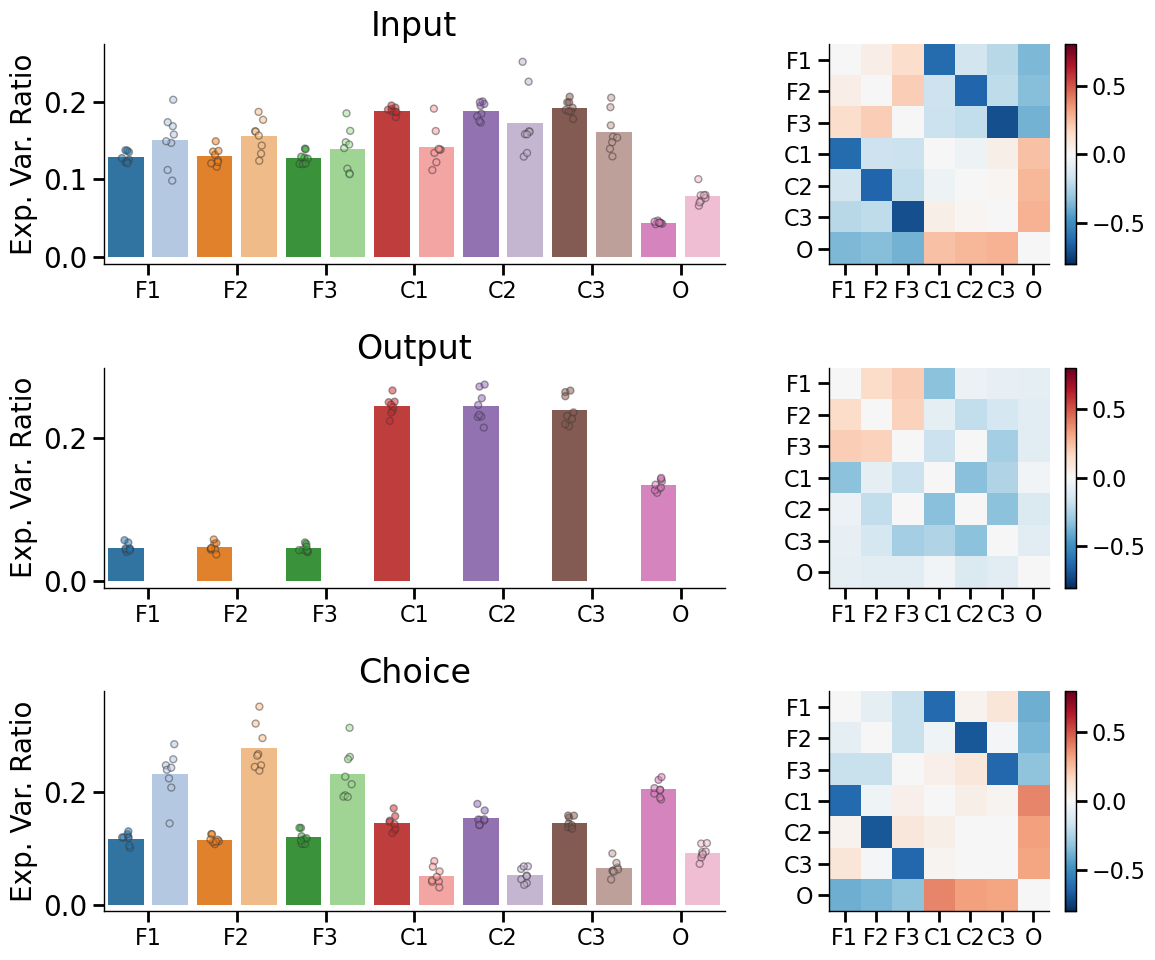

In [279]:
fig, axes = plt.subplots(3, 2, width_ratios=(2, 1), figsize=(12,10))

corr_scale = 0.8

xxx_for_plot = np.repeat(np.arange(14)[None], len(all_models), axis=0)
xxx_for_plot[xxx_for_plot%2==0]=xxx_for_plot[xxx_for_plot%2==0]
xxx_for_plot[xxx_for_plot%2==1]=xxx_for_plot[xxx_for_plot%2==1]

unitwise_selectivity_input = np.zeros((len(all_models), 7, 2))
selelctivity_corr_input = np.zeros((len(all_models), 7, 7))
for model_idx, model in enumerate(all_models):
    curr_model_unitwise_selectivity = np.zeros((7, args['hidden_size']))
    for k_idx, k in enumerate(['s','p','c','pc','sc','sp','spc']):
        curr_model_unitwise_selectivity[k_idx] = \
            np.sum(all_model_dpca_in[model_idx].unitwise_explained_variance_ratio_[k], 0)
        unitwise_selectivity_input[model_idx,k_idx,0] = \
                np.nanmean(np.nansum(all_model_dpca_in[model_idx].unitwise_explained_variance_ratio_[k],0)[:E_SIZE],0)
        unitwise_selectivity_input[model_idx,k_idx,1] = \
                np.nanmean(np.nansum(all_model_dpca_in[model_idx].unitwise_explained_variance_ratio_[k],0)[E_SIZE:],0)
#     selelctivity_corr_input[model_idx] = np.corrcoef(curr_model_unitwise_selectivity)-np.eye(7)
    selelctivity_corr_input[model_idx] = stats.spearmanr(curr_model_unitwise_selectivity.T).statistic-np.eye(7)
# axes[0,0].imshow(unitwise_selectivity_input.mean(0).T, aspect='auto', cmap='hot', vmin=0, vmax=1)
sns.barplot(ax=axes[0,0], x=xxx_for_plot.flatten(), hue=xxx_for_plot.flatten(),
            y=unitwise_selectivity_input.flatten(),
            palette='tab20', errorbar=None, legend=False)
sns.stripplot(ax=axes[0,0], x=xxx_for_plot.flatten(), y=unitwise_selectivity_input.flatten(),
              hue=xxx_for_plot.flatten(),
              palette='tab20', legend=False, linewidth=1, alpha=0.5)
im = axes[0,1].imshow(selelctivity_corr_input.mean(0), cmap='RdBu_r', vmin=-corr_scale, vmax=corr_scale)
cb = plt.colorbar(im, shrink=1)
cb.ax.tick_params(labelsize=16)
axes[0,0].set_title('Input')

unitwise_selectivity_output = np.zeros((len(all_models), 7, 2))
selelctivity_corr_output = np.zeros((len(all_models), 7, 7))
for model_idx, model in enumerate(all_models):
    curr_model_unitwise_selectivity = np.zeros((7, args['hidden_size']))
    for k_idx, k in enumerate(['s','p','c','pc','sc','sp','spc']):
        curr_model_unitwise_selectivity[k_idx] = \
            np.sum(all_model_dpca_out[model_idx].unitwise_explained_variance_ratio_[k], 0)
    curr_model_unitwise_selectivity = np.nan_to_num(curr_model_unitwise_selectivity, nan=np.nan, neginf=0)
    unitwise_selectivity_output[model_idx,:,0] = np.nanmean(curr_model_unitwise_selectivity[:,:E_SIZE], 1)
    unitwise_selectivity_output[model_idx,:,1] = np.nanmean(curr_model_unitwise_selectivity[:,E_SIZE:], 1)
    selelctivity_corr_output[model_idx] = stats.spearmanr(curr_model_unitwise_selectivity.T,
                                                         nan_policy='omit').statistic-np.eye(7)  
# axes[0,1].imshow(unitwise_selectivity_output.mean(0).T, aspect='auto', cmap='hot', vmin=0, vmax=1)
sns.barplot(ax=axes[1,0], x=xxx_for_plot.flatten(), hue=xxx_for_plot.flatten(),
            y=unitwise_selectivity_output.flatten(),
             palette='tab20', errorbar=None, legend=False)
sns.stripplot(ax=axes[1,0], x=xxx_for_plot.flatten(), y=unitwise_selectivity_output.flatten(),
              hue=xxx_for_plot.flatten(), 
              palette='tab20', legend=False, linewidth=1, alpha=0.5)
im = axes[1,1].imshow(selelctivity_corr_output.mean(0), cmap='RdBu_r', vmin=-corr_scale, vmax=corr_scale)
cb = plt.colorbar(im, shrink=1)
cb.ax.tick_params(labelsize=16)
axes[1,0].set_title('Output')

unitwise_selectivity_choice = np.zeros((len(all_models), 7, 2))
selelctivity_corr_choice = np.zeros((len(all_models), 7, 7))
for model_idx, model in enumerate(all_models):
    curr_model_unitwise_selectivity = np.zeros((7, args['hidden_size']))
    for k_idx, k in enumerate(['s','p','c','pc','sc','sp','spc']):
        curr_model_unitwise_selectivity[k_idx] = \
            np.sum(all_model_dpca_ch[model_idx].unitwise_explained_variance_ratio_[k], 0)
        unitwise_selectivity_choice[model_idx,k_idx,0] = \
            np.nanmean(np.nansum(all_model_dpca_ch[model_idx].unitwise_explained_variance_ratio_[k],0)[:E_SIZE],0)
        unitwise_selectivity_choice[model_idx,k_idx,1] = \
            np.nanmean(np.nansum(all_model_dpca_ch[model_idx].unitwise_explained_variance_ratio_[k],0)[E_SIZE:],0)
    selelctivity_corr_choice[model_idx] = stats.spearmanr(curr_model_unitwise_selectivity.T,
                                                          nan_policy='omit').statistic-np.eye(7)  
# axes[0,2].imshow(unitwise_selectivity_choice.mean(0).T, aspect='auto', cmap='hot', vmin=0, vmax=1)
sns.barplot(ax=axes[2,0], x=xxx_for_plot.flatten(), hue=xxx_for_plot.flatten(),
            y=unitwise_selectivity_choice.flatten(),
             palette='tab20', errorbar=None, legend=False)
sns.stripplot(ax=axes[2,0], x=xxx_for_plot.flatten(), y=unitwise_selectivity_choice.flatten(),
              hue=xxx_for_plot.flatten(), 
              palette='tab20', legend=False, linewidth=1, alpha=0.5)
im = axes[2,1].imshow(selelctivity_corr_choice.mean(0), cmap='RdBu_r', vmin=-corr_scale, vmax=corr_scale)
cb = plt.colorbar(im, shrink=1)
cb.ax.tick_params(labelsize=16)
axes[2,0].set_title('Choice')


# axes[0,0].set_yticks([32, 72], ['E', 'I'])


for i in range(3):
    axes[i,0].set_ylabel('Exp. Var. Ratio')
    axes[i,0].set_ylim([-0.01, axes[i,0].get_ylim()[1]+0.01])
    axes[i,0].set_xticks(np.arange(7)*2+0.5, ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)
    axes[i,1].set_xticks(np.arange(7), ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)
    axes[i,1].set_yticks(np.arange(7), ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)

sns.despine()
plt.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/selectivity_profile.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/selectivity_profile.pdf')


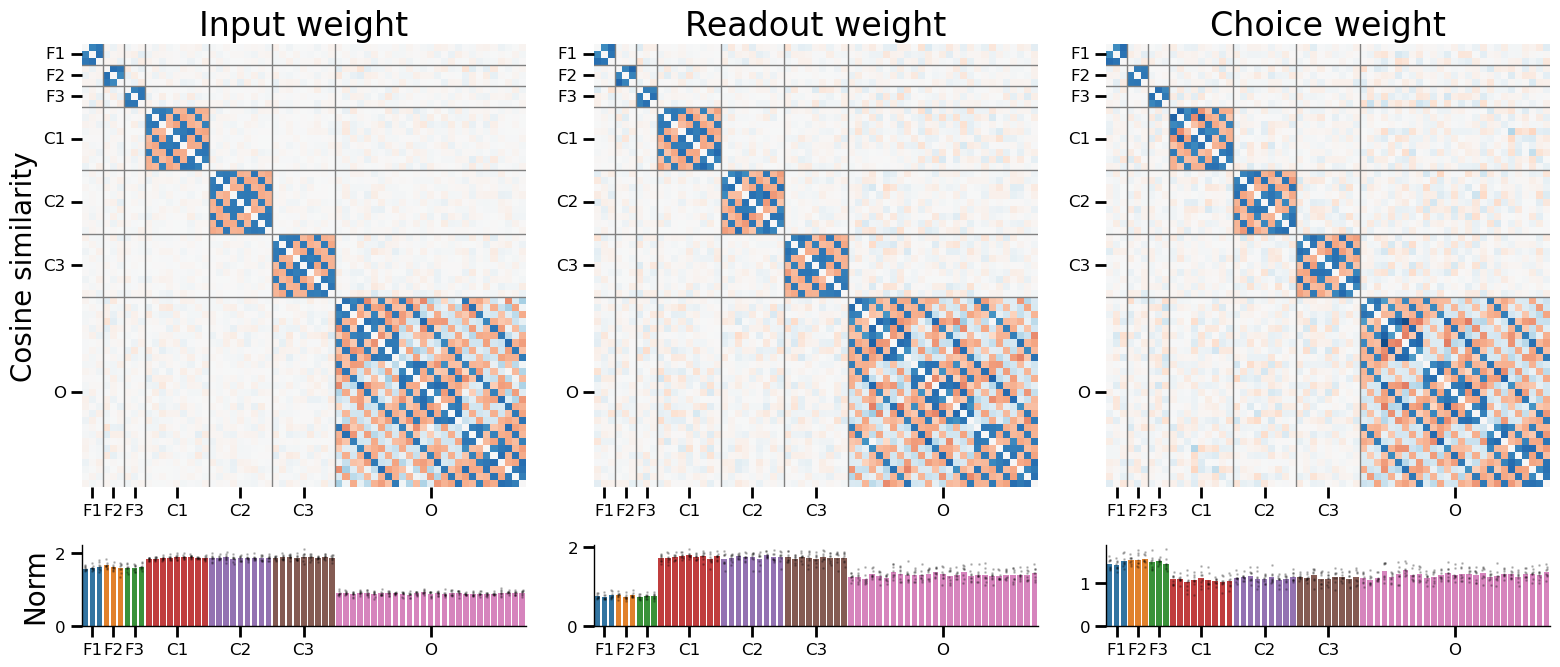

Figure saved at plots/fp_approx/weight_psth_geometry.pdf


In [280]:
def plot_psth_geometry(all_model_dpca, axes, title):
    all_model_dpca_psth = []
    dim_hue = [0]*3+[1]*3+[2]*3+[3]*9+[4]*9+[5]*9+[6]*27
    dim_hue = np.tile(np.array(dim_hue).reshape(1, 63), len(all_models)).flatten()
    for curr_model_dpca in all_model_dpca:
        curr_model_dpca_psth = np.concatenate([curr_model_dpca.marginalized_psth['s'].squeeze(), 
                                               curr_model_dpca.marginalized_psth['p'].squeeze(), 
                                               curr_model_dpca.marginalized_psth['c'].squeeze(), 
                                               curr_model_dpca.marginalized_psth['pc'].squeeze().reshape((args['hidden_size'], 9)), 
                                               curr_model_dpca.marginalized_psth['sc'].squeeze().reshape((args['hidden_size'], 9)), 
                                               curr_model_dpca.marginalized_psth['sp'].squeeze().reshape((args['hidden_size'], 9)), 
                                               curr_model_dpca.marginalized_psth['spc'].squeeze().reshape((args['hidden_size'], 27))], 
                                               axis=1)

        all_model_dpca_psth.append(curr_model_dpca_psth.T)
        
    all_model_dpca_psth = np.stack(all_model_dpca_psth)
    
    cmap_scale = 0.7
    
    sns.heatmap(batch_cosine_similarity(all_model_dpca_psth, all_model_dpca_psth).mean(0)-np.eye(63), 
                cmap='RdBu_r', vmin=-cmap_scale, vmax=cmap_scale, ax=axes[0], square=True, cbar=False,
                annot_kws={'fontdict':{'fontsize':10}}, cbar_kws={"shrink": 0.8})
    axes[0].set_title(title)
    
    block_boundaries = [3, 6, 9, 18, 27, 36]
    ticks = [1.5, 4.5, 7.5, 13.5, 22.5, 31.5, 49.5]
    labels = ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O']
    
    for bb in block_boundaries:
        axes[0].axvline(x=bb,color='grey',lw=1)
        axes[0].axhline(y=bb,color='grey',lw=1)
    axes[0].set_xticks(ticks)
    axes[0].set_xticklabels(labels, fontsize=12, rotation=0)
    axes[0].set_yticks(ticks)
    axes[0].set_yticklabels(labels, fontsize=12)

    xxx_for_plot = np.tile(np.arange(63).reshape(1, 63), len(all_models)).flatten()

    sns.stripplot(ax=axes[1], x=xxx_for_plot, y=np.linalg.norm(all_model_dpca_psth, axis=2).flatten(), 
                  color='k', linewidth=1, size=1, legend=False, alpha=0.2)
    sns.barplot(ax=axes[1], x=xxx_for_plot, y=np.linalg.norm(all_model_dpca_psth, axis=2).flatten(), 
                hue=dim_hue, errorbar=None, palette='tab10', legend=False)
    axes[1].set_xticks(np.array(ticks)-0.5)
    axes[1].set_xticklabels(labels, fontsize=12, rotation=0)
    axes[1].tick_params(axis='y', labelsize=12)
    
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    

fig, axes = plt.subplots(2,3, figsize=(16, 7), height_ratios=(6,1))

plot_psth_geometry(all_model_dpca_in, axes[:,0], "Input weight")
plot_psth_geometry(all_model_dpca_out, axes[:,1], "Readout weight")
plot_psth_geometry(all_model_dpca_ch, axes[:,2], "Choice weight")

axes[0,0].set_ylabel('Cosine similarity')
axes[1,0].set_ylabel('Norm')

plt.tight_layout()
plt.show()

with PdfPages(f'plots/{plot_save_dir}/weight_psth_geometry.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/weight_psth_geometry.pdf')


Figure saved at plots/fp_approx/input_output_weight_variance.pdf


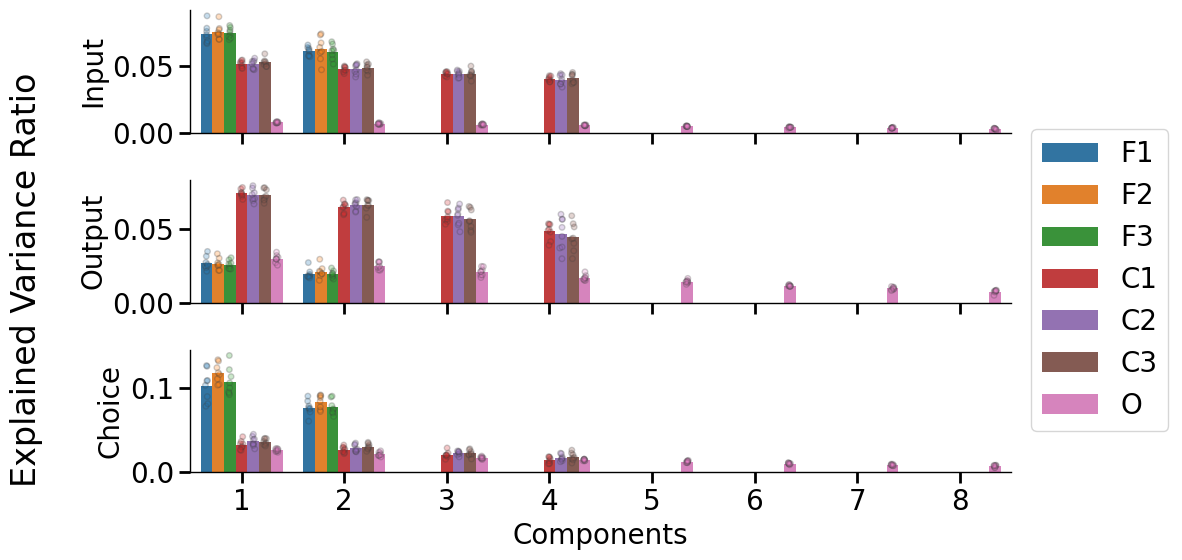

In [281]:
fig, axes = plt.subplots(3,1, figsize=(12,6))

def plot_weight_exp_vars(n_components_for_dpca, all_model_dpca, axes, ylabel):
    
    bar_width = 0.1

    key_plot_order = ['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']
    
    xxx_for_plot = np.tile(np.arange(8).reshape(1,1,8), [len(all_model_dpca),7,1])
    hue_for_plot = np.tile(np.arange(7).reshape(1,7,1), [len(all_model_dpca),1,8])

    all_model_dpca_exp_var = []
    
    for curr_model_dpca in all_model_dpca:
        all_dpca_exp_var = np.zeros((7, 8))
        for k_idx, k in enumerate(key_plot_order):
            all_dpca_exp_var[k_idx][...,:n_components_for_dpca[k]] = \
                np.array(curr_model_dpca.explained_variance_ratio_[k])
        all_model_dpca_exp_var.append(all_dpca_exp_var)
            
    all_model_dpca_exp_var = np.stack(all_model_dpca_exp_var)
    all_model_dpca_exp_var[all_model_dpca_exp_var<1e-6] = np.nan
    
    sns.stripplot(ax=axes, x=xxx_for_plot.flatten(), y=all_model_dpca_exp_var.flatten(),
                  hue=hue_for_plot.flatten(), palette='tab10', size=4,
                  legend=False, linewidth=1, dodge=True, alpha=0.25)
    bb = sns.barplot(ax=axes, x=xxx_for_plot.flatten(), y=all_model_dpca_exp_var.flatten(),
                 hue=hue_for_plot.flatten(), palette='tab10', dodge=True, errorbar=None)
    bb.legend_.remove()
    
    axes.set_xticks(np.arange(0,8,1))
    axes.set_xticklabels([])
#     axes.set_ylim(-0.01, axes.get_ylim()[1]+0.01)
    axes.set_ylabel(ylabel)
    
    

plot_weight_exp_vars(n_components_for_dpca, all_model_dpca_in, axes[0], "Input")
plot_weight_exp_vars(n_components_for_dpca, all_model_dpca_out, axes[1], "Output")
plot_weight_exp_vars(n_components_for_dpca, all_model_dpca_ch, axes[2], "Choice")

labels = ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O']

axes[2].set_xlabel('Components')
axes[2].set_xticklabels(np.arange(1,9,1))
fig.supylabel('Explained Variance Ratio')
plt.tight_layout()
handles, _ = axes[0].get_legend_handles_labels()

for ax in axes:
    box = ax.get_position()
    # axes[0].text(5, 8, rf'$R^2$ = {100*np.round(np.sum([np.sum(v) for v in dpca_in.explained_variance_ratio_.values()]))}%')
    ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])

fig.legend(handles, labels, loc='center right')
sns.despine()
fig.show()

with PdfPages(f'plots/{plot_save_dir}/input_output_weight_variance.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/input_output_weight_variance.pdf')


Figure saved at plots/exp/test1/out_ch_overlap.pdf


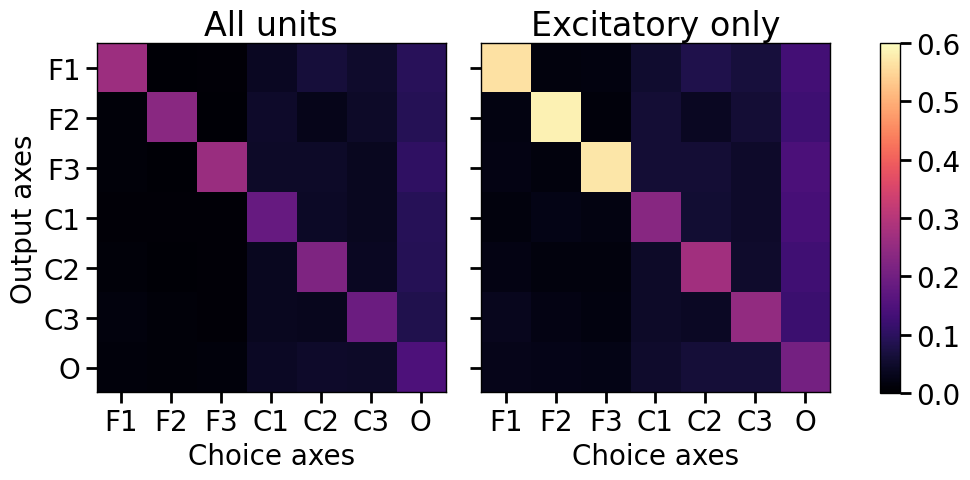

In [282]:
all_model_output_choice_overlap = []

fig, axes = plt.subplots(1, 2, sharey=True)

for idx_model in range(len(all_models)):
    stim_outcome_overlap = np.nan*np.empty((7,7))
    stim_outcome_overlap_exc = np.nan*np.empty((7,7))
#     stim_outcome_overlap = get_dpca_axes_overlap(all_model_dpca_out[idx_model].P, all_model_dpca_ch[idx_model].P,
#                                                  row_keys=['s','p','c','pc','sc','sp','spc'], 
#                                                  col_keys=['s','p','c','pc','sc','sp','spc'])
    for k_out_idx, k_out in enumerate(['s','p','c','pc','sc','sp','spc']):
        for k_ch_idx, k_ch in enumerate(['s','p','c','pc','sc','sp','spc']):
            stim_outcome_overlap[k_out_idx, k_ch_idx] = \
                np.sum((all_model_dpca_out[idx_model].P[k_out].T@
                        all_model_dpca_ch[idx_model].P[k_ch])**2)/\
                    all_model_dpca_out[idx_model].P[k_out].shape[1]
            stim_outcome_overlap_exc[k_out_idx, k_ch_idx] = \
                np.sum((all_model_dpca_out[idx_model].P[k_out][:E_SIZE].T@
                        all_model_dpca_ch_exc[idx_model].P[k_ch])**2)/\
                    all_model_dpca_out[idx_model].P[k_out].shape[1]

    all_model_output_choice_overlap.append(
        np.stack([stim_outcome_overlap, stim_outcome_overlap_exc]))
all_model_output_choice_overlap = np.stack(all_model_output_choice_overlap)

cmap_scale = 0.6
cm = axes[0].imshow(all_model_output_choice_overlap.mean(0)[0], vmin=0, vmax=cmap_scale, cmap='magma')  
axes[0].set_xticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
axes[0].set_yticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
axes[0].set_xlabel("Choice axes")
axes[0].set_ylabel("Output axes")
axes[0].set_title('All units')

cmap_scale = 0.6
cm = axes[1].imshow(all_model_output_choice_overlap.mean(0)[1], vmin=0, vmax=cmap_scale, cmap='magma')  
axes[1].set_xticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
axes[1].set_yticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
axes[1].set_xlabel("Choice axes")
axes[1].set_title('Excitatory only')

fig.tight_layout()
fig.subplots_adjust(bottom=0.05, right=0.85, top=0.95)
cb_ax = fig.add_axes([0.9, 0.25, 0.02, 0.5])
fig.colorbar(cm, cax=cb_ax)

with PdfPages(f'plots/{plot_save_dir}/out_ch_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/out_ch_overlap.pdf')

          
'''
use QR decomp to get choice feedback specific subspace: 
will not affect following decision even if reinstated
'''

all_model_choice_specific_axes = []

for idx_model in range(len(all_models)):
    curr_model_choice_specific_axes = []
    for k_out_idx, k_out in enumerate(['s','p','c','pc','sc','sp','spc']):
        out_ch_cat = np.concatenate([all_model_dpca_out[idx_model].P[k_out], 
                        all_model_dpca_ch[idx_model].P[k_out]], axis=-1)
        ortho_axes, _ = np.linalg.qr(out_ch_cat)
        curr_model_choice_specific_axes.append(ortho_axes[:,n_components_for_dpca[k_out]:])
    curr_model_choice_specific_axes = np.concatenate(curr_model_choice_specific_axes, axis=-1)
    all_model_choice_specific_axes.append(curr_model_choice_specific_axes)

all_model_choice_specific_axes = np.stack(all_model_choice_specific_axes)

          


0 out of 2208 comparisons were significant
0 out of 2208 comparisons were significant
3 out of 2208 comparisons were significant
Figure saved at plots/fp_approx/fixed_weight_axis_overlap.pdf


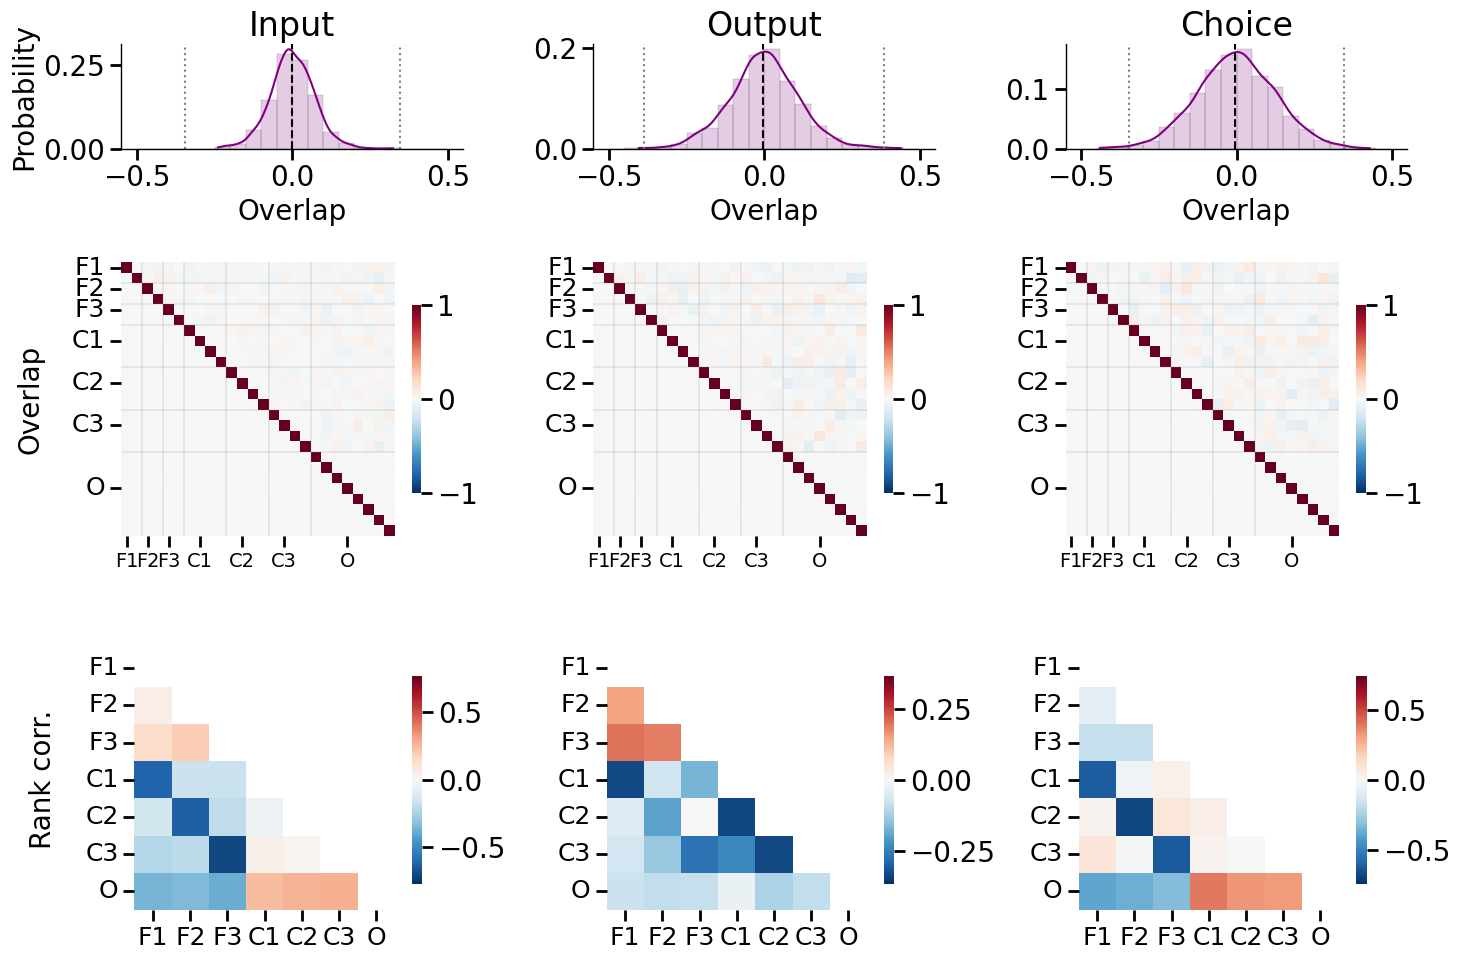

In [283]:
from statsmodels.stats.multitest import fdrcorrection

def test_dpca_overlap(all_dpca_results, keys, all_low_hs, overlap_scale, label, axes):
    
    all_model_axes_overlap = []
    all_model_flat_overlap = []
    all_model_low_hs_corr_val = []
    all_model_pvals = []
    all_model_axes = []
    
    all_model_exp_var_corr = []
    
    for dpca_result, low_hs in zip(all_dpca_results, all_low_hs):
        all_dpca_axes = np.concatenate([dpca_result.P[k] for k in keys], axis=1) # concat all axes
        all_dpca_low_hs = np.concatenate([low_hs[k].reshape((low_hs[k].shape[0],-1)) 
                                          for k in keys], axis=0) # concat all axes
        low_hs_corr_val = np.corrcoef(all_dpca_low_hs)
        axes_overlap = all_dpca_axes.T@all_dpca_axes # dot product similarity
        # axes_corr_val, axes_corr_ps = spearmanr(all_dpca_axes, axis=0) # rank correlation similarity
        all_overlaps = []
        all_pvals = []
        all_exp_var_corr = np.empty((7,7))*np.nan
        sig_thresh = np.abs(norm.ppf(0.001))*overlap_scale

        
        for k_idx1 in range(len(keys)):
            for k_idx2 in range(k_idx1+1, len(keys)):
                pair_overlaps = (dpca_result.P[keys[k_idx1]].T@dpca_result.P[keys[k_idx2]]).flatten()
                all_overlaps.append(pair_overlaps)
                all_pvals.append(norm.cdf(-np.abs(pair_overlaps), loc=0, scale=overlap_scale)+ \
                    norm.sf(np.abs(pair_overlaps), loc=0, scale=overlap_scale))
                
                all_exp_var_corr[k_idx1, k_idx2] = stats.spearmanr(
                    np.sum(dpca_result.unitwise_explained_variance_ratio_[keys[k_idx1]], 0),
                    np.sum(dpca_result.unitwise_explained_variance_ratio_[keys[k_idx2]], 0),
                    nan_policy='omit').statistic

        all_overlaps = np.concatenate(all_overlaps)
        all_pvals = np.concatenate(all_pvals)
        _, all_corrected_pvals = fdrcorrection(all_pvals)

        all_model_axes.append(all_dpca_axes)
        all_model_axes_overlap.append(axes_overlap)
        all_model_pvals.append(all_corrected_pvals)
        all_model_flat_overlap.append(all_overlaps)
        all_model_low_hs_corr_val.append(low_hs_corr_val)
        all_model_exp_var_corr.append(all_exp_var_corr)
        
    all_model_axes = np.stack(all_model_axes)
    all_model_axes_overlap = np.stack(all_model_axes_overlap)
    all_model_pvals = np.stack(all_model_pvals)
    all_model_flat_overlap = np.stack(all_model_flat_overlap)
    all_model_low_hs_corr_val = np.stack(all_model_low_hs_corr_val)
    all_model_exp_var_corr = np.stack(all_model_exp_var_corr)
        
    tril_mask = np.zeros_like(all_model_axes_overlap.mean(0))
    tril_mask[np.tril_indices(axes_overlap.shape[0], k=-1)] = 1

    triu_mask = np.zeros_like(all_model_axes_overlap.mean(0))
    triu_mask[np.triu_indices(axes_overlap.shape[0], k=0)] = 1
    
    # plot overlap values
    im = sns.heatmap(all_model_axes_overlap.mean(0)*triu_mask+\
                   all_model_low_hs_corr_val.mean(0)*tril_mask, \
                   cmap='RdBu_r', vmin=-1, vmax=1, ax=axes[1], square=True,
                    annot_kws={'fontdict':{'fontsize':10}}, cbar_kws={"shrink": 0.6})
    
    txs, tys = np.meshgrid(np.arange(axes_overlap.shape[0]),np.arange(axes_overlap.shape[0]))
    txs = txs[(np.abs(all_model_axes_overlap.mean(0))>sig_thresh)]
    tys = tys[(np.abs(all_model_axes_overlap.mean(0))>sig_thresh)]
    
    block_boundaries = np.cumsum(list(n_components_for_dpca.values()))[:-1]
    for i in block_boundaries:
        axes[1].axvline(x=i,color='grey',linewidth=0.2)
        axes[1].axhline(y=i,color='grey',linewidth=0.2)
        
    tick_locs = np.cumsum([0, *n_components_for_dpca.values()])[:-1]+\
                np.array(list(n_components_for_dpca.values()))//2-0.5

    axes[1].set_xticks(tick_locs, ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=14, rotation=0)
    axes[1].set_yticks(tick_locs, ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=18)
    
    for (x,y) in zip(txs, tys):
        if x<=y:
            continue
        else:
            axes[0].text(x-0.4, y+0.7, '*', {'size': 16})
    
    sns.histplot(x=all_model_flat_overlap.flatten(), color='purple', ax=axes[0], stat='probability', 
                 kde=True, bins=np.linspace(-0.5,0.5,21), linewidth=0.1, alpha=0.2)
    axes[0].set_xlabel('Overlap')
    axes[0].axvline(sig_thresh, color='grey', linestyle=':')
    axes[0].axvline(all_overlaps.mean(), color='black', linestyle='--')
    axes[0].axvline(-sig_thresh, color='grey', linestyle=':')
    
    
    axes[0].set_title(label, fontsize=24)
    
    axes[0].spines[['right', 'top']].set_visible(False)
    
    print(f"{(all_model_pvals.flatten()<0.05).sum()} out of {np.prod(all_model_pvals.shape)} comparisons were significant")
    
    cmap_scale = np.nanmax(np.abs(all_model_exp_var_corr.mean(0)))*1.1
    
    sns.heatmap(all_model_exp_var_corr.mean(0).T, \
                   cmap='RdBu_r', vmin=-cmap_scale, vmax=cmap_scale, ax=axes[2], square=True,
                    annot_kws={'fontdict':{'fontsize':12}}, cbar_kws={"shrink": 0.8})
    
    axes[2].set_xticks(np.arange(7)+0.5, ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=18)
    axes[2].set_yticks(np.arange(7)+0.5, ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=18, rotation=0)
    
    
    return all_model_axes
    
    
fig, axes = plt.subplots(3, 3, height_ratios=(1, 3, 2.5), figsize=(15, 10))
    
all_model_dpca_axes_in = test_dpca_overlap(all_model_dpca_in, ['s','p','c','pc','sc','sp','spc'], 
                              all_model_low_input, 1/np.sqrt(args['hidden_size']), 
                              "Input", axes[:,0])
all_model_dpca_axes_out = test_dpca_overlap(all_model_dpca_out, ['s','p','c','pc','sc','sp','spc'], 
                              all_model_low_output, 1/np.sqrt(int(args['hidden_size']*args['e_prop'])), 
                              "Output", axes[:,1])
all_model_dpca_axes_ch = test_dpca_overlap(all_model_dpca_ch, ['s','p','c','pc','sc','sp','spc'], 
                              all_model_low_ch, 1/np.sqrt(args['hidden_size']), 
                              "Choice", axes[:,2])
axes[0,1].set_ylabel(" ")
axes[0,2].set_ylabel(" ")
axes[1,0].set_ylabel('Overlap', labelpad=20)
axes[2,0].set_ylabel("Rank corr.", labelpad=20)

plt.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/fixed_weight_axis_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/fixed_weight_axis_overlap.pdf')

Figure saved at plots/fp_approx/dpca_weight_distribution.pdf


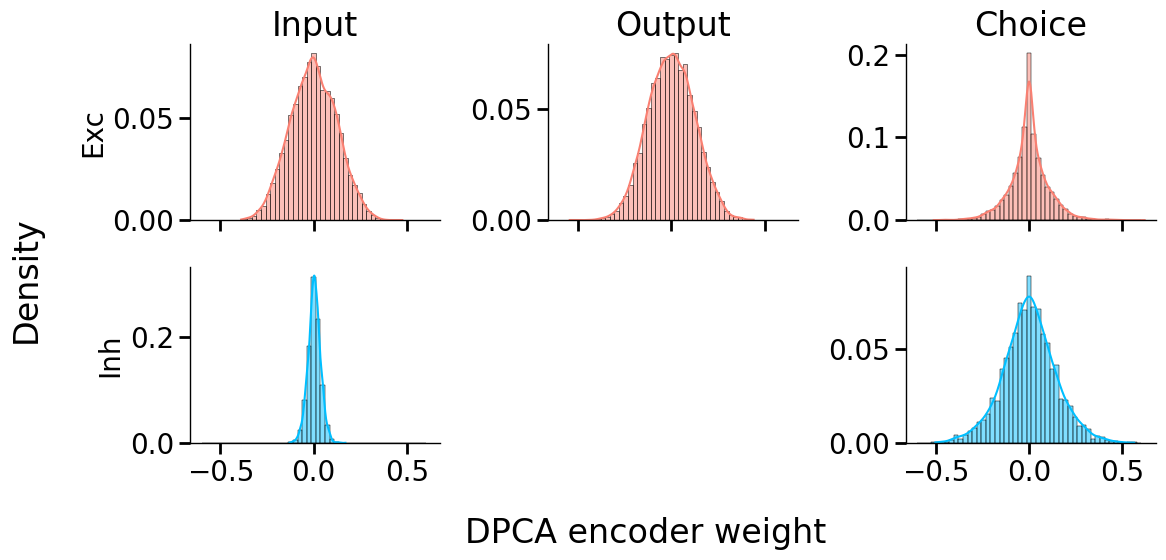

In [284]:
fig, axes = plt.subplots(2,3, sharex=True, figsize=(12, 6))


bin_edges = 0.6

sns.histplot(x=all_model_dpca_axes_in[:,:E_SIZE,:].flatten(), stat='probability', 
             kde=True, ax=axes[0,0], color='salmon', bins=np.linspace(-bin_edges, bin_edges))
axes[0,0].set_title('Input')
sns.histplot(x=all_model_dpca_axes_out[:,:E_SIZE,:].flatten(), stat='probability', 
             kde=True, ax=axes[0,1], color='salmon', bins=np.linspace(-bin_edges, bin_edges))
axes[0,1].set_title('Output')
sns.histplot(x=all_model_dpca_axes_ch[:,:E_SIZE,:].flatten(), stat='probability', 
             kde=True, ax=axes[0,2], color='salmon', bins=np.linspace(-bin_edges, bin_edges))
axes[0,2].set_title('Choice')

sns.histplot(x=all_model_dpca_axes_in[:,E_SIZE:,:].flatten(), stat='probability', 
             kde=True, ax=axes[1,0], color='deepskyblue', bins=np.linspace(-bin_edges, bin_edges))
axes[1,1].remove()
sns.histplot(x=all_model_dpca_axes_ch[:,E_SIZE:,:].flatten(), stat='probability', 
             kde=True, ax=axes[1,2], color='deepskyblue', bins=np.linspace(-bin_edges, bin_edges))

fig.supxlabel('DPCA encoder weight', y=0.05, x=0.55)
fig.supylabel('Density')

for i in range(2):
    for j in range(3):
        axes[i,j].set_ylabel("")
axes[0,0].set_ylabel('Exc')
axes[1,0].set_ylabel('Inh')

sns.despine()
plt.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/dpca_weight_distribution.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/dpca_weight_distribution.pdf')

# Analysis of Naive Weights of RNN

MannwhitneyuResult(statistic=1066412.0, pvalue=2.982037299162472e-125)
MannwhitneyuResult(statistic=1047561.0, pvalue=1.4400900885414598e-116)
MannwhitneyuResult(statistic=837046.0, pvalue=4.817609859234182e-41)
Figure saved at plots/fp_approx/recurrent_transform_overlap.pdf


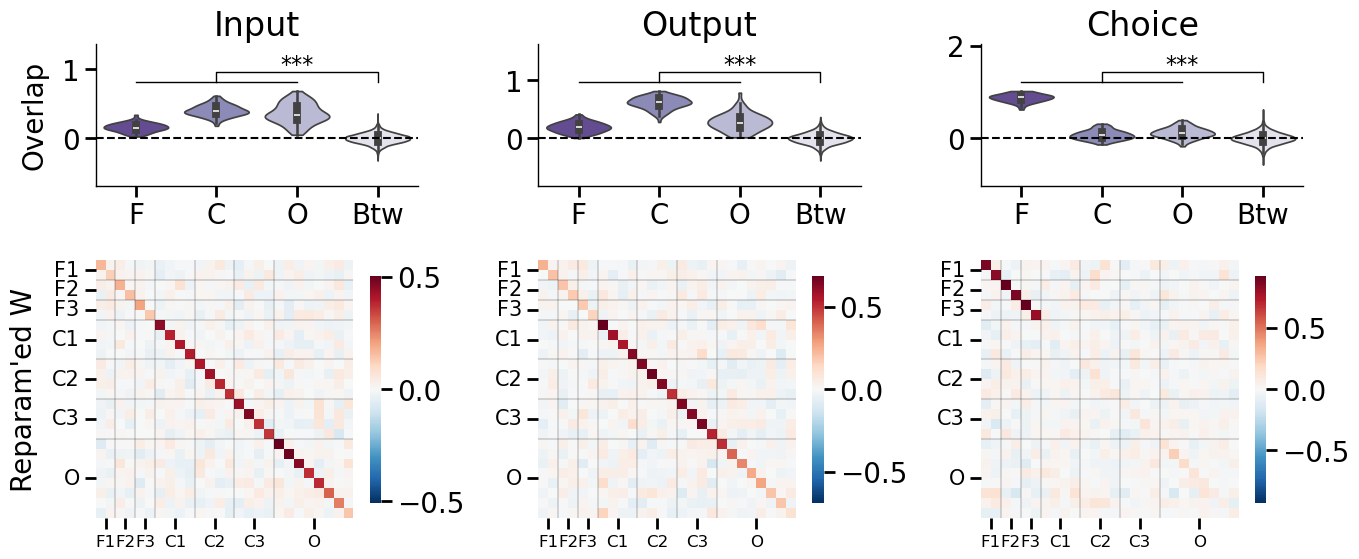

In [285]:
def plot_recurrence(all_model_dpca_axes, all_model_rec_intra, axes, title):
    all_model_rec_overlap = []
    all_model_overlap_within = []
    all_model_overlap_between = []
    for (all_dpca_axes, rec_intra) in zip(all_model_dpca_axes, all_model_rec_intra):
        num_components = all_dpca_axes.shape[1]
        rec_current = rec_intra.detach().numpy()@all_dpca_axes
#         rec_current = rec_current/np.linalg.norm(rec_current, axis=0)
        rec_overlap = all_dpca_axes.T@rec_current
        all_model_rec_overlap.append(rec_overlap)
        all_model_overlap_within.append(np.diag(rec_overlap))
        all_model_overlap_between.append(rec_overlap[np.where(~np.eye(num_components,dtype=bool))])
        
    all_model_rec_overlap = np.stack(all_model_rec_overlap)
    all_model_overlap_within = np.stack(all_model_overlap_within)
    all_model_overlap_between = np.stack(all_model_overlap_between)
        
    cmap_scale = all_model_rec_overlap.mean(0).max()*1
    
    sns.heatmap(all_model_rec_overlap.mean(0), ax=axes[1], vmin=-cmap_scale, vmax=cmap_scale, cmap='RdBu_r', 
                     square=True, annot_kws={'fontdict':{'fontsize':10}}, cbar_kws={"shrink": 0.8})
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    cmap_scale = all_model_rec_overlap.max()*1
    violin_xxx = ['F']*(len(all_model_rec_intra)*6)\
                +['C']*(len(all_model_rec_intra)*12)\
                +['O']*(len(all_model_rec_intra)*8)\
                +['Btw']*np.prod(all_model_overlap_between.shape).astype(int)
    sns.violinplot(ax=axes[0], 
        x=violin_xxx, hue=violin_xxx,         
        y=np.concatenate([all_model_overlap_within[:,:6].flatten(), 
                          all_model_overlap_within[:,6:18].flatten(), 
                          all_model_overlap_within[:,18:27].flatten(), 
                          all_model_overlap_between.flatten()]),
        palette=sns.color_palette('Purples_r', 4), cut=0, legend=False)
    
    temp_stats = stats.mannwhitneyu(all_model_overlap_within.flatten(), all_model_overlap_between.flatten())
    
    
    axes[0].axhline(0, linestyle='--', color='k')
    axes[0].set_xlim([-0.5, 3.5])
    axes[0].set_ylim([-cmap_scale, cmap_scale*(2.0)])
    axes[0].set_ylabel("")
    axes[0].set_title(title)
    print(temp_stats)
    
    axes[0].plot([1, 1, 3, 3], [cmap_scale*1.2, cmap_scale*1.4, cmap_scale*1.4, cmap_scale*1.2], lw=1, c='k')
    axes[0].plot([0, 2], [cmap_scale*1.2, cmap_scale*1.2], lw=1, c='k')
    axes[0].text(2, cmap_scale*1.3, convert_pvalue_to_asterisks(temp_stats.pvalue), 
                 ha='center', va='bottom', c='k', fontsize=16)
    
    sns.despine(ax=axes[0])
    

fig, axes = plt.subplots(2,3, figsize=(14, 6), height_ratios=[1, 2])


plot_recurrence(all_model_dpca_axes_in, [rec_intra[0] for rec_intra in all_model_rec_intra], 
                axes[:,0], "Input")
plot_recurrence(all_model_dpca_axes_out, [rec_intra[1] for rec_intra in all_model_rec_intra], 
                axes[:,1], "Output")
plot_recurrence(all_model_dpca_axes_ch, [rec_intra[1] for rec_intra in all_model_rec_intra], 
                axes[:,2], "Choice")


axes[0,0].set_ylabel('Overlap', labelpad=10)
axes[1,0].set_ylabel('Reparam\'ed W', labelpad=10)

for j in range(3):
    block_boundaries = np.cumsum(list(n_components_for_dpca.values()))[:-1]
    for i in block_boundaries:
        axes[1,j].axvline(x=i,color='k',linewidth=0.2)
        axes[1,j].axhline(y=i,color='k',linewidth=0.2)
    tick_locs = np.cumsum([0, *n_components_for_dpca.values()])[:-1]+np.array(list(n_components_for_dpca.values()))//2
    axes[1,j].set_xticks(tick_locs, ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=12, rotation=0)
    axes[1,j].set_yticks(tick_locs, ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=15)

fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/recurrent_transform_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/recurrent_transform_overlap.pdf')


MannwhitneyuResult(statistic=18816.0, pvalue=4.305662119479704e-33)
MannwhitneyuResult(statistic=18816.0, pvalue=4.305662119479704e-33)
MannwhitneyuResult(statistic=17950.0, pvalue=1.4215157630338485e-27)
Figure saved at plots/fp_approx/interareal_transform_overlap.pdf


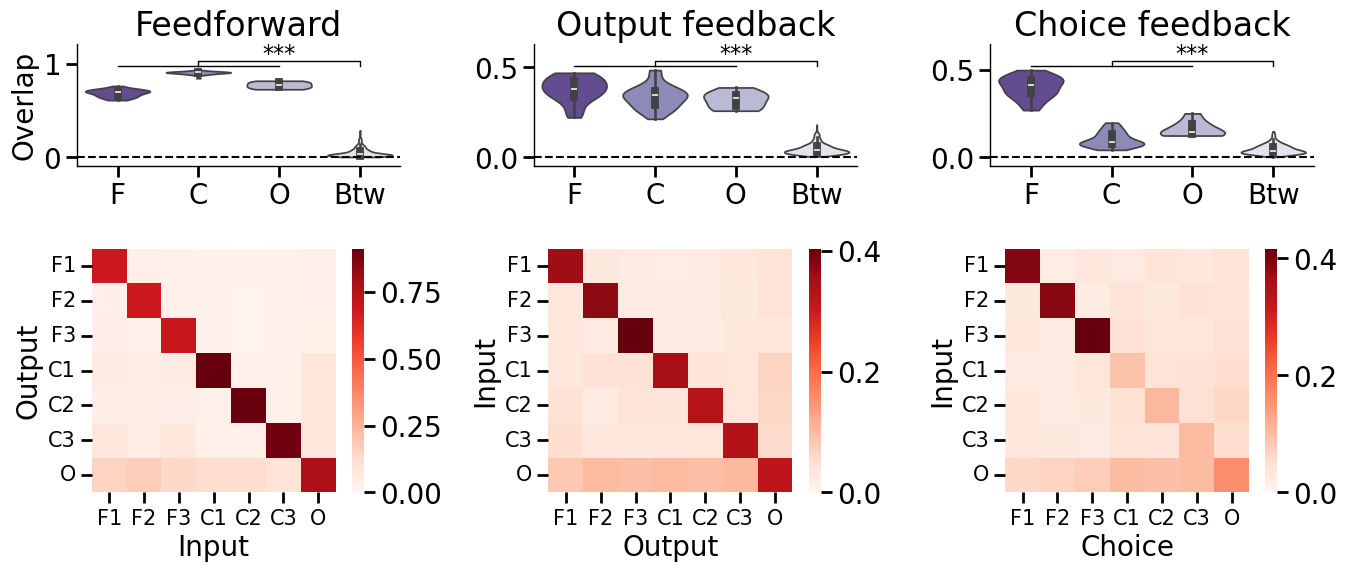

In [286]:
fig, axes = plt.subplots(2, 3, figsize=(14,6), height_ratios=(1,2))

def plot_ff_fb(all_model_dpca_pre, all_model_dpca_post, all_model_rec_inter, 
               axes, title, pre_label, post_label):

    all_model_explained_vars = []
    all_model_vars_within = []
    all_model_vars_between = []
    
    for (dpca_pre, dpca_post, rec_inter) in zip(all_model_dpca_pre, all_model_dpca_post, all_model_rec_inter):
        
        explained_vars = np.zeros((7,7))

        for k_in_idx, k_in in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
            currents = rec_inter.detach().numpy()@dpca_pre.P[k_in]
#             currents -= currents.mean(0, keepdims=True)
            for k_out_idx, k_out in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
                explained_vars[k_out_idx][k_in_idx] = \
                    np.sum((dpca_post.P[k_out].T@currents)**2)/np.sum(currents**2)
#                 explained_vars[k_out_idx][k_in_idx] = np.sum((dpca_post.P[k_out].T@currents)**2)/dpca_post.P[k_out].shape[1]

        all_model_explained_vars.append(explained_vars)
        all_model_vars_within.append(np.diag(explained_vars))
        all_model_vars_between.append(explained_vars[np.where(~np.eye(7, dtype=bool))])
        
    all_model_explained_vars = np.stack(all_model_explained_vars)
    all_model_vars_within = np.stack(all_model_vars_within)
    all_model_vars_between = np.stack(all_model_vars_between)
    
    cmap_scale = all_model_explained_vars.mean(0).max()*1
    
    cm = sns.heatmap(all_model_explained_vars.mean(0), ax=axes[1], vmin=0, vmax=None, cmap='Reds', 
                     square=True, annot_kws={'fontdict':{'fontsize':10}}, cbar_kws={"shrink": 1})
    axes[1].set_ylabel(post_label)
    axes[1].set_xlabel(pre_label)
    
    cmap_scale = all_model_explained_vars.max()*1
    violinplot_xxx = ['F']*(len(all_model_rec_inter)*3)\
                    +['C']*(len(all_model_rec_inter)*3)\
                    +['O']*(len(all_model_rec_inter))\
                    +['Btw']*np.prod(all_model_vars_between.shape).astype(int)
    sns.violinplot(ax=axes[0], 
        x=violinplot_xxx, hue=violinplot_xxx,
        y=np.concatenate([all_model_vars_within[:,:3].flatten(), 
                          all_model_vars_within[:,3:6].flatten(),
                          all_model_vars_within[:,6].flatten(),
                          all_model_vars_between.flatten()]),
        palette=sns.color_palette('Purples_r', 4), cut=0, legend=False)
    
    temp_stats = stats.mannwhitneyu(all_model_vars_within.flatten(), all_model_vars_between.flatten())
    
    
    axes[0].axhline(0, linestyle='--', color='k')
    axes[0].set_xlim([-0.5, 3.5])
    axes[0].set_ylim([-.1*cmap_scale, cmap_scale*1.3])
    axes[0].set_ylabel("")
    axes[0].set_title(title)
    print(temp_stats)
    
    unit_len = cmap_scale/10

    bar_bottom = cmap_scale+unit_len*0.5
    bar_top = cmap_scale+unit_len*1.

    axes[0].plot([1, 1, 3, 3], [bar_bottom, bar_top, bar_top, bar_bottom], lw=1, c='k')
    axes[0].plot([0, 2], [bar_bottom, bar_bottom], lw=1, c='k')
    axes[0].text(2, bar_bottom+unit_len/20, 
                 convert_pvalue_to_asterisks(temp_stats.pvalue), 
                 ha='center', va='bottom', c='k', fontsize=16)
    sns.despine(ax=axes[0])

    
plot_ff_fb(all_model_dpca_in, all_model_dpca_out, [rec_inter_ff[0] for rec_inter_ff in all_model_rec_inter_ff],
           axes[:,0], 'Feedforward', 'Input', 'Output')
plot_ff_fb(all_model_dpca_out, all_model_dpca_in, [rec_inter_fb[0] for rec_inter_fb in all_model_rec_inter_fb],
           axes[:,1], 'Output feedback', 'Output', 'Input')
plot_ff_fb(all_model_dpca_ch, all_model_dpca_in, [rec_inter_fb[0] for rec_inter_fb in all_model_rec_inter_fb],
           axes[:,2], 'Choice feedback', 'Choice', 'Input')

for i in range(3):
    axes[1,i].set_xticks(np.arange(0,7)+0.5)
    axes[1,i].set_xticklabels(["F1", "F2", "F3", "C1", "C2", "C3", "O"], fontsize=15)
    axes[1,i].set_yticks(np.arange(0,7)+0.5)
    axes[1,i].set_yticklabels(["F1", "F2", "F3", "C1", "C2", "C3", "O"], fontsize=15, rotation=0)

axes[0,0].set_ylabel('Overlap')
# axes[1,0].set_ylabel('Rotated Weights', labelpad=40)
fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/interareal_transform_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/interareal_transform_overlap.pdf')


MannwhitneyuResult(statistic=18701.0, pvalue=2.4952254045060266e-32)
MannwhitneyuResult(statistic=16206.0, pvalue=4.749087373532595e-18)
MannwhitneyuResult(statistic=15674.0, pvalue=1.4452442266525538e-15)


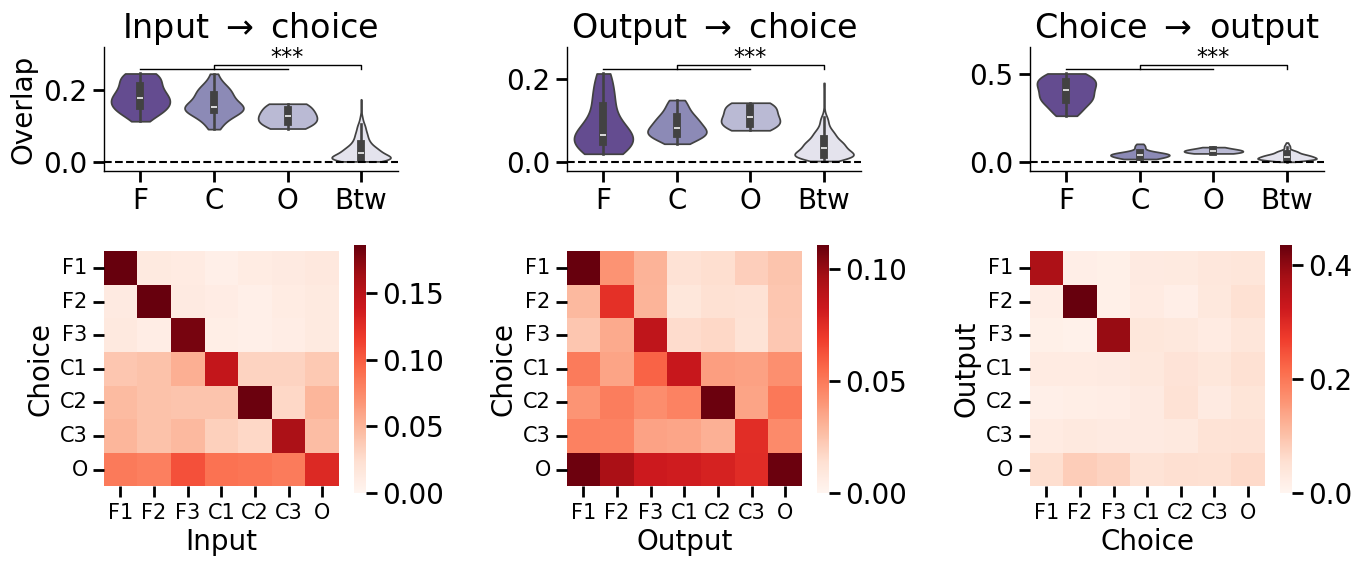

In [287]:
fig, axes = plt.subplots(2, 3, figsize=(14,6), height_ratios=(1,2))
    
plot_ff_fb(all_model_dpca_in, all_model_dpca_ch, [rec_inter_ff[0] for rec_inter_ff in all_model_rec_inter_ff],
           axes[:,0], r'Input $\to$ choice', 'Input', 'Choice')
plot_ff_fb(all_model_dpca_out, all_model_dpca_ch, [rec_intra[1] for rec_intra in all_model_rec_intra],
           axes[:,1], r'Output $\to$ choice', 'Output', 'Choice')
plot_ff_fb(all_model_dpca_ch, all_model_dpca_out, [rec_intra[1] for rec_intra in all_model_rec_intra],
           axes[:,2], r'Choice $\to$ output', 'Choice', 'Output')

for i in range(3):
    axes[1,i].set_xticks(np.arange(0,7)+0.5)
    axes[1,i].set_xticklabels(["F1", "F2", "F3", "C1", "C2", "C3", "O"], fontsize=15)
    axes[1,i].set_yticks(np.arange(0,7)+0.5)
    axes[1,i].set_yticklabels(["F1", "F2", "F3", "C1", "C2", "C3", "O"], fontsize=15, rotation=0)

axes[0,0].set_ylabel('Overlap')
# axes[1,0].set_ylabel('Rotated Weights', labelpad=40)
fig.tight_layout()

# with PdfPages(f'plots/{plot_save_dir}/interareal_transform_overlap.pdf') as pdf:
#     pdf.savefig(fig)
#     print(f'Figure saved at plots/{plot_save_dir}/interareal_transform_overlap.pdf')


# Analysis of learning rate matrix of the recurrent weights

8it [00:12,  1.56s/it]
8it [00:12,  1.57s/it]
8it [00:12,  1.57s/it]
8it [00:12,  1.56s/it]


Figure saved at plots/fp_approx/hebbian_learning_overlap.pdf


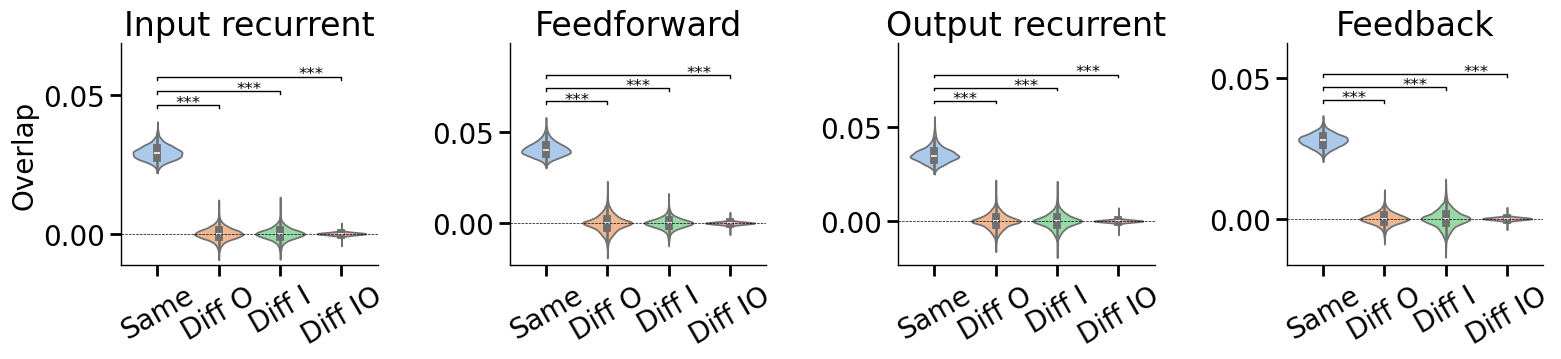

In [288]:
fig, axes = plt.subplots(1,4, figsize=(16, 4)) #, dpi=200


def plot_hebb_overlap(all_model_dpca_axes_pre_enc, all_model_dpca_axes_post_enc, 
                      all_model_dpca_axes_pre_rtv, all_model_dpca_axes_post_rtv, 
                      all_model_kappa_rec, 
                      axes, title):

    all_model_overlaps = {'same_pre_post': [], 'same_pre': [], 'same_post': [], 'diff': []}
            
    for all_dpca_axes_pre_enc, all_dpca_axes_post_enc, \
        all_dpca_axes_pre_rtv, all_dpca_axes_post_rtv, kappa_rec in \
            tqdm.tqdm(zip(all_model_dpca_axes_pre_enc, all_model_dpca_axes_post_enc, \
                all_model_dpca_axes_pre_rtv, all_model_dpca_axes_post_rtv, all_model_kappa_rec)):
        
        overlaps = {'same_pre_post': [], 'same_pre': [], 'same_post': [], 'diff': []}
        num_axis = all_dpca_axes_pre_enc.shape[1]
        
        for i in range(num_axis):
            for j in range(num_axis):
                # calculate hebbian memory
                mem_mat = kappa_rec.numpy()*(all_dpca_axes_post_enc[:,i:i+1]@all_dpca_axes_pre_enc[:,j:j+1].T)
                
                # calculate overlap between cued recall and ground truth
                for k in range(num_axis):
                    for l in range(num_axis):
                        curr_overlap = all_dpca_axes_post_rtv[:,k:k+1].T@mem_mat@all_dpca_axes_pre_rtv[:,l:l+1]
                        if i==k and j==l:
                            overlaps['same_pre_post'].append(curr_overlap)
                        elif j==l:
                            overlaps['same_pre'].append(curr_overlap)
                        elif i==k:
                            overlaps['same_post'].append(curr_overlap)
                        else:
                            overlaps['diff'].append(curr_overlap)
                            
        
        for k, v in overlaps.items():
            all_model_overlaps[k].append(v)
    
    for k, v in overlaps.items():
        all_model_overlaps[k] = np.stack(all_model_overlaps[k])
    
    cmap_scale_max = max([all_model_overlaps['same_pre_post'].max(),
                          all_model_overlaps['same_pre'].max(),
                          all_model_overlaps['same_post'].max(),
                          all_model_overlaps['diff'].max()])
    cmap_scale_min = min([all_model_overlaps['same_pre_post'].min(),
                          all_model_overlaps['same_pre'].min(),
                          all_model_overlaps['same_post'].min(),
                          all_model_overlaps['diff'].min()])
        
        
    sns.violinplot(ax=axes,
                  x=['Same']*np.prod(all_model_overlaps['same_pre_post'].shape)+\
                   ['Diff O']*np.prod(all_model_overlaps['same_pre'].shape)+
                   ['Diff I']*np.prod(all_model_overlaps['same_post'].shape)+\
                   ['Diff IO']*np.prod(all_model_overlaps['diff'].shape),
                  y=np.concatenate([all_model_overlaps['same_pre_post'].flatten(),
                                   all_model_overlaps['same_pre'].flatten(),
                                   all_model_overlaps['same_post'].flatten(),
                                   all_model_overlaps['diff'].flatten()]),
                   hue=['Same']*np.prod(all_model_overlaps['same_pre_post'].shape)+\
                   ['Diff O']*np.prod(all_model_overlaps['same_pre'].shape)+
                   ['Diff I']*np.prod(all_model_overlaps['same_post'].shape)+\
                   ['Diff IO']*np.prod(all_model_overlaps['diff'].shape),
                  palette=sns.color_palette('pastel', 4), cut=0, legend=False)
    
    axes.set_xticks(np.arange(4))
    axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    axes.axhline(0, linestyle = '--', color='k', linewidth=0.5)
    axes.set_title(title)
    axes.set_ylim([cmap_scale_min*1.2, cmap_scale_max*1.7])
    sns.despine(ax=axes)
    
    for key_idx, key in enumerate(['same_pre', 'same_post', 'diff']):
        temp_stats = stats.mannwhitneyu(all_model_overlaps['same_pre_post'].flatten(), 
                                        all_model_overlaps[key].flatten())
        
        unit_len = cmap_scale_max/8
        
        bar_bottom = cmap_scale_max+unit_len*(key_idx+1)
        bar_top = cmap_scale_max+unit_len*(key_idx+1.2)
        
        axes.plot([0, 0, key_idx+1, key_idx+1], 
                     [bar_bottom, bar_top, bar_top, bar_bottom], lw=1, c='k')
        axes.text(0.5+key_idx, bar_top*1.02, 
                     convert_pvalue_to_asterisks(temp_stats.pvalue), 
                     ha='center', va='center', c='k', fontsize=12)
    
    

plot_hebb_overlap(all_model_dpca_axes_in, all_model_dpca_axes_in, 
                  all_model_dpca_axes_in, all_model_dpca_axes_in, 
                  [kappa_rec_intra[0] for kappa_rec_intra in all_model_kappa_rec_intra],
                 axes[0], 'Input recurrent')

plot_hebb_overlap(all_model_dpca_axes_in, all_model_dpca_axes_out, 
                  all_model_dpca_axes_in, all_model_dpca_axes_out, 
                  [kappa_inter_ff[0] for kappa_inter_ff in all_model_kappa_inter_ff],
                 axes[1], 'Feedforward')

plot_hebb_overlap(all_model_dpca_axes_out, all_model_dpca_axes_out, 
                  all_model_dpca_axes_out, all_model_dpca_axes_out, 
                  [kappa_rec_intra[1] for kappa_rec_intra in all_model_kappa_rec_intra],
                 axes[2],'Output recurrent')

plot_hebb_overlap(all_model_dpca_axes_out, all_model_dpca_axes_in, 
                  all_model_dpca_axes_out, all_model_dpca_axes_in, 
                  [kappa_inter_fb[0] for kappa_inter_fb in all_model_kappa_inter_fb],
                 axes[3],'Feedback')


axes[0].set_ylabel('Overlap')
# axes[1,0].set_ylabel('Retrieval')
# fig.supxlabel('Encoding')

fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/hebbian_learning_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/hebbian_learning_overlap.pdf')


8it [00:14,  1.78s/it]
8it [00:14,  1.78s/it]


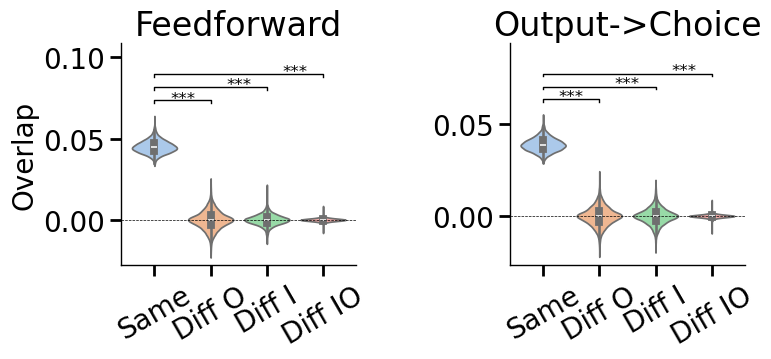

In [289]:
fig, axes = plt.subplots(1,2, figsize=(8, 4))


plot_hebb_overlap(all_model_dpca_axes_in, all_model_dpca_axes_ch, 
                  all_model_dpca_axes_in, all_model_dpca_axes_ch, 
                  [kappa_inter_ff[0] for kappa_inter_ff in all_model_kappa_inter_ff],
                 axes[0], 'Feedforward')

plot_hebb_overlap(all_model_dpca_axes_out, all_model_dpca_axes_ch, 
                  all_model_dpca_axes_out, all_model_dpca_axes_ch, 
                  [kappa_rec_intra[1] for kappa_rec_intra in all_model_kappa_rec_intra],
                 axes[1],'Output->Choice')


axes[0].set_ylabel('Overlap')
# axes[1,0].set_ylabel('Retrieval')
# fig.supxlabel('Encoding')

fig.tight_layout()


8it [00:12,  1.50s/it]
8it [00:14,  1.78s/it]
8it [00:14,  1.80s/it]


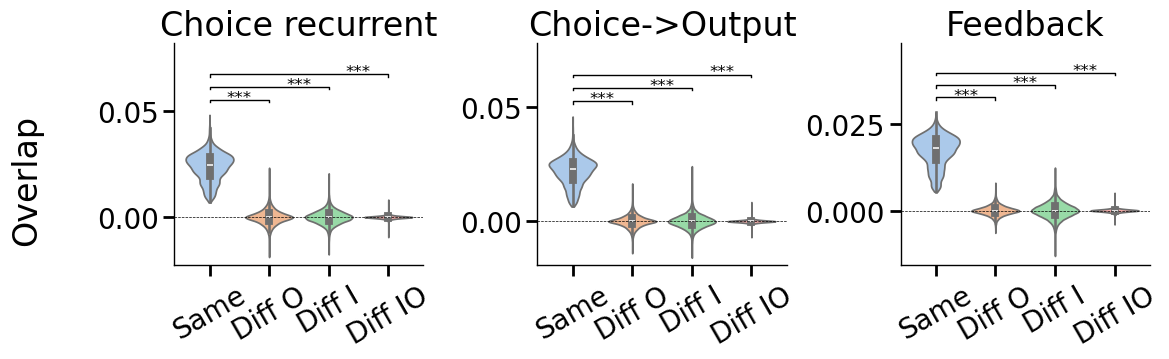

In [290]:
all_model_dpca_axes_ch_exc = [np.concatenate([dpca_result.P[k] for k in ['s','p','c','pc','sc','sp','spc']], axis=1) 
                              for dpca_result in all_model_dpca_ch_exc]
all_model_dpca_axes_ch_inh = [np.concatenate([dpca_result.P[k] for k in ['s','p','c','pc','sc','sp','spc']], axis=1) 
                              for dpca_result in all_model_dpca_ch_inh]

fig, axes = plt.subplots(1,3, figsize=(12, 4))


plot_hebb_overlap(all_model_dpca_axes_ch, all_model_dpca_axes_ch, 
                  all_model_dpca_axes_ch, all_model_dpca_axes_ch, 
                  [kappa_rec_intra[1] for kappa_rec_intra in all_model_kappa_rec_intra],
                 axes[0],'Choice recurrent')

# plot_hebb_overlap(all_model_dpca_axes_ch_inh, all_model_dpca_axes_ch, 
#                   all_model_dpca_axes_ch_inh, all_model_dpca_axes_ch, 
#                   [kappa_rec_intra[1][:,E_SIZE:] for kappa_rec_intra in all_model_kappa_rec_intra],
#                  axes[1,0],'Choice recurrent')

plot_hebb_overlap(all_model_dpca_axes_ch, all_model_dpca_axes_out, 
                  all_model_dpca_axes_ch, all_model_dpca_axes_out, 
                  [kappa_rec_intra[1] for kappa_rec_intra in all_model_kappa_rec_intra],
                 axes[1],'Choice->Output')

# plot_hebb_overlap(all_model_dpca_axes_ch_inh, all_model_dpca_axes_out, 
#                   all_model_dpca_axes_ch_inh, all_model_dpca_axes_out, 
#                   [kappa_rec_intra[1][:,E_SIZE:] for kappa_rec_intra in all_model_kappa_rec_intra],
#                  axes[1,1],'Choice->Output')

plot_hebb_overlap(all_model_dpca_axes_ch, all_model_dpca_axes_in, 
                  all_model_dpca_axes_ch, all_model_dpca_axes_in, 
                  [kappa_inter_fb[0] for kappa_inter_fb in all_model_kappa_inter_fb],
                 axes[2],'Feedback')

# axes[0,0].set_ylabel('Exc')
# axes[1,0].set_ylabel('Inh')
# axes[1,2].remove()

fig.supylabel('Overlap')

fig.tight_layout()


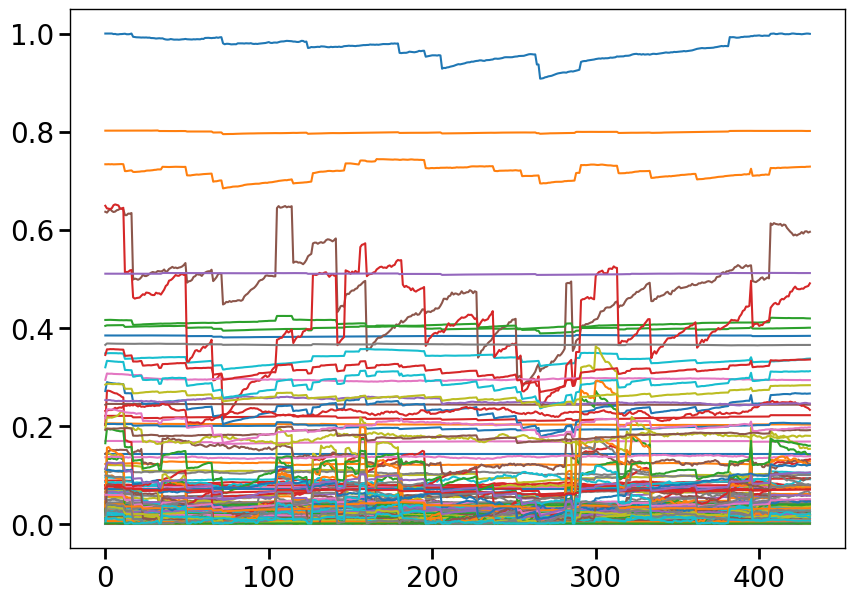

In [305]:
plt.plot(all_saved_states['whs'][:,0,np.random.randint(92),:,np.random.randint(128)]);

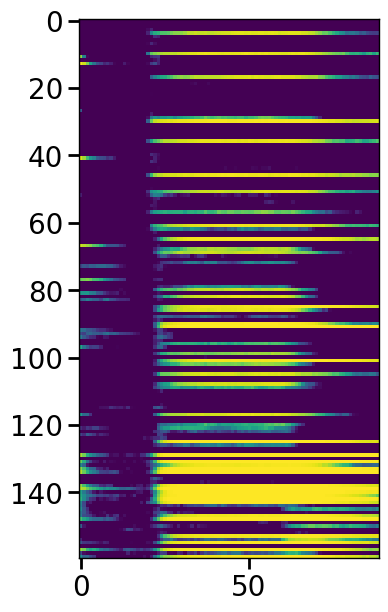

In [308]:
plt.imshow(all_saved_states['hs'][np.random.randint(432),:,np.random.randint(92),:].T);

## dPCA Analysis of the Activity of the RNN

In [62]:
def get_area_ei_indices(args, ind_area):
    hidden_size_per_area = args['hidden_size']
    E_SIZE = round(args['hidden_size']*args['e_prop'])
    I_SIZE = round(args['hidden_size']*(1-args['e_prop']))
    NUM_AREAS = args['num_areas']
    return np.concatenate([np.arange(E_SIZE*ind_area, E_SIZE*(ind_area+1)), 
                           np.arange(E_SIZE*NUM_AREAS+I_SIZE*ind_area, E_SIZE*NUM_AREAS+I_SIZE*(ind_area+1))])

def make_dpca_results(Xs, labels, n_components):
    all_non_time_labels = labels
    join_dict = {}
    for r in range(1, len(labels)+1):
        for label in list(itertools.combinations(all_non_time_labels, r)):
            label_str = ''.join(label)
            join_dict['t'+label_str] = [label_str, 't'+label_str]
#             print(join_dict)

    dpca_model = dPCA.dPCA('t'+labels, join=join_dict, n_components=n_components)
    low_hs = dpca_model.fit_transform(Xs)

    all_axes = []
    all_explained_vars = []
    all_labels = []
    for k in dpca_model.marginalized_psth.keys():
        eff_components = np.sum(np.array(dpca_model.explained_variance_ratio_[k])>0.00)
        all_explained_vars.append(dpca_model.explained_variance_ratio_[k][:eff_components])
#         print(f"Variance explained by {eff_components} of {k}: {np.round(100*np.array(dpca_model.explained_variance_ratio_[k]),4)} %")
        all_axes.append(dpca_model.P[k][:,:eff_components])
        all_labels += [k]*eff_components

    all_axes = np.concatenate(all_axes, axis=1)
    all_explained_vars = np.concatenate(all_explained_vars, axis=0)

    dpca_results = {}
    dpca_results['low_hs'] = low_hs
    dpca_results['encoding_axes'] = dpca_model.P
    dpca_results['explained_variances'] = dpca_model.explained_variance_ratio_
    dpca_results['marginalized_psth'] = dpca_model.marginalized_psth

    return dpca_results

def get_dpca_by_area(all_saved_states, task_mdprl, args, 
                     trials_to_fit, area_to_fit, model_to_fit):
    '''
    (1) regress hs activity with
            previous trial choice shape, color, pattern (3x3x3), 
            previous trial reward (2),
            current trial stimuli shape, color, pattern pairs (3x3x3), 
            current trial choice shape, color, pattern (3x3x3), 
            current trial reward (2),
    (2) get beta weights which is a mixture of value and stimulus intensity: h ~ Xw. 
        This will give beta weights timepoints X trials X hidden X latent variables,
        calculate cpd gives timepoints X trials X hidden X latent variables CPD values
    (3) compare w with marginal reward probability? see which it dimension it corresponds to the best
    '''
    
    n_trials, n_timesteps, n_sessions, n_hidden = all_saved_states['hs'].shape
    n_areas = args['num_areas'] 
    n_hidden = n_hidden//n_areas

    area_inds = get_area_ei_indices(args, area_to_fit)
    sessions_to_fit = all_saved_states['model_assignment'].astype(int)==model_to_fit
    num_sessions_to_fit = np.sum(sessions_to_fit)

    area_hs = all_saved_states['hs'][...,area_inds]
    num_trials_to_fit = len(trials_to_fit)

#     print("Calculating PSTH by prev trial")

    '''
    organize by previous trial outcome
    '''
    hs_by_prev = np.zeros((n_hidden, n_timesteps, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes
    
    flat_hs_post = area_hs.numpy()[trials_to_fit[1:],...][:,:,sessions_to_fit]\
                        .transpose((2,0,1,3)).reshape((num_sessions_to_fit*(num_trials_to_fit-1), n_timesteps, n_hidden))
    flat_rwds_pre = all_saved_states['rewards'].numpy()[trials_to_fit[:-1],...][:,:,sessions_to_fit]\
                        .transpose((2,0,1)).reshape((num_sessions_to_fit*(num_trials_to_fit-1))).astype(int)
    flat_acts_pre = all_saved_states['choices'].numpy()[trials_to_fit[:-1],...][:,:,sessions_to_fit]\
                        .transpose((2,0,1)).reshape((num_sessions_to_fit*(num_trials_to_fit-1))).astype(int)

    # the prev_f{}_vals are IN TERMS OF THE REWARD SCHEDULE, NOT THE PERCEPTUAL DIMENSIONS

    act_f1_val = task_mdprl.index_shp[flat_acts_pre]
    act_f2_val = task_mdprl.index_pttrn[flat_acts_pre]
    act_f3_val = task_mdprl.index_clr[flat_acts_pre]

    n_components_for_dpca_by_prev = {'t':3, 'tr':1, 'ts':2, 'tp':2, 'tc':2, 
                                             'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8,
                                             'trs':2, 'trp':2, 'trc':2, 
                                             'trsp':4, 'trsc':4, 'trpc':4, 'trspc': 8}
    
    for prev_rwd_val in range(2):
        for prev_f1_val in range(3): 
            for prev_f2_val in range(3):
                for prev_f3_val in range(3):
                    # n_trials, 1, n_sessions, ...
                    where_trial = (flat_rwds_pre==prev_rwd_val) & \
                                  (act_f1_val==prev_f1_val) & \
                                  (act_f2_val==prev_f2_val) & \
                                  (act_f3_val==prev_f3_val)
                    hs_by_prev[:, :, prev_rwd_val, prev_f1_val, prev_f2_val, prev_f3_val] = \
                        flat_hs_post[where_trial,...].mean(0).T
                        

    del flat_hs_post
    del flat_rwds_pre
    del flat_acts_pre
    
    '''
    organize by current trial stimuli
    '''
#     print("Calculating PSTH by current trial stimuli")

    n_components_for_dpca_by_curr_stim = {'t':5, 'ts':2, 'tp':2, 'tc':2, 
                                          'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8}

    hs_by_curr_stim = np.zeros((n_hidden, n_timesteps, 6, 6, 6)) # sort data by current trial choices and outcomes

    flat_hs_curr = area_hs[trials_to_fit][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1,3)).reshape((num_sessions_to_fit*num_trials_to_fit, n_timesteps, n_hidden))
    flat_stims = all_saved_states['stimuli'][trials_to_fit][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1,3)).reshape((num_sessions_to_fit*num_trials_to_fit, 2)).astype(int)

    pair_to_ind = {(0,1): 0, (1,0): 1, (0,2): 2, (2,0): 3, (1,2): 4, (2,1): 5}

    stim_f1_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f2_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f3_val = np.ones_like(flat_stims[:,0])*np.nan
    
    for k, v in pair_to_ind.items():
        stim_f1_val[(task_mdprl.index_shp[flat_stims[:,0]]==k[0]) & (task_mdprl.index_shp[flat_stims[:,1]]==k[1])] = v
        stim_f2_val[(task_mdprl.index_pttrn[flat_stims[:,0]]==k[0]) & (task_mdprl.index_pttrn[flat_stims[:,1]]==k[1])] = v
        stim_f3_val[(task_mdprl.index_clr[flat_stims[:,0]]==k[0]) & (task_mdprl.index_clr[flat_stims[:,1]]==k[1])] = v
    
    for curr_f1_val in range(6):
        for curr_f2_val in range(6):
            for curr_f3_val in range(6):
                # n_trials, 1, n_sessions, ...
                where_trial = (stim_f1_val==curr_f1_val) & \
                              (stim_f2_val==curr_f2_val) & \
                              (stim_f3_val==curr_f3_val)
                hs_by_curr_stim[:, :, curr_f1_val, curr_f2_val, curr_f3_val] = \
                    flat_hs_curr[where_trial,...].mean(0).T

    del flat_stims

    '''
    organize by current trial outcome
    '''
#     print("Calculating PSTH by current trial outcome")

    n_components_for_dpca_by_curr_outcome = {'t':3, 'tr':1, 'ts':2, 'tp':2, 'tc':2, 
                                             'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8,
                                             'trs':2, 'trp':2, 'trc':2, 
                                             'trsp':4, 'trsc':4, 'trpc':4, 'trspc': 8}

    hs_by_curr_outcome = np.zeros((n_hidden, n_timesteps, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes
    flat_rwds_curr = all_saved_states['rewards'][trials_to_fit,...][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1)).reshape((num_sessions_to_fit*num_trials_to_fit)).astype(int)
    flat_acts_curr = all_saved_states['choices'][trials_to_fit,...][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1)).reshape((num_sessions_to_fit*num_trials_to_fit)).astype(int)

    act_f1_val = task_mdprl.index_shp[flat_acts_curr]
    act_f2_val = task_mdprl.index_pttrn[flat_acts_curr]
    act_f3_val = task_mdprl.index_clr[flat_acts_curr]

    for curr_rew_val in range(2):
        for curr_f1_val in range(3):
            for curr_f2_val in range(3):
                for curr_f3_val in range(3):      
                    # n_trials, 1, n_sessions, ...
                    where_trial = (flat_rwds_curr==curr_rew_val) & \
                                  (act_f1_val==curr_f1_val) & \
                                  (act_f2_val==curr_f2_val) & \
                                  (act_f3_val==curr_f3_val)
                    hs_by_curr_outcome[:, :, curr_rew_val, curr_f1_val, curr_f2_val, curr_f3_val] = \
                        flat_hs_curr[where_trial,...].mean(0).T
         
    del flat_hs_curr
    del flat_rwds_curr
    del flat_acts_curr


#     print("-------------------------------------------")
#     print('Calculating DPCA by previous trial outcome')
    dpca_results_by_prev = make_dpca_results(hs_by_prev, "rspc", n_components=n_components_for_dpca_by_prev)
#     print("-------------------------------------------")
#     print('Calculating DPCA by current trial stimuli')
    dpca_results_by_curr_stim = make_dpca_results(hs_by_curr_stim, "spc", n_components=n_components_for_dpca_by_curr_stim)
#     print("-------------------------------------------")
#     print('Calculating DPCA by current trial outcome')
    dpca_results_by_curr_outcome = make_dpca_results(hs_by_curr_outcome, "rspc", n_components=n_components_for_dpca_by_curr_outcome)

#     fig, axes = plt.subplots(2, 2)
#     for i in range(4):
#         plot_mean_and_std(axes[i//2, i%2], all_cpds[i].mean([0, 2]), 
#                           all_cpds[i].std([0, 2])/np.sqrt(n_trials//4*n_batch), label=['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'])
    return dpca_results_by_prev, dpca_results_by_curr_stim, dpca_results_by_curr_outcome

In [63]:
def get_dpca_axes_overlap(dpca_results_row, dpca_results_col,
                          row_keys=['ts','tp','tc','tpc','tsc','tsp','tspc'], 
                          col_keys=['ts','tp','tc','tpc','tsc','tsp','tspc']):
    overlap_mat = np.empty((7,7))
    for k_row_idx, k_row in enumerate(row_keys):
        for k_col_idx, k_col in enumerate(col_keys):
            overlap_mat[k_row_idx, k_col_idx] = \
                np.sum((dpca_results_row[k_row].T@dpca_results_col[k_col])**2)/dpca_results_row[k_row].shape[1]
    return overlap_mat

def get_dpca_exp_var(dpca_results, keys=['t', 'ts','tp','tc','tpc','tsc','tsp','tspc']):
    exp_var_mat = np.empty(len(keys))
    for k_idx, k in enumerate(keys):
        exp_var_mat[k_idx] = np.sum(dpca_results['explained_variances'][k])
    return exp_var_mat
    

In [64]:
all_model_curr_stim_overlap = []
all_model_curr_outcome_overlap = []

for idx_model in tqdm.tqdm(range(len(all_models))):
    # iterate all area for each model
    all_area_curr_stim_overlap = []
    all_area_curr_outcome_overlap = [] 
    for idx_area in range(NUM_AREAS):
        # for each area of each network, split into two blocks of trials
        dpca_results_by_curr_stim_split = []
        dpca_results_by_curr_outcome_split = []
        for idx_block in range(2):
            trials_to_fit = np.arange(idx_block*27*8, (idx_block+1)*27*8)
            _, area_dpca_by_curr_stim, area_dpca_by_curr_outcome = \
                            get_dpca_by_area(all_saved_states, task_mdprl, args, 
                                             area_to_fit=idx_area, 
                                             trials_to_fit=trials_to_fit,
                                             model_to_fit=idx_model)
            dpca_results_by_curr_stim_split.append(area_dpca_by_curr_stim)
            dpca_results_by_curr_outcome_split.append(area_dpca_by_curr_outcome)
        
            
        curr_stim_overlap = get_dpca_axes_overlap(dpca_results_by_curr_stim_split[0]['encoding_axes'],
                                                  dpca_results_by_curr_stim_split[1]['encoding_axes'])


        curr_outcome_overlap = get_dpca_axes_overlap(dpca_results_by_curr_outcome_split[0]['encoding_axes'],
                                                     dpca_results_by_curr_outcome_split[1]['encoding_axes'])

        
        all_area_curr_stim_overlap.append(np.stack(curr_stim_overlap))
        all_area_curr_outcome_overlap.append(np.stack(curr_outcome_overlap))
        
    all_model_curr_stim_overlap.append(np.stack(all_area_curr_stim_overlap))
    all_model_curr_outcome_overlap.append(np.stack(all_area_curr_outcome_overlap))
    
all_model_curr_stim_overlap = np.stack(all_model_curr_stim_overlap)
all_model_curr_outcome_overlap = np.stack(all_model_curr_outcome_overlap)
        

100%|██████████| 8/8 [02:19<00:00, 17.46s/it]


Figure saved at plots/exp/test1/dpca_stability_by_block.pdf


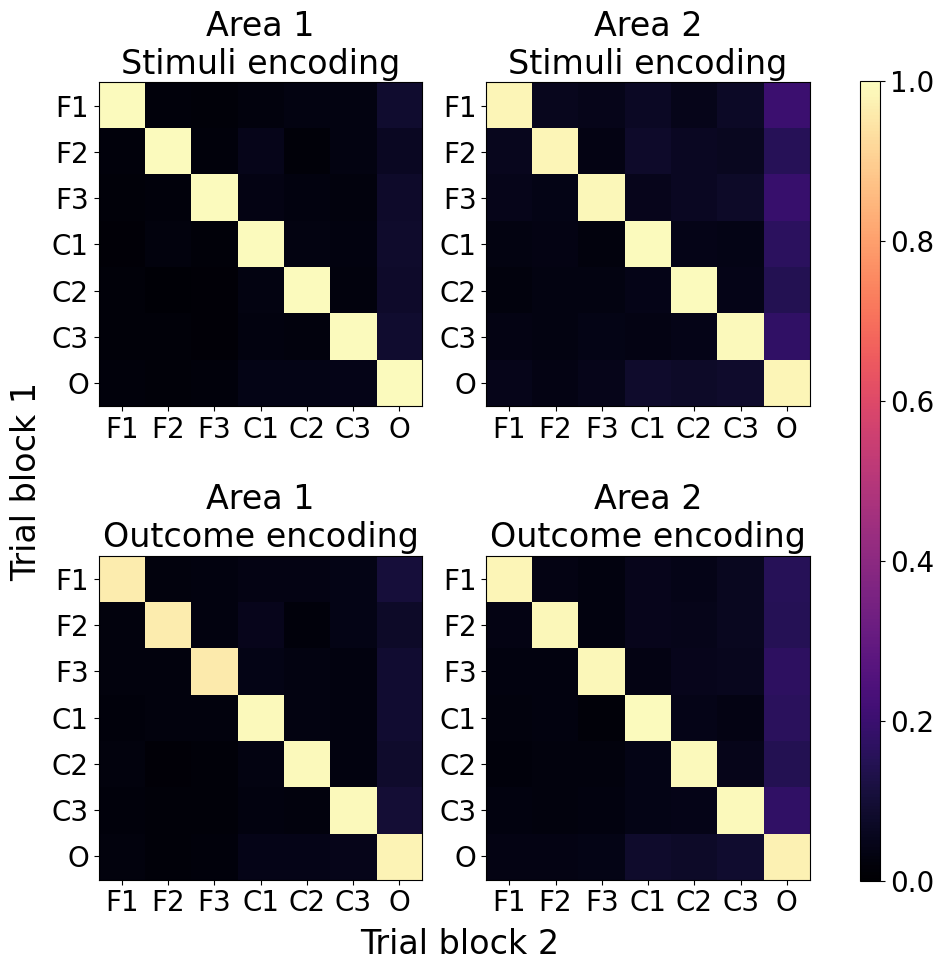

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


for area in range(2):
    cm = axes[0,area].imshow(all_model_curr_stim_overlap.mean(0)[area], vmin=0, vmax=1, cmap='magma')  
    axes[0,area].set_xticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
    axes[0,area].set_yticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
    axes[0,area].set_title(f'Area {area+1}\nStimuli encoding')
        
for area in range(2):
    cm = axes[1,area].imshow(all_model_curr_outcome_overlap.mean(0)[area], vmin=0, vmax=1, cmap='magma') 
    axes[1,area].set_xticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
    axes[1,area].set_yticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
    axes[1,area].set_title(f'Area {area+1}\nOutcome encoding')
        
fig.supxlabel("Trial block 2", y=0.02)
fig.supylabel("Trial block 1", x=0.05)
fig.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.85, top=0.9)
cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)


with PdfPages(f'plots/{plot_save_dir}/dpca_stability_by_block.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/dpca_stability_by_block.pdf')



In [66]:
all_model_dpca_curr_stim = []
all_model_dpca_curr_outcome = []

for idx_model in tqdm.tqdm(range(len(all_models))):
    # iterate all area for each model
    all_area_dpca_curr_stim = []
    all_area_dpca_curr_outcome = [] 
    for idx_area in range(NUM_AREAS):
        # for each area of each network, split into two blocks of trials
        trials_to_fit = np.arange(args['test_N_s'])
        _, area_dpca_by_curr_stim, area_dpca_by_curr_outcome = \
                        get_dpca_by_area(all_saved_states, task_mdprl, args, 
                                         area_to_fit=idx_area, 
                                         trials_to_fit=trials_to_fit,
                                         model_to_fit=idx_model)
        
        all_area_dpca_curr_stim.append(area_dpca_by_curr_stim)
        all_area_dpca_curr_outcome.append(area_dpca_by_curr_outcome)
        
    all_model_dpca_curr_stim.append(all_area_dpca_curr_stim)
    all_model_dpca_curr_outcome.append(all_area_dpca_curr_outcome)


100%|██████████| 8/8 [01:19<00:00,  9.92s/it]


Figure saved at plots/exp/test1/dpca_curr_outcome_overlap.pdf


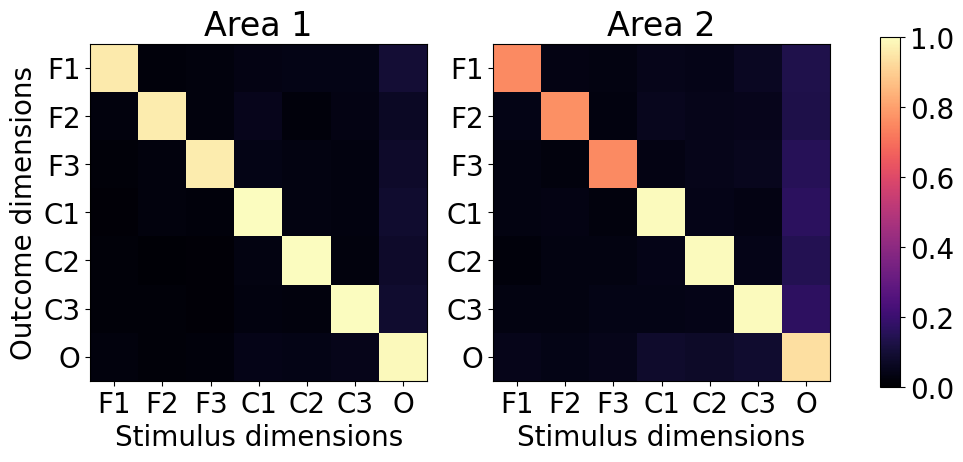

In [75]:
all_model_stim_outcome_overlap = []

fig, axes = plt.subplots(1, 2, figsize=(10, 7))

for idx_model in range(len(all_models)):
    all_areas_stim_outcome_overlap = []
    for idx_area in range(NUM_AREAS):
        stim_outcome_overlap = get_dpca_axes_overlap(all_model_dpca_curr_outcome[idx_model][idx_area]['encoding_axes'],
                                                     all_model_dpca_curr_stim[idx_model][idx_area]['encoding_axes'])
#         for k_outcome_idx, k_outcome in enumerate(['s','p','c','pc','sc','sp','spc']):
#             for k_stim_idx, k_stim in enumerate(['s','p','c','pc','sc','sp','spc']):
#                 stim_outcome_overlap[k_outcome_idx, k_stim_idx] = \
#                     np.sum((all_model_dpca_curr_outcome[idx_model][idx_area]['encoding_axes']['t'+k_outcome].T@\
#                             all_model_dpca_curr_stim[idx_model][idx_area]['encoding_axes']['t'+k_stim])**2)/\
#                     all_model_dpca_curr_stim[idx_model][idx_area]['encoding_axes']['t'+k_stim].shape[1]

        all_areas_stim_outcome_overlap.append(stim_outcome_overlap)
    all_model_stim_outcome_overlap.append(np.stack(all_areas_stim_outcome_overlap))
all_model_stim_outcome_overlap = np.stack(all_model_stim_outcome_overlap)

    
for idx_area in range(NUM_AREAS):
    cm = axes[idx_area].imshow(all_model_stim_outcome_overlap.mean(0)[idx_area], vmin=0, vmax=1, cmap='magma')  
    axes[idx_area].set_xticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
    axes[idx_area].set_yticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"])
    axes[idx_area].set_xlabel("Stimulus dimensions")
    axes[idx_area].set_title(f"Area {idx_area+1}")
    
axes[0].set_ylabel("Outcome dimensions")
    
fig.tight_layout()
    
plt.subplots_adjust(bottom=0.05, right=0.85, top=0.95)
cb_ax = fig.add_axes([0.9, 0.25, 0.02, 0.5])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)


with PdfPages(f'plots/{plot_save_dir}/dpca_curr_outcome_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/dpca_curr_outcome_overlap.pdf')


In [68]:
all_model_weight_dpca_overlap_stim = []
all_model_weight_dpca_overlap_outcome = []


for idx_model in range(len(all_models)):
    
    all_model_weight_dpca_overlap_stim.append(np.stack([
        get_dpca_axes_overlap(all_model_dpca_in[idx_model].P, 
                              all_model_dpca_curr_stim[idx_model][0]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_out[idx_model].P, 
                              all_model_dpca_curr_stim[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_ch[idx_model].P, 
                              all_model_dpca_curr_stim[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc'])
    ]))
    
    all_model_weight_dpca_overlap_outcome.append(np.stack([
        get_dpca_axes_overlap(all_model_dpca_in[idx_model].P, 
                              all_model_dpca_curr_outcome[idx_model][0]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_out[idx_model].P, 
                              all_model_dpca_curr_outcome[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_ch[idx_model].P, 
                              all_model_dpca_curr_outcome[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc'])
    ]))
    
all_model_weight_dpca_overlap_stim = np.stack(all_model_weight_dpca_overlap_stim)
all_model_weight_dpca_overlap_outcome = np.stack(all_model_weight_dpca_overlap_outcome)
    
    

/scratch/ipykernel_2190139/3360009081.py:22: UserWarning: Adding colorbar to a different Figure <Figure size 1000x700 with 3 Axes> than <Figure size 1200x700 with 7 Axes> which fig.colorbar is called on.
  fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)


Figure saved at plots/exp/test1/dpca_struct_func_overlap.pdf


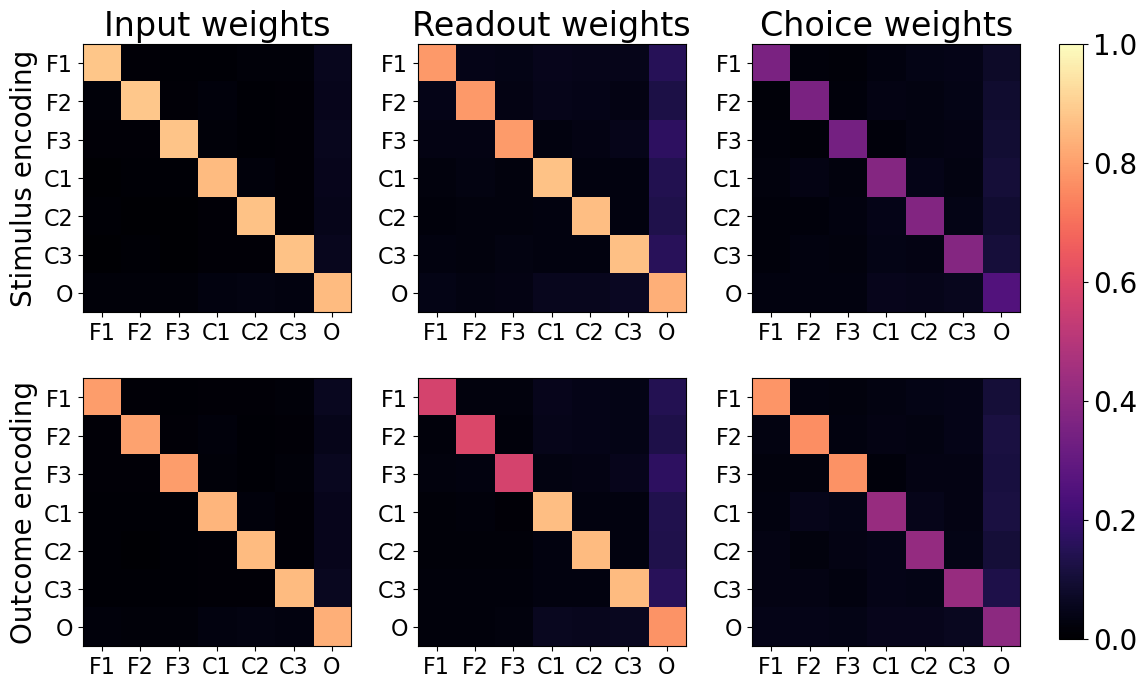

In [74]:
fig, axes = plt.subplots(2, 3, figsize=(12,7))


for i in range(3):
    axes[0,i].imshow(all_model_weight_dpca_overlap_stim.mean(0)[i], vmin=0, vmax=1, cmap='magma')
    axes[1,i].imshow(all_model_weight_dpca_overlap_outcome.mean(0)[i], vmin=0, vmax=1, cmap='magma')

for i in range(2):
    for j in range(3):
        axes[i,j].set_xticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"], fontsize=16)
        axes[i,j].set_yticks(np.arange(7),["F1", "F2", "F3", "C1", "C2", "C3", "O"], fontsize=16)

axes[0,0].set_ylabel("Stimulus encoding")
axes[1,0].set_ylabel("Outcome encoding")
axes[0,0].set_title("Input weights")
axes[0,1].set_title("Readout weights")
axes[0,2].set_title("Choice weights")

fig.tight_layout()
plt.subplots_adjust(top=0.95, right=0.88)
cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.85])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)

with PdfPages(f'plots/{plot_save_dir}/dpca_struct_func_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/dpca_struct_func_overlap.pdf')


In [70]:
all_models_stim_exp_var = []
all_models_outcome_exp_var = []

for idx_model in range(len(all_models)):
    
    all_areas_stim_exp_var = []
    all_areas_outcome_exp_var = []
    for idx_area in range(NUM_AREAS):
        all_areas_stim_exp_var.append(get_dpca_exp_var(all_model_dpca_curr_stim[idx_model][idx_area]))
        all_areas_outcome_exp_var.append(get_dpca_exp_var(all_model_dpca_curr_outcome[idx_model][idx_area]))
    
    all_areas_stim_exp_var = np.stack(all_areas_stim_exp_var)
    all_models_stim_exp_var.append(all_areas_stim_exp_var)
    all_areas_outcome_exp_var = np.stack(all_areas_outcome_exp_var)
    all_models_outcome_exp_var.append(all_areas_outcome_exp_var)

all_models_stim_exp_var = np.stack(all_models_stim_exp_var)
all_models_outcome_exp_var = np.stack(all_models_outcome_exp_var)




Figure saved at plots/fp_approx/dpca_func_exp_var.pdf


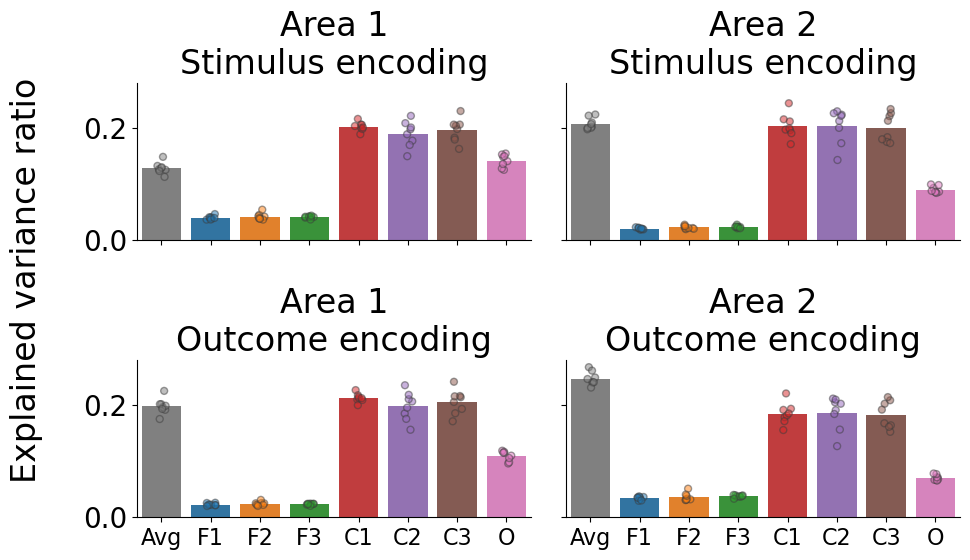

In [73]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 6))

# axes[0,0].bar(np.arange(8), all_models_stim_exp_var.mean(0)[0])
# axes[0,1].bar(np.arange(8), all_models_stim_exp_var.mean(0)[1])
# axes[1,0].bar(np.arange(8), all_models_outcome_exp_var.mean(0)[0])
# axes[1,1].bar(np.arange(8), all_models_outcome_exp_var.mean(0)[1])

def plot_functional_dpca_exp_var(exp_var, ax, title):
    xxx_for_plot = np.repeat(np.arange(8)[None], len(all_models), axis=0)
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(np.concatenate([np.array([[0.5, 0.5, 0.5, 1]]), plt.cm.tab10(np.arange(7))]))
    
    
    sns.barplot(ax=ax, x=xxx_for_plot.flatten(), hue=xxx_for_plot.flatten(),
                y=exp_var.flatten(), palette=cmap, errorbar=None, legend=False)
    sns.stripplot(ax=ax, x=xxx_for_plot.flatten(), y=exp_var.flatten(),
                  hue=xxx_for_plot.flatten(), 
                  palette=cmap, legend=False, linewidth=1, alpha=0.5)
    
    ax.set_title(title)
    ax.set_xticks(np.arange(8),["Avg", "F1", "F2", "F3", "C1", "C2", "C3", "O"], fontsize=16)
    
plot_functional_dpca_exp_var(all_models_stim_exp_var[:,0], axes[0,0], f'Area 1\nStimulus encoding')
plot_functional_dpca_exp_var(all_models_stim_exp_var[:,1], axes[0,1], f'Area 2\nStimulus encoding')
plot_functional_dpca_exp_var(all_models_outcome_exp_var[:,0], axes[1,0], f'Area 1\nOutcome encoding')
plot_functional_dpca_exp_var(all_models_outcome_exp_var[:,1], axes[1,1], f'Area 2\nOutcome encoding')


fig.supylabel('Explained variance ratio')

sns.despine()
fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/dpca_func_exp_var.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/dpca_func_exp_var.pdf')


In [72]:
# kills the kernel, caution

# fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)

# weight_alignment = np.trace(all_saved_states['whs'].squeeze()[...,64:128,:][...,:64]@\
#              all_saved_states['whs'].squeeze()[...,:64,:][...,64:128], axis1=-2, axis2=-1)

# plot_mean_and_std(ax, weight_alignment.mean(1), weight_alignment.std(1)/np.sqrt(weight_alignment.shape[1]), label=None, color='k')
            
# ax.set_xlabel('Trial')
# ax.set_ylabel('Weight alignment')

# fig.tight_layout()

# Candidate mechanisms of modulating attention
$$
\begin{align*}
    \frac{\partial \text{logit}_s}{\partial r_{s-1}}=\underbrace{B diag(\sigma'_{ })}_{\text{1.gain modulation}} 
    \underbrace{(I-W_sdiag(\sigma'_{}))^{-1}}_{\text{2.recurrence}}
    \underbrace{(A\odot(h_{s-1}h_{s-1}^{\top}))h_s}_{\text{3.routing through alignment}}
\end{align*}
$$
1. Gain modulation
2. Amplification through recurrence
2. Dynamic routing through alignment

### activity of rnn at the end of choice trials and choice presentation approximately converges, so we can simplify with implicit function

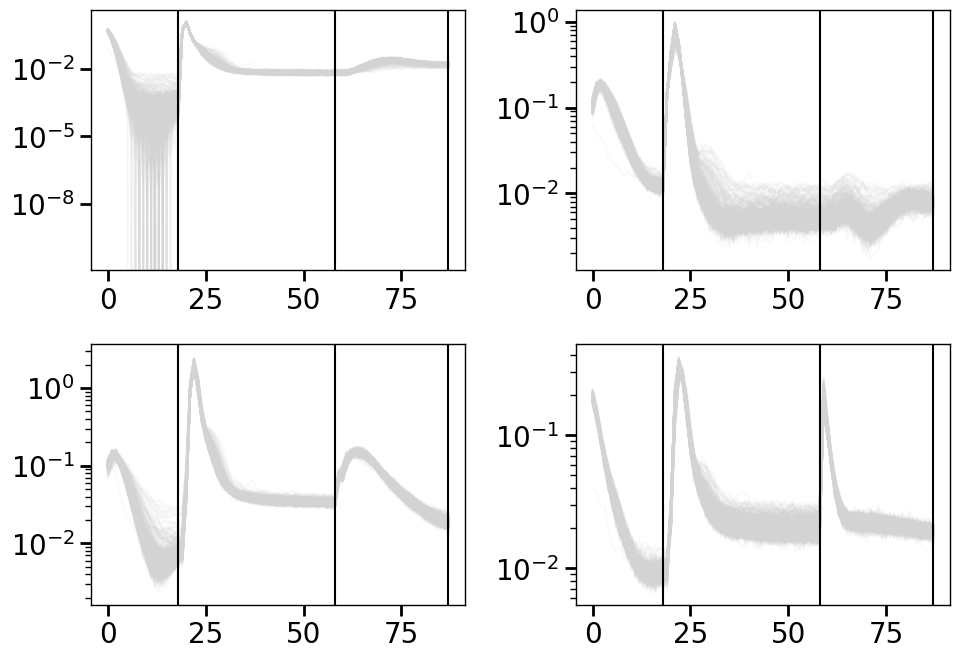

In [309]:
fig, axes = plt.subplots(2, 2)

delta_h = ((all_saved_states['hs'][:,1:,:,:]-all_saved_states['hs'][:,:-1,:,:])**2).mean(2) 
# shape = trial X time X units

axes[0,0].plot(delta_h[...,input_weight_inds[:64]].sum(-1).T.numpy(), alpha=0.1, color='lightgrey');
axes[0,1].plot(delta_h[...,input_weight_inds[64:]].sum(-1).T.numpy(), alpha=0.1, color='lightgrey');
axes[1,0].plot(delta_h[...,output_weight_inds[:64]].sum(-1).T.numpy(), alpha=0.1, color='lightgrey');
axes[1,1].plot(delta_h[...,output_weight_inds[64:]].sum(-1).T.numpy(), alpha=0.1, color='lightgrey');

for i in range(2):
    for j in range(2):
        axes[i,j].axvline(task_mdprl.T_fixation-2, color='black')
        axes[i,j].axvline(task_mdprl.T_stim+task_mdprl.T_fixation-2, color='black')
        axes[i,j].axvline(task_mdprl.T_stim+task_mdprl.T_fixation+task_mdprl.T_ch-2, color='black')
        axes[i,j].set_yscale('log')
#         axes[i,j].axvline(np.where(task_mdprl.T_rwd)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][-1], color='black')

plt.tight_layout()


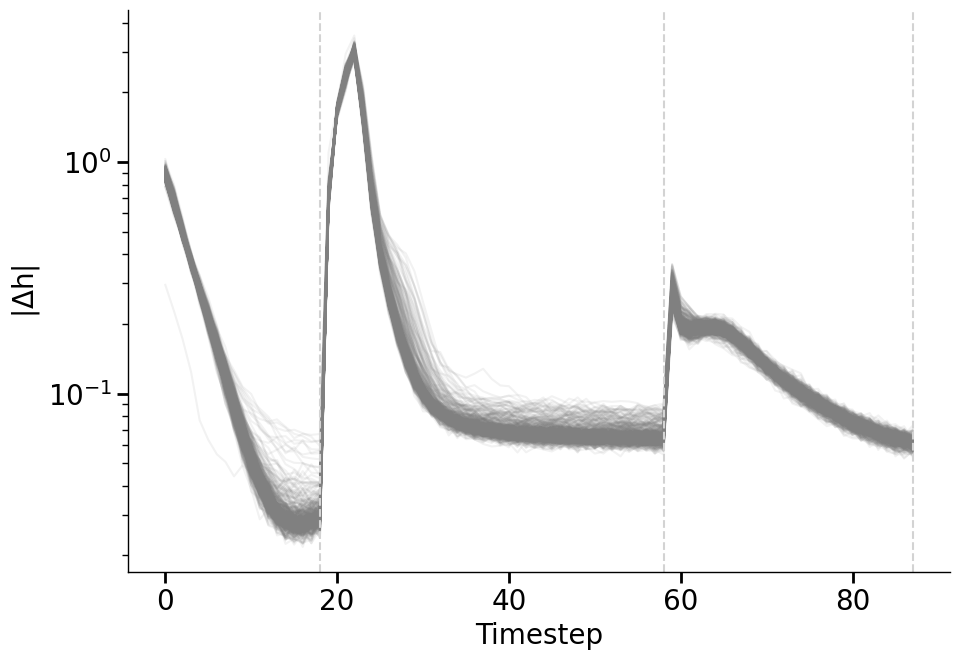

In [310]:
plt.plot(delta_h.sum(-1).T.numpy(), alpha=0.1, color='grey');


plt.axvline(task_mdprl.T_fixation-2, color='lightgrey', ls='--')
plt.axvline(task_mdprl.T_stim+task_mdprl.T_fixation-2, color='lightgrey', ls='--')
plt.axvline(task_mdprl.T_stim+task_mdprl.T_fixation+task_mdprl.T_ch-2, color='lightgrey', ls='--')
#         plt.axvline(np.where(task_mdprl.T_rwd)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][-1], color='black')

# plt.axhline(0.01, linestyle='--', c='k')
plt.yscale('log')
plt.xlabel('Timestep')
plt.ylabel(r'$|\Delta h|$')
sns.despine()
plt.tight_layout()

In [311]:
# get the gains and average firing rates necessary for further calculations

# activity at steady state of decision phase
h_avg_ch = all_saved_states['hs'][:,task_mdprl.T_fixation+task_mdprl.T_stim-1,:,:] 
# activity at steady state of choice feedback phase
h_avg_lrn = all_saved_states['hs'][:,-1,:,:]
h_gain = ((h_avg_ch>0).float()*(1-h_avg_ch**2)) # gain at steady state

print(h_avg_ch.shape, h_avg_lrn.shape, h_gain.shape)
print(model.h2o.effective_weight().detach().shape, all_saved_states['whs'].shape)


torch.Size([432, 92, 160]) torch.Size([432, 92, 160]) torch.Size([432, 92, 160])
torch.Size([27, 64]) torch.Size([432, 1, 92, 160, 160])


In [312]:
whs_no_mod = []
# all_saved_states['whs'] contains weights *after each trial*, so add initial weights back in
# whs_no_mod contains weights *during* each trial

for idx_sess in tqdm.tqdm(range(all_saved_states['hs'].shape[2])):
    model = all_models[all_saved_states['model_assignment'][idx_sess]]
    whs_no_mod.append(torch.cat([
        model.rnn.h2h.effective_weight()[None],
        model.rnn.h2h.effective_weight(all_saved_states['whs'][:-1,0,idx_sess,...])
    ]))

whs_no_mod = torch.stack(whs_no_mod, 1)
print(whs_no_mod.shape)
    

100%|██████████| 92/92 [00:00<00:00, 115.72it/s]


torch.Size([432, 92, 160, 160])


In [313]:
h2o_gain_mod = []
whs_gain_mod = []
delta_ws = []

for idx_sess in tqdm.tqdm(range(all_saved_states['hs'].shape[2])):
    model = all_models[all_saved_states['model_assignment'][idx_sess]]
    # gain modulated readout
    h2o_gain_mod.append(
        h_gain[:,idx_sess:idx_sess+1,output_weight_inds[:64]]*\
        model.h2o.effective_weight().detach()[None,...])
    # gain modulated recurrent weights
    whs_gain_mod.append(
        h_gain[:,idx_sess:idx_sess+1,:]*whs_no_mod[:,idx_sess,...])
    # weight change (unsigned)
    delta_ws.append((model.plasticity.effective_lr().detach()*model.rnn.h2h.mask)[None]*\
                (h_avg_lrn[:,idx_sess][...,None]*h_avg_lrn[:,idx_sess][...,None,:]))

h2o_gain_mod = torch.stack(h2o_gain_mod, axis=1)
whs_gain_mod = torch.stack(whs_gain_mod, axis=1)
delta_ws = torch.stack(delta_ws, axis=1)

print(h2o_gain_mod.shape, whs_gain_mod.shape, delta_ws.shape)


100%|██████████| 92/92 [00:03<00:00, 29.37it/s]


torch.Size([432, 92, 27, 64]) torch.Size([432, 92, 160, 160]) torch.Size([432, 92, 160, 160])


In [314]:
h2o_gain_mod_avail = torch.empty(431, 92, 64)

for idx_trial in range(1,432):
    for idx_sess in range(92):
        curr_stimuli = all_saved_states['stimuli'][idx_trial, 0, idx_sess]
        h2o_gain_mod_avail[idx_trial-1, idx_sess] = \
            h2o_gain_mod[idx_trial,idx_sess,curr_stimuli[1]]-h2o_gain_mod[idx_trial,idx_sess,curr_stimuli[0]]


### correlation between analytical gradient and approximation

In [315]:
# invert I-jacobian 

inv_jac = torch.zeros_like(whs_gain_mod)

for idx_trial in tqdm.tqdm(range(432)):
    for idx_sess in range(92):
        
        lstsq_result = torch.linalg.lstsq(
                    torch.eye(args['hidden_size']*args['num_areas'])-whs_gain_mod[idx_trial, idx_sess], 
                    torch.eye(args['hidden_size']*args['num_areas']),
                    rcond=0.01, driver='gelsd')

        inv_jac[idx_trial, idx_sess] = lstsq_result[0]

print(inv_jac.shape)


100%|██████████| 432/432 [01:45<00:00,  4.09it/s]

torch.Size([432, 92, 160, 160])


In [316]:
inv_jac_times_hebb = torch.zeros_like(h_avg_ch)*torch.nan
hebb_times_hs = torch.zeros_like(h_avg_ch)*torch.nan

for idx_trial in tqdm.tqdm(range(432-1)):
    for idx_sess in range(92):
        hebb_times_hs[idx_trial, idx_sess] = \
            delta_ws[idx_trial, idx_sess]@h_avg_ch[idx_trial+1, idx_sess, :]
        inv_jac_times_hebb[idx_trial, idx_sess] = \
            (inv_jac[idx_trial+1, idx_sess]@hebb_times_hs[idx_trial, idx_sess][:,None]).squeeze()

inv_jac_times_hebb = inv_jac_times_hebb[:-1]
hebb_times_hs = hebb_times_hs[:-1]

print(inv_jac_times_hebb.shape, hebb_times_hs.shape)

100%|██████████| 431/431 [00:02<00:00, 158.28it/s]

torch.Size([431, 92, 160]) torch.Size([431, 92, 160])


In [317]:
# calculate approximate sensitivity
approx_sensitivity = h2o_gain_mod_avail[...,None,:]@inv_jac_times_hebb[...,output_weight_inds[:64]][...,None]

removed 0 trial(s)
LinregressResult(slope=0.5684344281102545, intercept=0.00017005675379586722, rvalue=0.920005258836325, pvalue=0.0, stderr=0.0012160470989053148, intercept_stderr=0.00030192188105700976)
Figure saved at plots/exp/test1/true_approx_sensitivity_corr.pdf


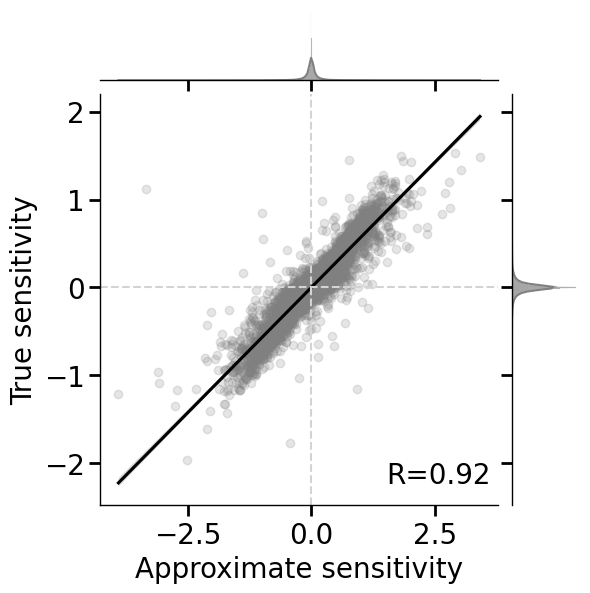

In [318]:
# plot scatter 
# fig, ax = plt.subplots(figsize=(6,6))

true_sensitivity = all_saved_states['rwd_sensitivity'][1:].squeeze().flatten().numpy()
# true_sensitivity_outlier_mask = np.abs(true_sensitivity-np.median(true_sensitivity))<\
#                                         np.mean(np.abs(true_sensitivity-np.median(true_sensitivity)))*20
true_sensitivity_outlier_mask = np.abs(true_sensitivity)<5
print(f"removed {(~true_sensitivity_outlier_mask).sum()} trial(s)")
true_sensitivity_no_outlier = true_sensitivity[true_sensitivity_outlier_mask]
approx_sensitivity_no_outlier = approx_sensitivity.detach().squeeze().flatten().numpy()
approx_sensitivity_no_outlier = approx_sensitivity_no_outlier[true_sensitivity_outlier_mask]

jp = sns.jointplot(x=approx_sensitivity_no_outlier, 
                  y=true_sensitivity_no_outlier,
                  kind='reg', color='grey', scatter_kws={'color':'grey', 'alpha':0.2}, line_kws={'color':'k'})

# scatter_kws={'color':'grey', 'alpha':0.2}, line_kws={'color':'k'}
sensitivity_approx_corr = stats.linregress(approx_sensitivity.detach().flatten(), true_sensitivity.flatten())
print(sensitivity_approx_corr)

jp.ax_joint.axhline(0, color='lightgrey', linestyle='--')
jp.ax_joint.axvline(0, color='lightgrey', linestyle='--')
jp.ax_joint.set_xlabel('Approximate sensitivity')
jp.ax_joint.set_ylabel('True sensitivity')
# jp.ax_joint.axis('equal')
fig.tight_layout()

# axlim = max(np.abs(true_sensitivity_no_outlier).max(), np.abs(approx_sensitivity_no_outlier).max())*1.2

# jp.ax_joint.set_xlim([-axlim, axlim])
# jp.ax_joint.set_ylim([-axlim, axlim])
jp.ax_joint.text(jp.ax_joint.get_xlim()[1]*0.4, jp.ax_joint.get_ylim()[0]*0.9, 
        f"R={np.round(sensitivity_approx_corr.rvalue, 2)}", 
        fontsize=20)

with PdfPages(f'plots/{plot_save_dir}/true_approx_sensitivity_corr.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/true_approx_sensitivity_corr.pdf')


## Calculate gain modulation of readout
$$ 
B diag(\sigma')
$$

In [319]:
def get_readout_overlap_dynamic(all_model_dpca, all_sess_h2o_gain_mod, 
                                all_sess_chosen, all_sess_foregone,
                                all_sess_model_assignment, all_sess_dim_order_reverse,
                                ax):
    all_sess_choice_dir = []
    all_sess_overlap_exp_var = []

    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
    dim_labels = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
    
    for sess_idx in tqdm.tqdm(range(92)):

        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [obj_key]
        
        permutted_key_index = np.concatenate([
            np.array(all_sess_dim_order_reverse[sess_idx]), 
            np.array(all_sess_dim_order_reverse[sess_idx])+3, [6]])
        
        curr_sess_dpca = all_model_dpca[all_sess_model_assignment[sess_idx]]
        
        curr_sess_exp_var = np.zeros((431,7))
        curr_sess_choice_dir = np.zeros((431,7))
        
        stim_chosen_FCO = obj_to_ft_conj(all_sess_chosen[...,sess_idx], task_mdprl).squeeze()
        stim_chosen_FCO = stim_chosen_FCO[...,permutted_key_index]
        stim_foregone_FCO = obj_to_ft_conj(all_sess_foregone[...,sess_idx], task_mdprl).squeeze()
        stim_foregone_FCO = stim_foregone_FCO[...,permutted_key_index]
        
        for k_idx, k_name in enumerate(permutted_key_order):
            
            curr_sess_dim_psth = curr_sess_dpca.marginalized_psth[k_name].squeeze().reshape((args['hidden_size'], -1))
            
            choice_direction = curr_sess_dim_psth[:,stim_chosen_FCO[1:,k_idx]]\
                              -curr_sess_dim_psth[:,stim_foregone_FCO[1:,k_idx]]
            choice_direction = choice_direction/np.linalg.norm(choice_direction, axis=0, keepdims=True)
            
            h2o_reparam = all_sess_h2o_gain_mod[:, sess_idx].detach().numpy()@curr_sess_dpca.P[k_name][:E_SIZE,:]
            curr_sess_exp_var[:,k_idx] = (h2o_reparam**2).sum(1)\
                                    /(all_sess_h2o_gain_mod[:, sess_idx].detach().numpy()**2).sum((1))
            
            h2o_proj = all_sess_h2o_gain_mod[:, None, sess_idx].detach().numpy()@choice_direction.T[:,:E_SIZE,None]
            
            curr_sess_choice_dir[:,k_idx] = (h2o_proj**2).squeeze()\
                                    /(all_sess_h2o_gain_mod[:, sess_idx].detach().numpy()**2).sum((1))
        
        all_sess_overlap_exp_var.append(curr_sess_exp_var)
        all_sess_choice_dir.append(curr_sess_choice_dir)
        
    all_sess_overlap_exp_var = np.stack(all_sess_overlap_exp_var, 1)
    all_sess_choice_dir = np.stack(all_sess_choice_dir, 1)
    
    w_size = 432//16
    
    for idx_k in range(7):
        smth_exp_var = np.stack([
            np.convolve(all_sess_choice_dir[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(92)
        ], axis=1)
        
        plot_mean_and_std(ax=axes[0],
                      m=smth_exp_var.mean(1), 
                      sd=smth_exp_var.std(1)/np.sqrt(92),
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))

    for idx_k in range(7):
        smth_exp_var = np.stack([
            np.convolve(all_sess_overlap_exp_var[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(92)
        ], axis=1)
        
        plot_mean_and_std(ax=axes[1],
                      m=smth_exp_var.mean(1), 
                      sd=smth_exp_var.std(1)/np.sqrt(92),
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))

    axes[1].set_xlabel('Trial')
    axes[0].set_ylabel('Disc. Direction')
    axes[1].set_ylabel('Total var.')
    
    return all_sess_choice_dir, all_sess_overlap_exp_var
    

100%|██████████| 92/92 [00:00<00:00, 519.28it/s]


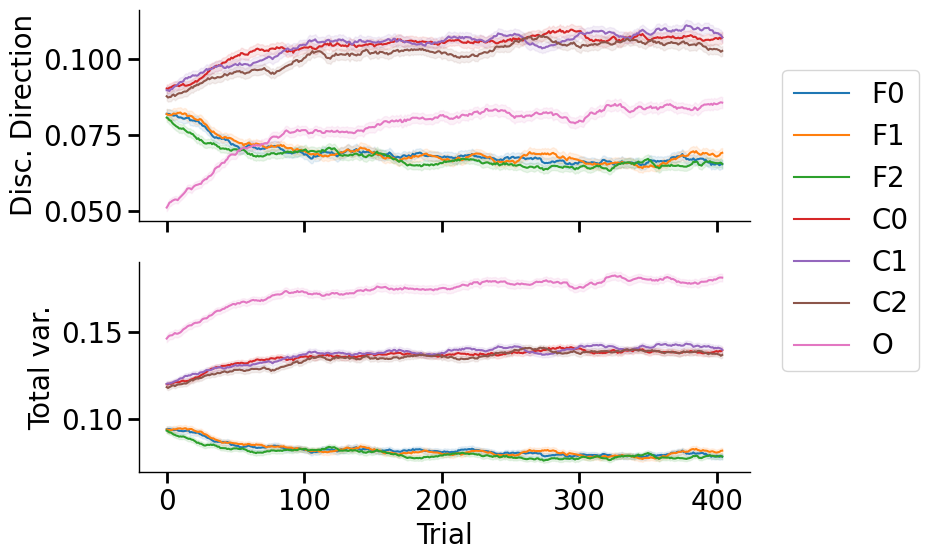

In [320]:
fig, axes = plt.subplots(2,1, figsize=(8, 6), sharex=True)
_, _ = get_readout_overlap_dynamic(all_model_dpca_out, h2o_gain_mod_avail,
                                   all_saved_states['choices'], all_saved_states['foregone'], 
                                   all_saved_states['model_assignment'], 
                                   all_saved_states['test_stim_dim_order'], axes)
fig.tight_layout()
sns.despine()
lgd = axes[0].legend(bbox_to_anchor=(1.3, 0), loc='center right')

## Recurrence through plastic weights
$$
(I-W_sdiag(\sigma'_{}))^{-1} = \sum_{k=0}^T (W_sdiag(\sigma'_{}))^k \approx W_sdiag(\sigma')
$$

In [327]:
whs_diffs = []


h_stims = all_saved_states['hs'][:,task_mdprl.T_fixation:\
                                     task_mdprl.T_fixation+task_mdprl.T_stim-1]
h_gain_avg = ((h_stims>0).float()*(1-h_stims**2)).mean(1)

for sess_idx in tqdm.tqdm(range(92)):
    curr_m = all_models[all_saved_states['model_assignment'][sess_idx]]
    whs_diffs.append(curr_m.rnn.h2h.effective_weight(all_saved_states['whs'][:,0,sess_idx])\
                    -curr_m.rnn.h2h.effective_weight().detach())    
    
whs_diffs = np.stack(whs_diffs, axis=1)
whs_diffs_gain_mod = whs_diffs*h_gain_avg[:,:,None,:].numpy()


100%|██████████| 92/92 [00:03<00:00, 28.06it/s]


In [328]:
def get_rec_overlap_dynamic(all_model_dpca_pre, all_model_dpca_post, all_sess_whs,
                            all_sess_chosen, all_sess_foregone,
                            all_sess_model_assignment, all_sess_dim_order_reverse,
                            ax, w_size):
    all_sess_choice_dir = []
    all_sess_overlap_exp_var = []


    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
    dim_labels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O']
    
    for sess_idx in tqdm.tqdm(range(92)):

        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [obj_key]
        
        curr_sess_dpca_pre = all_model_dpca_pre[all_sess_model_assignment[sess_idx]]
        curr_sess_dpca_post = all_model_dpca_post[all_sess_model_assignment[sess_idx]]
        
        permutted_key_index = np.concatenate([
            np.array(all_sess_dim_order_reverse[sess_idx]), 
            np.array(all_sess_dim_order_reverse[sess_idx])+3,
            [6]
        ])
        
        curr_sess_exp_var = np.zeros((432,7))
        curr_sess_choice_dir = np.zeros((432,7))
        
        stim_chosen_FCO = obj_to_ft_conj(all_sess_chosen[...,sess_idx], task_mdprl).squeeze()
        stim_chosen_FCO = stim_chosen_FCO[...,permutted_key_index]
        stim_foregone_FCO = obj_to_ft_conj(all_sess_foregone[...,sess_idx], task_mdprl).squeeze()
        stim_foregone_FCO = stim_foregone_FCO[...,permutted_key_index]
                
        for idx_trial in range(432):
            for k_idx, k_name in enumerate(permutted_key_order):
                # explained variance in general
                wh_reparam = curr_sess_dpca_post.P[k_name].T@\
                             all_sess_whs[idx_trial, sess_idx]@\
                             curr_sess_dpca_pre.P[k_name]

                curr_sess_exp_var[idx_trial,k_idx] = (wh_reparam**2).sum() #/wh_reparam.shape[-1]


#         all_sess_choice_dir.append(curr_sess_choice_dir)
        all_sess_overlap_exp_var.append(curr_sess_exp_var)
        
#     all_sess_choice_dir = np.stack(all_sess_choice_dir, 1)
#     all_sess_choice_dir_within = np.diagonal(all_sess_choice_dir, axis1=-2, axis2=-1)
    all_sess_overlap_exp_var = np.stack(all_sess_overlap_exp_var, 1)
#     all_sess_overlap_exp_var_within = np.diagonal(all_sess_overlap_exp_var, axis1=-2, axis2=-1)

    smth_exp_var = []
    for idx_k in range(7):
        smth_exp_var.append(np.stack([
            np.convolve(all_sess_overlap_exp_var[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(92)
        ], axis=1))
        
    smth_exp_var = np.stack(smth_exp_var, -1)

    for idx_k in range(7):
        plot_mean_and_std(ax=ax,
                      m=smth_exp_var[...,idx_k].mean(1), 
                      sd=smth_exp_var[...,idx_k].std(1)/np.sqrt(92),
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))
    
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [smth_exp_var[...,0].T, smth_exp_var[...,1].T, smth_exp_var[...,2].T],
        n_permutations=1000,
        n_jobs=None,
        verbose=False,
    )
    
    sig_dot_y = -ax.get_ylim()[1]*0.05
    for (clus, clus_p) in zip(clusters, cluster_p_values):
        if clus_p<0.05:
            ax.scatter(clus, sig_dot_y*np.ones_like(clus), color='tab:blue', s=1)
    
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [smth_exp_var[...,3].T, smth_exp_var[...,4].T, smth_exp_var[...,5].T],
        n_permutations=1000,
        n_jobs=None,
        verbose=False,
    )
    
    sig_dot_y *= 2
    for (clus, clus_p) in zip(clusters, cluster_p_values):
        if clus_p<0.05:
            ax.scatter(clus, sig_dot_y*np.ones_like(clus), color='tab:red', s=1)
    
    
    return all_sess_overlap_exp_var
        

100%|██████████| 92/92 [00:17<00:00,  5.31it/s]
/scratch/ipykernel_2287972/3775049904.py:72: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/ipykernel_2287972/3775049904.py:84: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| 92/92 [00:18<00:00,  5.03it/s]
/scratch/ipykernel_2287972/3775049904.py:72: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/ipykernel_2287972/3775049904.py:84: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/ipykernel_2287972/3775049904.py:84: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutati

Figure saved at plots/exp/test1/dw_by_subspace.pdf


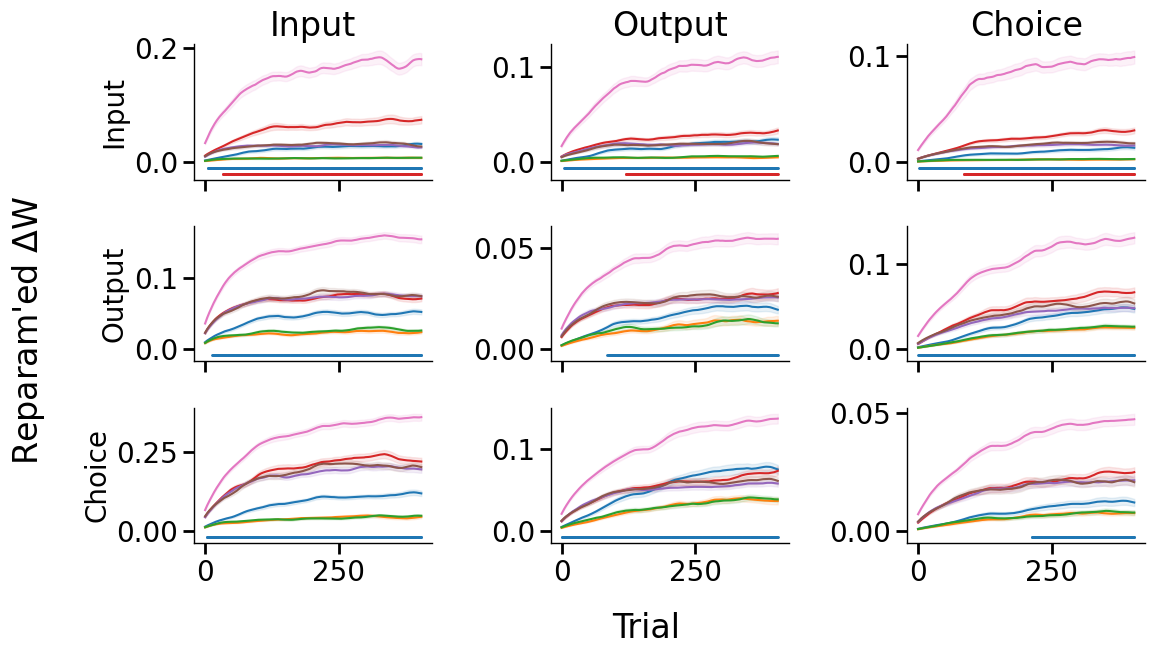

In [337]:
fig, axes = plt.subplots(3,3,figsize=(12,7),sharex=True)

w_size = 432//16

_ = get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_in, 
                            whs_diffs[...,input_weight_inds,:][...,input_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[0,0], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_out, 
                            whs_diffs[...,output_weight_inds,:][...,input_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[1,0], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_ch, 
                            whs_diffs[...,output_weight_inds,:][...,input_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[2,0], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_in, 
                            whs_diffs[...,input_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[0,1], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_out, 
                            whs_diffs[...,output_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[1,1], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_ch, 
                            whs_diffs[...,output_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[2,1], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_ch, all_model_dpca_in, 
                            whs_diffs[...,input_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[0,2], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_ch, all_model_dpca_ch, 
                            whs_diffs[...,output_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[1,2], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_ch, all_model_dpca_out, 
                            whs_diffs[...,output_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[2,2], w_size)


fig.supylabel(r"Reparam'ed $\Delta W$")
fig.supxlabel('Trial', x=0.55, y=0.05)

axes[0,0].set_title('Input')
axes[0,1].set_title('Output')
axes[0,2].set_title('Choice')

axes[0,0].set_ylabel('Input')
axes[1,0].set_ylabel('Output')
axes[2,0].set_ylabel('Choice')


plt.tight_layout()
sns.despine()

with PdfPages(f'plots/{plot_save_dir}/dw_by_subspace.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/dw_by_subspace.pdf')



100%|██████████| 92/92 [00:17<00:00,  5.34it/s]
/scratch/ipykernel_2287972/3775049904.py:72: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/ipykernel_2287972/3775049904.py:84: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| 92/92 [00:19<00:00,  4.69it/s]
/scratch/ipykernel_2287972/3775049904.py:72: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/ipykernel_2287972/3775049904.py:84: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/ipykernel_2287972/3775049904.py:84: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutati

Figure saved at plots/exp/test1/dw_by_subspace_small.pdf


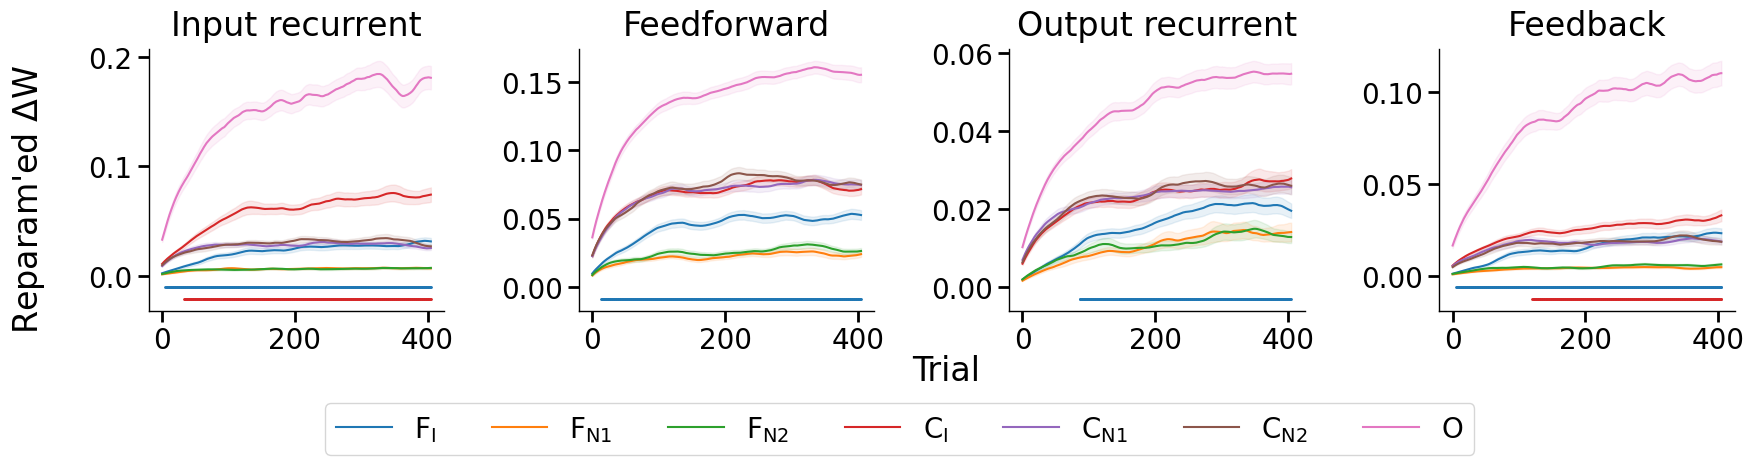

In [330]:
fig, axes = plt.subplots(1,4,figsize=(18,5.1),sharex=True)

w_size = 432//16

_ = get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_in, 
                            whs_diffs[...,input_weight_inds,:][...,input_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[0], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_out, 
                            whs_diffs[...,output_weight_inds,:][...,input_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[1], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_out, 
                            whs_diffs[...,output_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[2], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_in, 
                            whs_diffs[...,input_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[3], w_size)


fig.supylabel(r"Reparam'ed $\Delta W$", y=0.57)
fig.supxlabel('Trial', x=0.54, y=0.2)

dim_labels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O']


axes[0].set_title('Input recurrent', pad=10)
axes[1].set_title('Feedforward', pad=10)
axes[2].set_title('Output recurrent', pad=10)
axes[3].set_title('Feedback', pad=10)

plt.tight_layout()
sns.despine()

plt.subplots_adjust(bottom=0.35)

axes[0].legend(ncols=len(dim_labels), loc='upper left', bbox_to_anchor=(0.55, -0.3))

with PdfPages(f'plots/{plot_save_dir}/dw_by_subspace_small.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/dw_by_subspace_small.pdf')



100%|██████████| 92/92 [00:17<00:00,  5.29it/s]
/scratch/ipykernel_2287972/3775049904.py:72: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/ipykernel_2287972/3775049904.py:84: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| 92/92 [00:17<00:00,  5.27it/s]
/scratch/ipykernel_2287972/3775049904.py:72: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/ipykernel_2287972/3775049904.py:84: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/ipykernel_2287972/3775049904.py:84: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutati

Figure saved at plots/exp/test1/dw_gain_mod_by_subspace.pdf


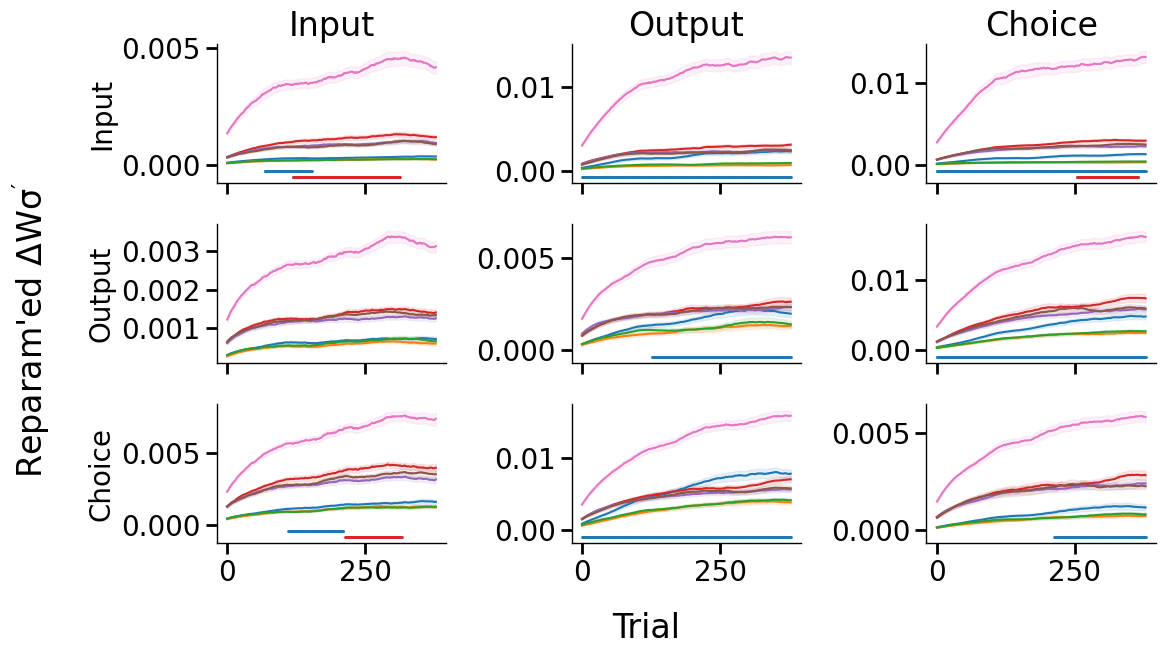

In [338]:
fig, axes = plt.subplots(3,3,figsize=(12,7),sharex=True)


w_size = 432//8

_ = get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_in, 
                            whs_diffs_gain_mod[...,input_weight_inds,:][...,input_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[0,0], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_out, 
                            whs_diffs_gain_mod[...,output_weight_inds,:][...,input_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[1,0], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_ch, 
                            whs_diffs_gain_mod[...,output_weight_inds,:][...,input_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[2,0], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_in, 
                            whs_diffs_gain_mod[...,input_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[0,1], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_out, 
                            whs_diffs_gain_mod[...,output_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[1,1], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_ch, 
                            whs_diffs_gain_mod[...,output_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[2,1], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_ch, all_model_dpca_in, 
                            whs_diffs_gain_mod[...,input_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[0,2], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_ch, all_model_dpca_ch, 
                            whs_diffs_gain_mod[...,output_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[1,2], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_ch, all_model_dpca_out, 
                            whs_diffs_gain_mod[...,output_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[2,2], w_size)


fig.supylabel(r"Reparam'ed $\Delta W\sigma^\prime$")
fig.supxlabel('Trial', x=0.55, y=0.05)

axes[0,0].set_title('Input')
axes[0,1].set_title('Output')
axes[0,2].set_title('Choice')

axes[0,0].set_ylabel('Input')
axes[1,0].set_ylabel('Output')
axes[2,0].set_ylabel('Choice')


plt.tight_layout()
sns.despine()

with PdfPages(f'plots/{plot_save_dir}/dw_gain_mod_by_subspace.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/dw_gain_mod_by_subspace.pdf')


100%|██████████| 92/92 [00:19<00:00,  4.73it/s]
/scratch/ipykernel_2287972/3775049904.py:72: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/ipykernel_2287972/3775049904.py:84: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| 92/92 [00:16<00:00,  5.51it/s]
/scratch/ipykernel_2287972/3775049904.py:72: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/ipykernel_2287972/3775049904.py:84: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/scratch/ipykernel_2287972/3775049904.py:84: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutati

Figure saved at plots/exp/test1/dw_gain_mod_by_subspace_small.pdf


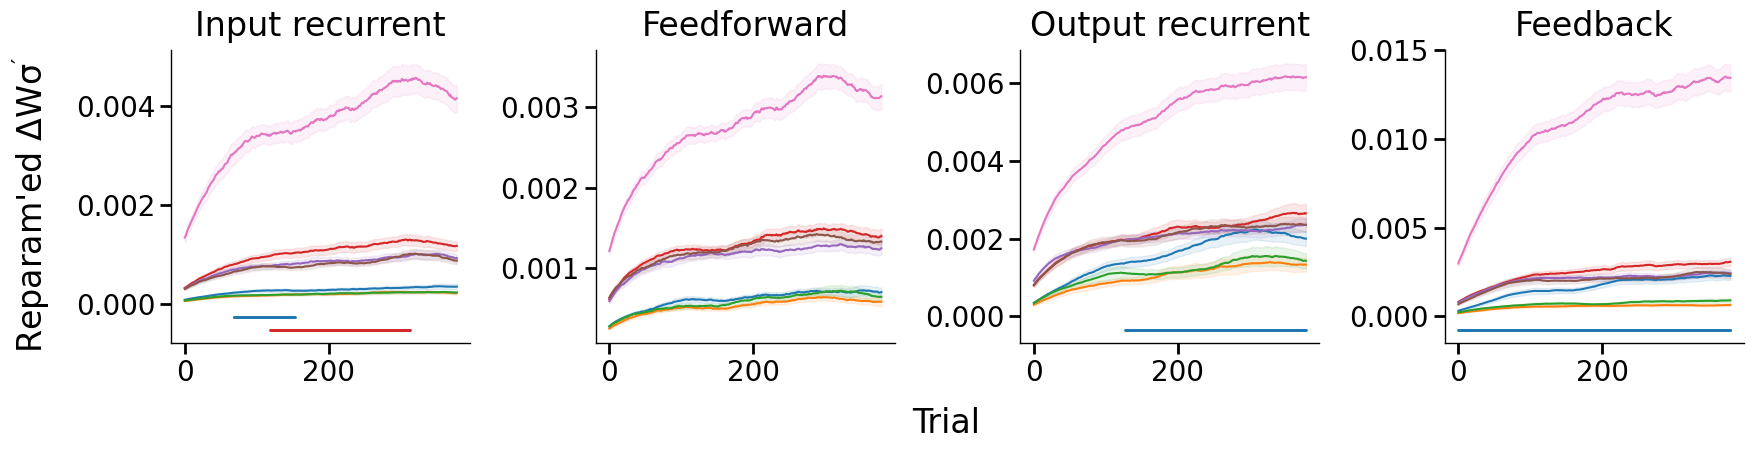

In [339]:
fig, axes = plt.subplots(1,4,figsize=(18,5),sharex=True)


w_size = 432//8

_ = get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_in, 
                            whs_diffs_gain_mod[...,input_weight_inds,:][...,input_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[0], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_in, all_model_dpca_out, 
                            whs_diffs_gain_mod[...,output_weight_inds,:][...,input_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[1], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_out, 
                            whs_diffs_gain_mod[...,output_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[2], w_size)

_ = get_rec_overlap_dynamic(all_model_dpca_out, all_model_dpca_in, 
                            whs_diffs_gain_mod[...,input_weight_inds,:][...,output_weight_inds],
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            axes[3], w_size)

fig.supylabel(r"Reparam'ed $\Delta W\sigma^\prime$", y=0.55)
fig.supxlabel('Trial', x=0.54, y=0.08)

axes[0].set_title('Input recurrent', pad=10)
axes[1].set_title('Feedforward', pad=10)
axes[2].set_title('Output recurrent', pad=10)
axes[3].set_title('Feedback', pad=10)


plt.tight_layout()
sns.despine()

with PdfPages(f'plots/{plot_save_dir}/dw_gain_mod_by_subspace_small.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/dw_gain_mod_by_subspace_small.pdf')


In [334]:
def plot_gain_sel_overlap_dynamic(all_model_dpca, all_sess_gains, all_sess_chosen, all_sess_foregone,
                                  all_sess_model_assignment, all_sess_dim_order_reverse, task_mdprl,
                                  ax):

    all_sess_overlap = []
    
    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
    dim_labels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O']
    
    for sess_idx in tqdm.tqdm(range(92)):
        
        
        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [obj_key]
    
        curr_sess_dpca = all_model_dpca[all_sess_model_assignment[sess_idx]]
        
        num_trials = len(all_sess_chosen)
        
        curr_sess_overlap = np.zeros((num_trials,7))*np.nan
        
        curr_sess_gains = all_sess_gains[:, sess_idx, :].detach().numpy().copy()
        curr_sess_gains /= curr_sess_gains.sum(-1, keepdims=True)
        
        for k_idx, k_name in enumerate(permutted_key_order):
                        
            curr_selectivity = np.nan_to_num(np.sum(curr_sess_dpca.unitwise_explained_variance_ratio_[k_name], 0))[:,None]
#             curr_selectivity = curr_sess_dpca.P[k_name]
            
#             curr_selectivity = np.nan_to_num(np.sum(np.abs(curr_sess_dpca.P[k_name]), 1))
            curr_key_overlap = np.nanmean((curr_sess_gains@curr_selectivity), -1)
            
            curr_sess_overlap[:,k_idx] = curr_key_overlap

        all_sess_overlap.append(curr_sess_overlap)
        
    all_sess_overlap = np.stack(all_sess_overlap, 1)
    
    w_size = 432//16
    
    for idx_k in range(7):
        
        smth_exp_var = np.stack([
            np.convolve(all_sess_overlap[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(all_sess_overlap.shape[1])], axis=1)
        
        plot_mean_and_std(ax=ax,
                      m=smth_exp_var.mean(1), 
                      sd=smth_exp_var.std(1)/np.sqrt(all_sess_overlap.shape[1]), 
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))
        
#         ax.set_ylim([-ax.get_ylim()[1]*0.1, ax.get_ylim()[1]*1.])
#         ax.set_ylim([-0.1, 0.6])

    fig.tight_layout()
    
    return all_sess_overlap
    
    

100%|██████████| 92/92 [00:00<00:00, 2218.32it/s]


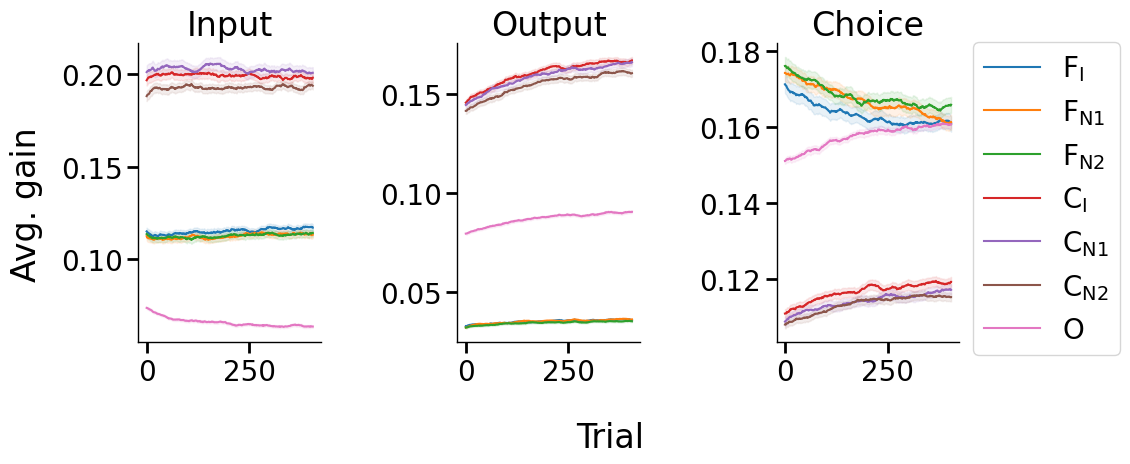

In [336]:
fig, axes = plt.subplots(1,3, figsize=(12,5), sharex=True)

_ = plot_gain_sel_overlap_dynamic(all_model_dpca_in, h_gain[...,input_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[0])

_ = plot_gain_sel_overlap_dynamic(all_model_dpca_out, h_gain[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[1])

_ = plot_gain_sel_overlap_dynamic(all_model_dpca_ch, h_gain[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[2])

fig.supylabel('Avg. gain', x=0.05, y=0.55)
fig.supxlabel('Trial', x=0.55, y=0.05)

axes[-1].legend(bbox_to_anchor=(1.0, 1.05))

# for a in axes:
#     a.set_ylim([0, a.get_ylim()[1]])

axes[0].set_title('Input')
axes[1].set_title('Output')
axes[2].set_title('Choice')

plt.tight_layout()

sns.despine()

## Routing through alignment
$$
(A\odot(h_{s-1}h_{s-1}^{\top}))h_s
$$

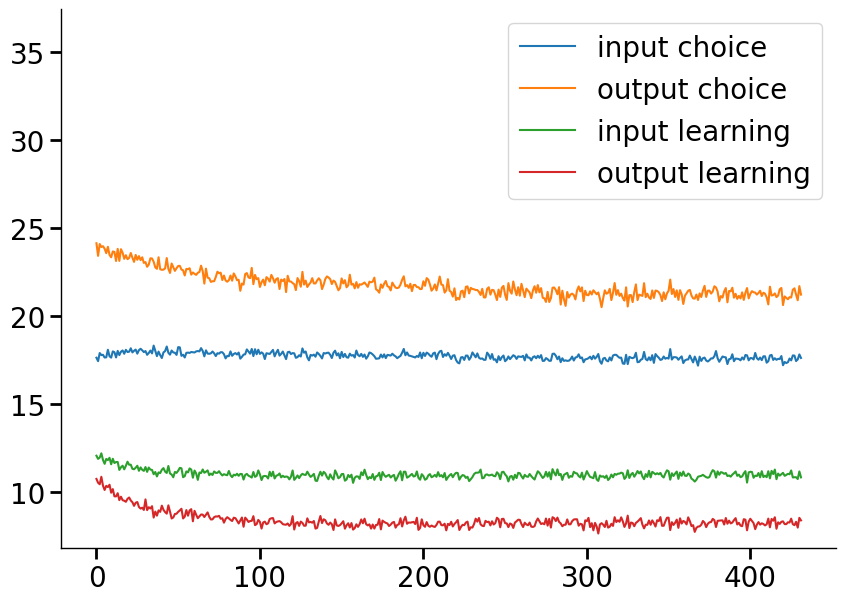

In [321]:
plt.plot((h_avg_ch[...,input_weight_inds]**2).sum(-1).mean(1), label='input choice')
plt.plot((h_avg_ch[...,output_weight_inds]**2).sum(-1).mean(1), label='output choice')
plt.plot((h_avg_lrn[...,input_weight_inds]**2).sum(-1).mean(1), label='input learning')
plt.plot((h_avg_lrn[...,output_weight_inds]**2).sum(-1).mean(1), label='output learning')
plt.ylim([plt.ylim()[0], plt.ylim()[1]*1.5])
plt.legend()
sns.despine()

In [347]:
def plot_hs_exp_var_dynamic(all_model_dpca, all_sess_hs, all_sess_chosen, all_sess_foregone,
                            all_sess_model_assignment, all_sess_dim_order_reverse, task_mdprl,
                            ax):

    all_sess_choice_proj = []
    all_sess_exp_var = []
    
    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
    dim_labels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O']
    
    for sess_idx in tqdm.tqdm(range(92)):
        
#         if (all_sess_model_assignment[sess_idx]!=2):
#             continue
        
        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [obj_key]

        permutted_key_index = np.concatenate([
            np.array(all_sess_dim_order_reverse[sess_idx]), 
            np.array(all_sess_dim_order_reverse[sess_idx])+3, [6]])
    
        curr_sess_dpca = all_model_dpca[all_sess_model_assignment[sess_idx]]
        
        num_trials = len(all_sess_chosen)
        
        curr_sess_choice_proj = np.zeros((num_trials,7))
        curr_sess_exp_var = np.zeros((num_trials,7))
        
        curr_sess_better = np.empty_like(all_sess_chosen[...,sess_idx])*np.nan
        curr_sess_worse = np.empty_like(all_sess_chosen[...,sess_idx])*np.nan

#         curr_sess_correct = all_saved_states['choose_better'][...,sess_idx]
        curr_sess_chosen = all_sess_chosen[...,sess_idx].long()
        curr_sess_foregone = all_sess_foregone[...,sess_idx].long()
                
#         curr_sess_better[curr_sess_correct>0.5] = curr_sess_chosen[curr_sess_correct>0.5]
#         curr_sess_better[curr_sess_correct<0.5] = curr_sess_foregone[curr_sess_correct<0.5]
#         curr_sess_better = curr_sess_better.astype(int)
        
#         curr_sess_worse[curr_sess_correct>0.5] = curr_sess_foregone[curr_sess_correct>0.5]
#         curr_sess_worse[curr_sess_correct<0.5] = curr_sess_chosen[curr_sess_correct<0.5]
#         curr_sess_worse = curr_sess_worse.astype(int)
        
        stim_chosen_FCO = obj_to_ft_conj(curr_sess_chosen, task_mdprl).squeeze()
#         stim_chosen_FCO = obj_to_ft_conj(curr_sess_better, task_mdprl).squeeze()
        stim_chosen_FCO = stim_chosen_FCO[...,permutted_key_index]

        stim_foregone_FCO = obj_to_ft_conj(curr_sess_foregone, task_mdprl).squeeze()
#         stim_foregone_FCO = obj_to_ft_conj(curr_sess_worse, task_mdprl).squeeze()
        stim_foregone_FCO = stim_foregone_FCO[...,permutted_key_index]
        
        curr_sess_hs = all_sess_hs[:, sess_idx, :].detach().numpy().copy()
#         curr_sess_hs -= curr_sess_hs.mean(-1, keepdims=True)
        
        for k_idx, k_name in enumerate(permutted_key_order):
                        
            curr_sess_dim_psth = curr_sess_dpca.marginalized_psth[k_name].squeeze()[:].reshape((args['hidden_size'], -1))
            
            chosen_direction = curr_sess_dim_psth[:,stim_chosen_FCO[:,k_idx]]
#             chosen_direction = chosen_direction/np.linalg.norm(chosen_direction, axis=0, keepdims=True)
            foregone_direction = curr_sess_dim_psth[:,stim_foregone_FCO[:,k_idx]]            
#             foregone_direction = foregone_direction/np.linalg.norm(foregone_direction, axis=0, keepdims=True)
            choice_direction = (chosen_direction-foregone_direction)
            choice_direction = choice_direction/np.linalg.norm(choice_direction, axis=0, keepdims=True)
        
            
            h_choice_proj = (curr_sess_hs*choice_direction.T).sum(1)
            h_reparam = (curr_sess_hs@curr_sess_dpca.P[k_name])
            
            curr_sess_choice_proj[:,k_idx] = (h_choice_proj)/(np.linalg.norm(curr_sess_hs, axis=1)+1e-6)
            curr_sess_exp_var[:,k_idx] = (h_reparam**2).sum(1)/(np.linalg.norm(curr_sess_hs, axis=1)**2+1e-6)

        all_sess_choice_proj.append(curr_sess_choice_proj)
        all_sess_exp_var.append(curr_sess_exp_var)
        
    all_sess_choice_proj = np.stack(all_sess_choice_proj, 1)
    
#     all_sess_choice_proj[:,:,:3] -= all_sess_choice_proj[:,:,:3].mean(-1, keepdims=True)
#     all_sess_choice_proj[:,:,3:6] -= all_sess_choice_proj[:,:,3:6].mean(-1, keepdims=True)
    
    all_sess_exp_var = np.stack(all_sess_exp_var, 1)
    
    w_size = 432//4
    
    for idx_k in range(7):
        
        smth_exp_var = np.stack([
            np.convolve(all_sess_exp_var[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
                for idx_sess in range(all_sess_choice_proj.shape[1])], axis=1)
        
        plot_mean_and_std(ax=ax,
                      m=smth_exp_var.mean(1), 
                      sd=smth_exp_var.std(1)/np.sqrt(92), 
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))
        
#         ax.set_ylim([-ax.get_ylim()[1]*0.1, ax.get_ylim()[1]*1.])
#         ax.set_ylim([-0.1, 0.6])

    fig.tight_layout()
    
    return all_sess_choice_proj
    
    

100%|██████████| 92/92 [00:00<00:00, 715.18it/s]


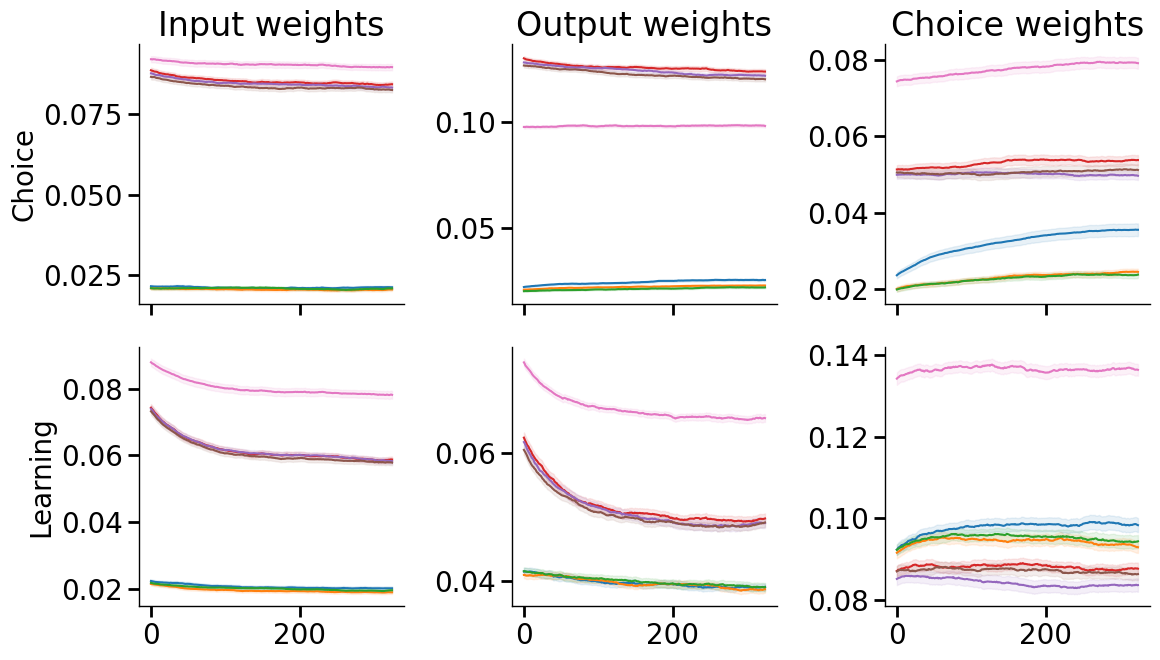

In [348]:
fig, axes = plt.subplots(2,3, figsize=(12,7), sharex=True)


h_avg_ch = all_saved_states['hs'][:,task_mdprl.T_fixation+task_mdprl.T_stim-1,:,:] 

_ = plot_hs_exp_var_dynamic(all_model_dpca_in, h_avg_ch[...,input_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[0,0])

_ = plot_hs_exp_var_dynamic(all_model_dpca_out, h_avg_ch[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[0,1])

_ = plot_hs_exp_var_dynamic(all_model_dpca_ch, h_avg_ch[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[0,2])

_ = plot_hs_exp_var_dynamic(all_model_dpca_in, h_avg_lrn[...,input_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[1,0])


_ = plot_hs_exp_var_dynamic(all_model_dpca_out, h_avg_lrn[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[1,1])

_ = plot_hs_exp_var_dynamic(all_model_dpca_ch, h_avg_lrn[...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[1,2])

axes[0,0].set_ylabel('Choice')
axes[1,0].set_ylabel('Learning')

axes[0,0].set_title('Input weights')
axes[0,1].set_title('Output weights')
axes[0,2].set_title('Choice weights')

sns.despine()
plt.tight_layout()

In [325]:
def plot_hs_exp_var_dynamic_by_timestep(all_model_dpca, all_sess_hs, all_sess_chosen, all_sess_foregone,
                                        all_sess_model_assignment, all_sess_dim_order_reverse, task_mdprl,
                                        ax):

    all_sess_choice_proj = []
    all_sess_exp_var = []
    
    ft_keys=['s','p','c']
    conj_keys=['pc','sc','sp']
    obj_key='spc'
    
    dim_labels = [r'$F_{I}$', r'$F_{N1}$', r'$F_{N2}$', r'$C_{I}$', r'$C_{N1}$', r'$C_{N2}$', 'O']
    
    for sess_idx in tqdm.tqdm(range(92)):
        
#         if (all_sess_model_assignment[sess_idx]!=2):
#             continue
        
        permutted_key_order = [ft_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [conj_keys[i] for i in all_sess_dim_order_reverse[sess_idx]] + \
                              [obj_key]

        permutted_key_index = np.concatenate([
            np.array(all_sess_dim_order_reverse[sess_idx]), 
            np.array(all_sess_dim_order_reverse[sess_idx])+3, [6]])
    
        curr_sess_dpca = all_model_dpca[all_sess_model_assignment[sess_idx]]
        
        num_trials = len(all_sess_chosen)
        num_timesteps = all_sess_hs.shape[1]
        
        curr_sess_choice_proj = np.zeros((num_trials,num_timesteps,7))
        curr_sess_exp_var = np.zeros((num_trials,num_timesteps,7))
        
        curr_sess_better = np.empty_like(all_sess_chosen[...,sess_idx])*np.nan
        curr_sess_worse = np.empty_like(all_sess_chosen[...,sess_idx])*np.nan

#         curr_sess_correct = all_saved_states['choose_better'][...,sess_idx]
        curr_sess_chosen = all_sess_chosen[...,sess_idx].long()
        curr_sess_foregone = all_sess_foregone[...,sess_idx].long()
                
#         curr_sess_better[curr_sess_correct>0.5] = curr_sess_chosen[curr_sess_correct>0.5]
#         curr_sess_better[curr_sess_correct<0.5] = curr_sess_foregone[curr_sess_correct<0.5]
#         curr_sess_better = curr_sess_better.astype(int)
        
#         curr_sess_worse[curr_sess_correct>0.5] = curr_sess_foregone[curr_sess_correct>0.5]
#         curr_sess_worse[curr_sess_correct<0.5] = curr_sess_chosen[curr_sess_correct<0.5]
#         curr_sess_worse = curr_sess_worse.astype(int)
        
        stim_chosen_FCO = obj_to_ft_conj(curr_sess_chosen, task_mdprl).squeeze()
#         stim_chosen_FCO = obj_to_ft_conj(curr_sess_better, task_mdprl).squeeze()
        stim_chosen_FCO = stim_chosen_FCO[...,permutted_key_index]

        stim_foregone_FCO = obj_to_ft_conj(curr_sess_foregone, task_mdprl).squeeze()
#         stim_foregone_FCO = obj_to_ft_conj(curr_sess_worse, task_mdprl).squeeze()
        stim_foregone_FCO = stim_foregone_FCO[...,permutted_key_index]
        
        curr_sess_hs = all_sess_hs[:, :, sess_idx, :].detach().numpy().copy()
#         curr_sess_hs -= curr_sess_hs.mean(-1, keepdims=True)
        
        for k_idx, k_name in enumerate(permutted_key_order):
                        
            curr_sess_dim_psth = curr_sess_dpca.marginalized_psth[k_name].squeeze()[:].reshape((args['hidden_size'], -1))
            
            chosen_direction = curr_sess_dim_psth[:,stim_chosen_FCO[:,k_idx]]
#             chosen_direction = chosen_direction/np.linalg.norm(chosen_direction, axis=0, keepdims=True)
            foregone_direction = curr_sess_dim_psth[:,stim_foregone_FCO[:,k_idx]]            
#             foregone_direction = foregone_direction/np.linalg.norm(foregone_direction, axis=0, keepdims=True)
            choice_direction = (chosen_direction-foregone_direction)
            choice_direction = choice_direction/np.linalg.norm(choice_direction, axis=0, keepdims=True)
            choice_direction = choice_direction.T[:,None]
            
            h_choice_proj = (curr_sess_hs*choice_direction).sum(-1)
            h_reparam = (curr_sess_hs@curr_sess_dpca.P[k_name])
                        
            curr_sess_choice_proj[:,:,k_idx] = (h_choice_proj)/(np.linalg.norm(curr_sess_hs, axis=-1)+1e-6)
            curr_sess_exp_var[:,:,k_idx] = (h_reparam**2).sum(-1)/(np.linalg.norm(curr_sess_hs, axis=-1)**2+1e-6)

        all_sess_choice_proj.append(curr_sess_choice_proj)
        all_sess_exp_var.append(curr_sess_exp_var)
        
    all_sess_choice_proj = np.stack(all_sess_choice_proj, 1)
    all_sess_exp_var = np.stack(all_sess_exp_var, 1)
    
    
    for idx_k in range(7):
        
#         smth_exp_var = np.stack([
#             np.convolve(all_sess_choice_proj[:,idx_sess,idx_k], np.ones(w_size)/w_size, mode='valid')
#                 for idx_sess in range(all_sess_choice_proj.shape[1])], axis=1)
        
        plot_mean_and_std(ax=ax,
                      m=all_sess_choice_proj[216:,:,:,idx_k].mean((0,1)), 
                      sd=all_sess_choice_proj[216:,:,:,idx_k].mean(0).std(0)/np.sqrt(92), 
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,1]))
        
#         ax.set_ylim([-ax.get_ylim()[1]*0.1, ax.get_ylim()[1]*1.])
#         ax.set_ylim([-0.1, 0.6])

        ax.axvline(task_mdprl.T_fixation-1, ls=':', color='lightgrey')
        ax.axvline(task_mdprl.T_stim+task_mdprl.T_fixation-1, ls=':', color='lightgrey')
        ax.axvline(task_mdprl.T_stim+task_mdprl.T_fixation+task_mdprl.T_ch-1, ls=':', color='lightgrey')

    fig.tight_layout()
    
    return all_sess_choice_proj
    
    

100%|██████████| 92/92 [00:04<00:00, 19.41it/s]


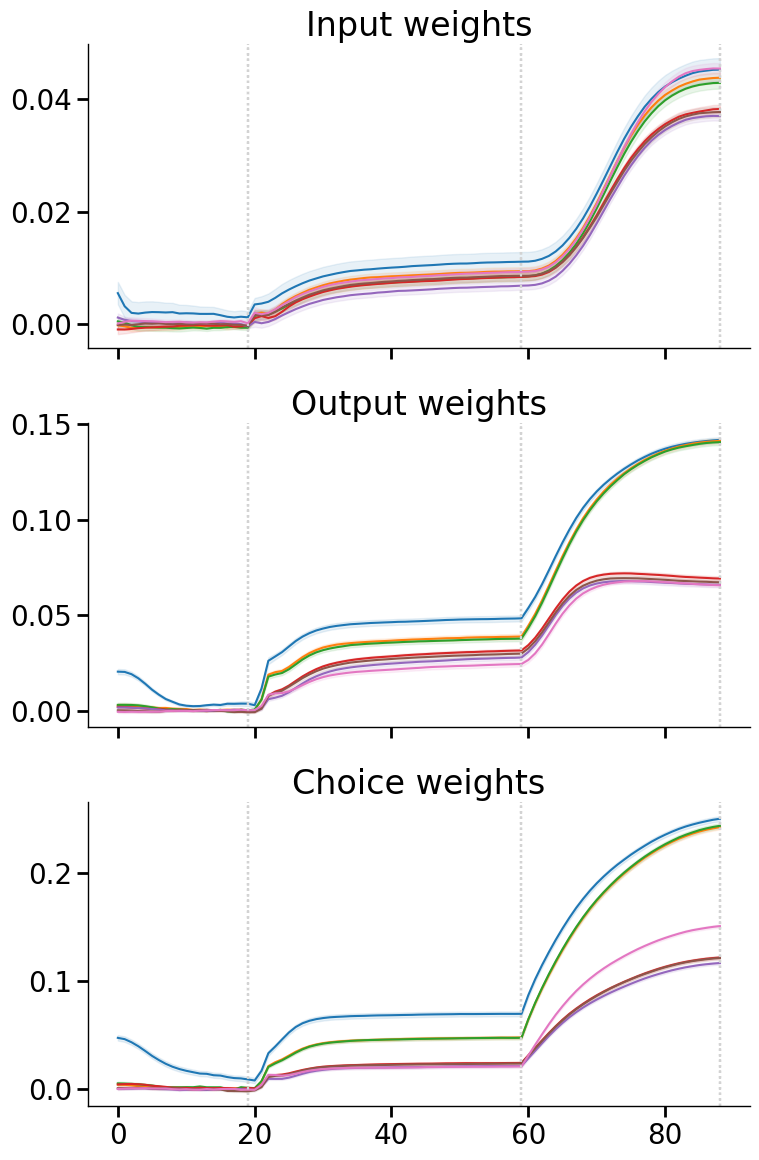

In [326]:
fig, axes = plt.subplots(3,1, figsize=(8,12), sharex=True)


h_avg_ch = all_saved_states['hs'][:,task_mdprl.T_fixation+task_mdprl.T_stim-1,:,:] 

_ = plot_hs_exp_var_dynamic_by_timestep(all_model_dpca_in, all_saved_states['hs'][...,input_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'], 
                            task_mdprl, axes[0])

_ = plot_hs_exp_var_dynamic_by_timestep(all_model_dpca_out, all_saved_states['hs'][...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[1])

_ = plot_hs_exp_var_dynamic_by_timestep(all_model_dpca_ch, all_saved_states['hs'][...,output_weight_inds], 
                            all_saved_states['choices'], all_saved_states['foregone'], 
                            all_saved_states['model_assignment'], 
                            all_saved_states['test_stim_dim_order'],
                            task_mdprl, axes[2])


axes[0].set_title('Input weights')
axes[1].set_title('Output weights')
axes[2].set_title('Choice weights')

sns.despine()
plt.tight_layout()

2

[0 2 1]

[[2 0 1]
 [1 0 2]
 [0 2 1]]

[[[[ 2  0  1  1  7  6 19]
   [ 2  2  1  7  7  8 25]
   [ 2  1  1  4  7  7 22]]

  [[ 2  0  0  0  6  6 18]
   [ 2  2  0  6  6  8 24]
   [ 2  1  0  3  6  7 21]]

  [[ 2  0  2  2  8  6 20]
   [ 2  2  2  8  8  8 26]
   [ 2  1  2  5  8  7 23]]]


 [[[ 0  0  1  1  1  0  1]
   [ 0  2  1  7  1  2  7]
   [ 0  1  1  4  1  1  4]]

  [[ 0  0  0  0  0  0  0]
   [ 0  2  0  6  0  2  6]
   [ 0  1  0  3  0  1  3]]

  [[ 0  0  2  2  2  0  2]
   [ 0  2  2  8  2  2  8]
   [ 0  1  2  5  2  1  5]]]


 [[[ 1  0  1  1  4  3 10]
   [ 1  2  1  7  4  5 16]
   [ 1  1  1  4  4  4 13]]

  [[ 1  0  0  0  3  3  9]
   [ 1  2  0  6  3  5 15]
   [ 1  1  0  3  3  4 12]]

  [[ 1  0  2  2  5  3 11]
   [ 1  2  2  8  5  5 17]
   [ 1  1  2  5  5  4 14]]]]

tensor(0.4537) 0.37499943750084375
tensor(0.3937) 0.4409715607648812
tensor(0.6954) 0.6840267517376504

tensor(0.5656) 0.42361047569539767
tensor(0.5102) 0.5104159010428152
tensor(0.5644) 0.5659713732651624

tensor(0.5294) 0.47222151

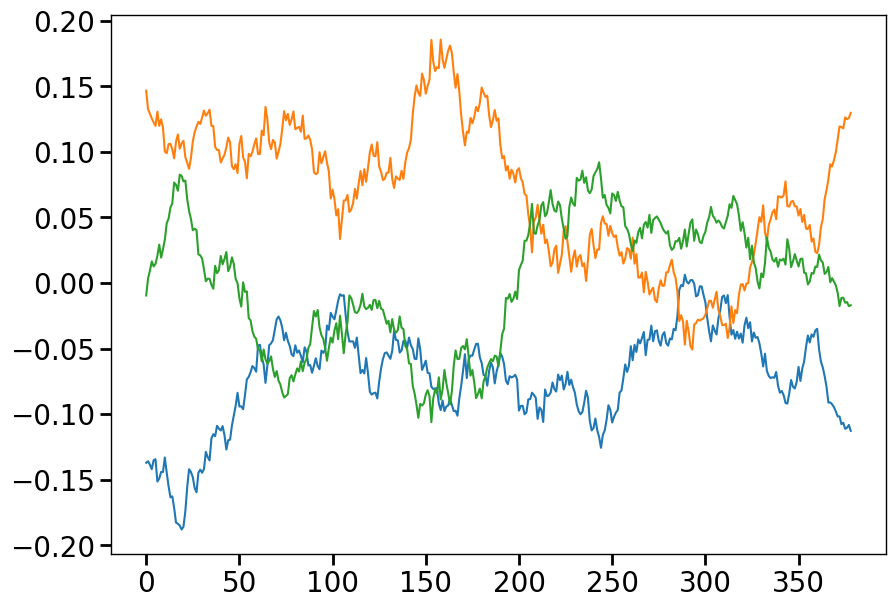

In [349]:
iii = 0

mmm = all_saved_states['model_assignment'][iii]

print(all_saved_states['model_assignment'][iii])
print()
print(all_saved_states['test_stim_dim_order'][iii])
print()
print(all_saved_states['test_stim_val_order'][iii])
print()
print(obj_to_ft_conj(all_saved_states['test_stim2sensory_idx'][iii].reshape((3,3,3)), task_mdprl))
print()

# check reward assignment actually reflects feature values permutations
for key_idx_to_plot in range(3):
    for i in range(3):
        ch_idx = (obj_to_ft_conj(all_saved_states['choices'][:,0,iii], task_mdprl)[:,key_idx_to_plot])==i
        fg_idx = (obj_to_ft_conj(all_saved_states['foregone'][:,0,iii], task_mdprl)[:,key_idx_to_plot])==i
        print(all_saved_states['rewards'][ch_idx,0,iii].mean(), ((1.0*ch_idx).sum()/(1.0*ch_idx+1.0*fg_idx+1e-6).sum()))
    print()


centered_h2o = all_models[mmm].h2o.effective_weight().t().detach()
centered_h2o -= centered_h2o.mean(1, keepdims=True)

all_logits = (h_avg_ch[:,iii,64:128]@(centered_h2o@task_mdprl.pop_fco[0][2]))

proj_w = all_model_dpca_out[mmm].marginalized_psth['c'].squeeze()[:64].reshape(64,-1)
# proj_w = proj_w[:,None,:]-proj_w[:,:,None]
# proj_w = proj_w[:,[0,0,1],[1,2,2]]

all_dpca_proj = h_avg_ch[:,iii,64:128]@(proj_w)

print(np.histogram(np.argmax(all_logits, -1).float(), bins=np.arange(10)))
print(all_dpca_proj.mean(0))
print(all_logits.mean(0))

wsize = 432//8

plt.plot(np.stack(
    [np.convolve(lll, np.ones(wsize)/wsize, mode='valid') for lll in all_dpca_proj[:].T]).T);
# plt.imshow(all_logits.T, aspect='auto')



[1 0 2]

[[1 0 2]
 [2 0 1]
 [0 1 2]]

[[ 0  2  1  7  1  2  7]
 [ 1  1  2  5  5  4 14]]
[ 1  1  2  5  5  4 14]
[0 2 1 7 1 2 7]
['p', 's', 'c', 'sc', 'pc', 'sp', 'spc']


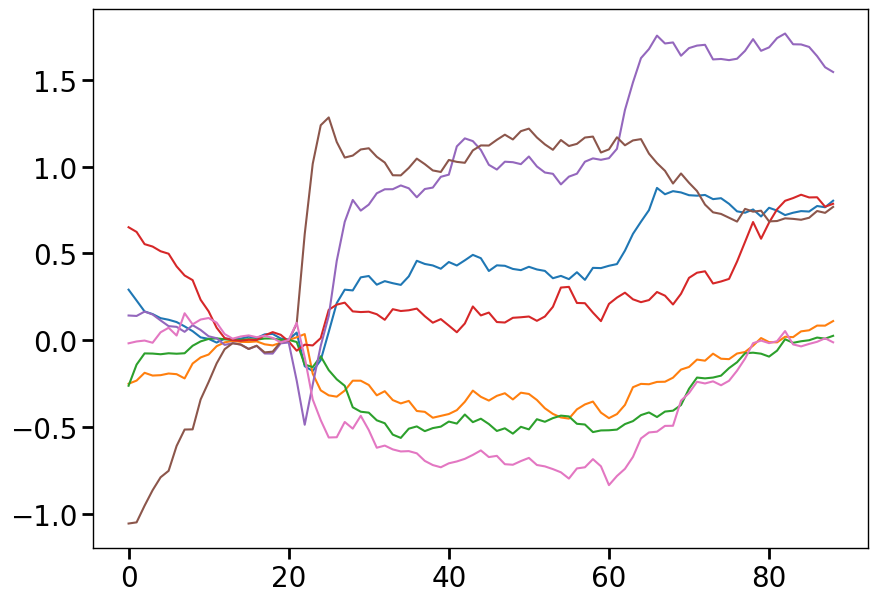

In [342]:
ttt=233
iii=30

print(all_saved_states['test_stim_dim_order'][iii])
print()
print(all_saved_states['test_stim_val_order'][iii])
print()

stims_chosen_FCO = obj_to_ft_conj(all_saved_states['choices'][ttt,0,iii], task_mdprl)

stims_foregone_FCO = obj_to_ft_conj(all_saved_states['foregone'][ttt,0,iii], task_mdprl)

print(obj_to_ft_conj(all_saved_states['stimuli'][ttt,0,iii], task_mdprl))
print(obj_to_ft_conj(all_saved_states['choices'][ttt,0,iii], task_mdprl))
print(obj_to_ft_conj(all_saved_states['foregone'][ttt,0,iii], task_mdprl))

ft_keys=['s','p','c']
conj_keys=['pc','sc','sp']
obj_key='spc'

permuted_key_index = np.concatenate([
            np.array(all_saved_states['test_stim_dim_order'][iii]), 
            np.array(all_saved_states['test_stim_dim_order'][iii])+3, [6]])
stims_chosen_FCO = stims_chosen_FCO[...,permuted_key_index]
stims_foregone_FCO = stims_foregone_FCO[...,permuted_key_index]


permuted_key_order= [ft_keys[i] for i in all_saved_states['test_stim_dim_order'][iii]] + \
                    [conj_keys[i] for i in all_saved_states['test_stim_dim_order'][iii]] + \
                                            [obj_key]

print(permuted_key_order)

for (key_idx_to_plot, key_to_plot) in enumerate(permuted_key_order):

    curr_psth = all_model_dpca_out[all_saved_states['model_assignment'][iii]].marginalized_psth[key_to_plot].reshape(-1,3**len(key_to_plot))[:]
    plt.plot(all_saved_states['hs'][ttt,:,iii,output_weight_inds[:]]@\
             (curr_psth[:,stims_chosen_FCO[key_idx_to_plot]]-curr_psth[:,stims_foregone_FCO[key_idx_to_plot]]))
# plt.ylim([-len(key_to_plot)*1.5, len(key_to_plot)*1.5])



